In [1]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.layers import Dropout
import xgboost
import pickle

**Stock price prediction in 15 minutes for Microsoft, combining models and indicators.**

# DATA COLLECTION

In [2]:
alpha_key = 'RNZPXZ6Q9FEFMEHM'
ticker = 'META'
periods = 20
csvPath = './DATA/'+ ticker +'.csv'
from alpha_vantage.timeseries import TimeSeries

ts = TimeSeries(key=alpha_key, output_format='pandas')

In [3]:
data = ts.get_intraday(symbol=ticker,interval='15min', outputsize='full')
data = data[0]
data.rename(lambda x: x[2:].strip(), axis='columns', inplace=True)
data

open    high     low    close  volume
date                                                         
2023-08-25 19:45:00  284.895  285.10  284.80  285.100  3828.0
2023-08-25 19:30:00  284.895  285.00  284.80  284.895  2896.0
2023-08-25 19:15:00  284.950  284.99  284.80  284.870   852.0
2023-08-25 19:00:00  284.930  284.99  284.80  284.800  1084.0
2023-08-25 18:45:00  284.750  285.00  284.72  284.720  1845.0
...                      ...     ...     ...      ...     ...
2023-08-04 05:00:00  315.150  315.47  315.13  315.250   891.0
2023-08-04 04:45:00  315.150  315.28  315.01  315.100  1581.0
2023-08-04 04:30:00  315.320  315.48  315.05  315.120  1275.0
2023-08-04 04:15:00  315.800  315.98  315.31  315.310  2663.0
2023-08-04 04:00:00  315.500  317.00  314.25  315.780  4929.0

[1024 rows x 5 columns]

# INDICATORS CALCULATION

In [4]:
from alpha_vantage.techindicators import TechIndicators
ti = TechIndicators(key=alpha_key, output_format='pandas')

## 1. Rate of Change (ROC)

In [5]:
indicator_roc = ti.get_roc(symbol=ticker, interval='15min', time_period=periods)
indicator_roc = indicator_roc[0]
indicator_roc

ROC
date                       
2023-08-04 09:00:00 -0.0823
2023-08-04 09:15:00 -0.1205
2023-08-04 09:30:00  0.4379
2023-08-04 09:45:00 -0.3316
2023-08-04 10:00:00 -0.4076
...                     ...
2023-08-25 18:45:00  1.6313
2023-08-25 19:00:00  1.1303
2023-08-25 19:15:00  0.1934
2023-08-25 19:30:00  0.3469
2023-08-25 19:45:00  0.0105

[1004 rows x 1 columns]

## 2. Simple Moving Average (SMA)

In [6]:
indicator_sma = ti.get_sma(symbol=ticker, interval='15min', time_period=periods)
indicator_sma = indicator_sma[0]
indicator_sma


SMA
date                         
2023-08-04 08:45:00  315.0010
2023-08-04 09:00:00  314.9880
2023-08-04 09:15:00  314.9690
2023-08-04 09:30:00  315.0380
2023-08-04 09:45:00  314.9858
...                       ...
2023-08-25 18:45:00  284.8623
2023-08-25 19:00:00  285.0215
2023-08-25 19:15:00  285.0490
2023-08-25 19:30:00  285.0982
2023-08-25 19:45:00  285.0997

[1005 rows x 1 columns]

## 3. Relative Strength Index (RSI)

In [7]:
indicator_rsi = ti.get_rsi(symbol=ticker, interval='15min', time_period=periods)
indicator_rsi = indicator_rsi[0]
indicator_rsi

RSI
date                        
2023-08-04 09:00:00  47.8689
2023-08-04 09:15:00  43.4456
2023-08-04 09:30:00  55.0738
2023-08-04 09:45:00  41.1903
2023-08-04 10:00:00  40.7919
...                      ...
2023-08-25 18:45:00  52.2097
2023-08-25 19:00:00  52.6051
2023-08-25 19:15:00  52.9634
2023-08-25 19:30:00  53.0968
2023-08-25 19:45:00  54.2170

[1004 rows x 1 columns]

## 4. Bolling Bands (BBANDS)

In [8]:
def BollingerBand(data, n_loockback, n_std=2):
    hlc_avg = (data.high + data.low + data.close)/3
    data_std = hlc_avg.rolling(window=n_loockback).std()
    data_upper = data.SMA + n_std * data_std
    data_lower = data.SMA - n_std * data_std
    return data.SMA, data_lower, data_upper

In [9]:
indicator_bb = ti.get_bbands(symbol=ticker, interval='15min', time_period=periods)
indicator_bb = indicator_bb[0]
indicator_bb

Real Upper Band  Real Middle Band  Real Lower Band
date                                                                   
2023-08-25 19:45:00         285.9940          285.0997         284.2055
2023-08-25 19:30:00         285.9926          285.0982         284.2039
2023-08-25 19:15:00         286.0807          285.0490         284.0173
2023-08-25 19:00:00         286.0991          285.0215         283.9439
2023-08-25 18:45:00         286.6976          284.8623         283.0271
...                              ...               ...              ...
2023-08-04 09:45:00         316.2587          314.9858         313.7128
2023-08-04 09:30:00         316.2375          315.0380         313.8385
2023-08-04 09:15:00         315.9658          314.9690         313.9722
2023-08-04 09:00:00         315.9955          314.9880         313.9805
2023-08-04 08:45:00         316.0418          315.0010         313.9602

[1005 rows x 3 columns]

**Merge indicators to data**

In [10]:
original_df = pd.merge(data, indicator_roc, on='date', how='inner')
original_df = pd.merge(original_df, indicator_sma, on='date', how='inner')
original_df = pd.merge(original_df, indicator_rsi, on='date', how='inner')
original_df = pd.merge(original_df, indicator_bb, on='date', how='inner')
original_df["Real Middle Band"], original_df["Real Lower Band"], original_df["Real Upper Band"] = BollingerBand(original_df, 20, 2)
original_df = original_df.dropna()
original_df = original_df.iloc[::-1]
original_df.to_csv(csvPath)
original_df

open     high      low    close     volume     ROC  \
date                                                                         
2023-08-04 09:00:00  315.580  315.800  310.345  315.520    28445.0 -0.0823   
2023-08-04 09:15:00  315.520  315.650  314.100  314.930    34239.0 -0.1205   
2023-08-04 09:30:00  314.960  318.410  314.680  316.500  1613569.0  0.4379   
2023-08-04 09:45:00  316.455  317.750  314.050  314.055   817536.0 -0.3316   
2023-08-04 10:00:00  314.055  314.660  312.760  313.965   868140.0 -0.4076   
...                      ...      ...      ...      ...        ...     ...   
2023-08-25 14:00:00  280.180  281.616  280.020  281.617   363166.0 -1.9985   
2023-08-25 14:15:00  281.650  284.330  281.335  284.320   868083.0 -0.6985   
2023-08-25 14:30:00  284.330  285.300  283.710  283.910   852731.0 -0.8677   
2023-08-25 14:45:00  283.960  285.070  283.410  285.070   381817.0 -0.6621   
2023-08-25 15:00:00  285.010  285.900  283.890  285.590   579807.0 -0.7817   

                          SMA      RSI  Real Upper Band  Real Middle Band  \
date                                                                        
2023-08-04 09:00:00  314.9880  47.8689       316.703463          314.9880   
2023-08-04 09:15:00  314.9690  43.4456       316.928951          314.9690   
2023-08-04 09:30:00  315.0380  55.0738       317.458728          315.0380   
2023-08-04 09:45:00  314.9858  41.1903       317.673751          314.9858   
2023-08-04 10:00:00  314.9215  40.7919       317.880570          314.9215   
...                       ...      ...              ...               ...   
2023-08-25 14:00:00  281.1018  44.7020       283.550959          281.1018   
2023-08-25 14:15:00  281.0018  53.4391       282.805418          281.0018   
2023-08-25 14:30:00  280.8776  52.1242       282.544106          280.8776   
2023-08-25 14:45:00  280.7825  55.3931       282.427650          280.7825   
2023-08-25 15:00:00  280.6700  56.7854       282.305539          280.6700   

                     Real Lower Band  
date                                  
2023-08-04 09:00:00       313.272537  
2023-08-04 09:15:00       313.009049  
2023-08-04 09:30:00       312.617272  
2023-08-04 09:45:00       312.297849  
2023-08-04 10:00:00       311.962430  
...                              ...  
2023-08-25 14:00:00       278.652641  
2023-08-25 14:15:00       279.198182  
2023-08-25 14:30:00       279.211094  
2023-08-25 14:45:00       279.137350  
2023-08-25 15:00:00       279.034461  

[985 rows x 11 columns]

# MODEL TRAINING

## 1. LSTM

### a. Prepare Input

In [11]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[315.52 ],
       [314.93 ],
       [316.5  ],
       [314.055],
       [313.965],
       [313.65 ],
       [313.41 ],
       [313.785],
       [314.265],
       [314.75 ],
       [314.68 ],
       [315.1  ],
       [315.38 ],
       [315.78 ],
       [316.45 ],
       [315.44 ],
       [314.855],
       [314.11 ],
       [314.37 ],
       [313.43 ],
       [312.275],
       [311.3  ],
       [310.7  ],
       [311.395],
       [312.15 ],
       [311.68 ],
       [310.945],
       [310.73 ],
       [310.755],
       [310.9  ],
       [311.1  ],
       [310.84 ],
       [310.955],
       [310.825],
       [310.98 ],
       [311.2  ],
       [311.   ],
       [310.855],
       [310.76 ],
       [310.95 ],
       [310.82 ],
       [310.85 ],
       [310.76 ],
       [310.79 ],
       [312.65 ],
       [312.81 ],
       [312.23 ],
       [312.4  ],
       [312.44 ],
       [312.49 ],
       [312.3  ],
       [312.31 ],
       [312.02 ],
       [311.75 ],
       [311.7  ],
       [31

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.974678  ],
       [0.96031263],
       [0.99853912],
       [0.93900806],
       [0.93681673],
       [0.92914709],
       [0.92330355],
       [0.93243408],
       [0.94412116],
       [0.95592997],
       [0.95422561],
       [0.9644518 ],
       [0.97126927],
       [0.9810085 ],
       [0.99732171],
       [0.97273015],
       [0.95848652],
       [0.9403472 ],
       [0.9466777 ],
       [0.92379051],
       [0.89566848],
       [0.8719291 ],
       [0.85732025],
       [0.87424217],
       [0.89262497],
       [0.88118137],
       [0.86328553],
       [0.85805069],
       [0.85865939],
       [0.86218987],
       [0.86705948],
       [0.86072898],
       [0.86352901],
       [0.86036376],
       [0.86413771],
       [0.86949429],
       [0.86462467],
       [0.8610942 ],
       [0.85878114],
       [0.86340727],
       [0.86024202],
       [0.86097246],
       [0.85878114],
       [0.85951158],
       [0.90479901],
       [0.9086947 ],
       [0.89457281],
       [0.898

In [13]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

925
925


In [14]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (740, 60, 1)
Size validate:  (93, 60, 1)
Size test:  (92, 60, 1)


### b. Train Model

In [15]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM.h5")

Epoch 1/20
24/24 [==============================] - 5s 59ms/step - loss: 0.0593 - val_loss: 0.0030
Epoch 2/20
24/24 [==============================] - 1s 31ms/step - loss: 0.0048 - val_loss: 0.0023
Epoch 3/20
24/24 [==============================] - 1s 31ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 4/20
24/24 [==============================] - 1s 32ms/step - loss: 0.0015 - val_loss: 0.0037
Epoch 5/20
24/24 [==============================] - 1s 31ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 6/20
24/24 [==============================] - 1s 31ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 7/20
24/24 [==============================] - 1s 35ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 8/20
24/24 [==============================] - 1s 32ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 9/20
24/24 [==============================] - 1s 30ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 10/20
24/24 [==============================] - 1s 30ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 11/

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### c. Test Model

In [16]:
model_lstm = load_model('./MODEL/LSTM.h5')
model_lstm

In [17]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions)

3/3 [==============================] - 1s 11ms/step


In [18]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\USER\AppData\Local\Temp\ipykernel_14184\2018918845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


date    open     high      low    close    volume     ROC  \
893  2023-08-24 08:15:00  299.51  299.950  299.000  299.500   15816.0 -0.1633   
894  2023-08-24 08:30:00  299.30  299.800  294.240  299.477   20594.0 -0.1510   
895  2023-08-24 08:45:00  299.30  301.640  298.590  299.000   21160.0 -0.6974   
896  2023-08-24 09:00:00  299.00  299.500  292.540  299.400   26129.0 -0.4952   
897  2023-08-24 09:15:00  299.38  299.500  298.300  298.650   28398.0 -0.6784   
..                   ...     ...      ...      ...      ...       ...     ...   
980  2023-08-25 14:00:00  280.18  281.616  280.020  281.617  363166.0 -1.9985   
981  2023-08-25 14:15:00  281.65  284.330  281.335  284.320  868083.0 -0.6985   
982  2023-08-25 14:30:00  284.33  285.300  283.710  283.910  852731.0 -0.8677   
983  2023-08-25 14:45:00  283.96  285.070  283.410  285.070  381817.0 -0.6621   
984  2023-08-25 15:00:00  285.01  285.900  283.890  285.590  579807.0 -0.7817   

          SMA      RSI  Real Upper Band  Real Middle Band  Real Lower Band  \
893  300.2230  53.8008       307.793311          300.2230       292.652689   
894  300.2003  53.6581       307.345837          300.2003       293.054763   
895  300.0953  50.7207       306.971573          300.0953       293.219027   
896  300.0208  52.9922       306.086323          300.0208       293.955277   
897  299.9188  48.5732       305.553164          299.9188       294.284436   
..        ...      ...              ...               ...              ...   
980  281.1018  44.7020       283.550959          281.1018       278.652641   
981  281.0018  53.4391       282.805418          281.0018       279.198182   
982  280.8776  52.1242       282.544106          280.8776       279.211094   
983  280.7825  55.3931       282.427650          280.7825       279.137350   
984  280.6700  56.7854       282.305539          280.6700       279.034461   

     predictions  
893   299.923462  
894   299.848572  
895   299.760071  
896   299.635895  
897   299.526337  
..           ...  
980   279.781158  
981   279.917725  
982   280.282104  
983   280.745819  
984   281.314850  

[92 rows x 13 columns]

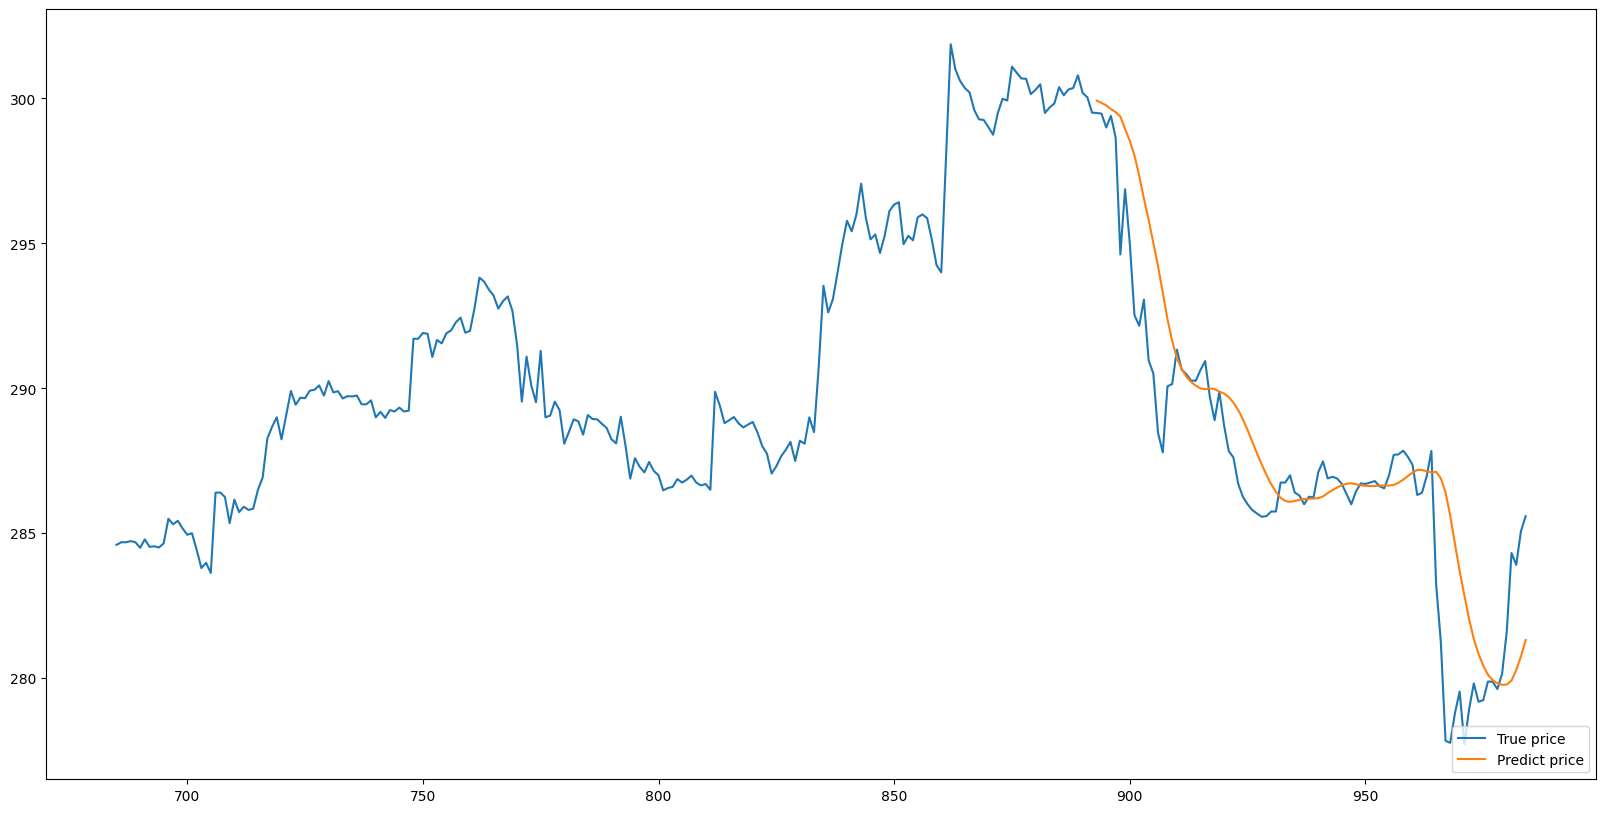

In [19]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [20]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset

array([[ 3.1552e+02, -8.2300e-02],
       [ 3.1493e+02, -1.2050e-01],
       [ 3.1650e+02,  4.3790e-01],
       ...,
       [ 2.8391e+02, -8.6770e-01],
       [ 2.8507e+02, -6.6210e-01],
       [ 2.8559e+02, -7.8170e-01]])

In [21]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.974678  , 0.55192858],
       [0.96031263, 0.54676949],
       [0.99853912, 0.62218411],
       ...,
       [0.20503518, 0.44585652],
       [0.23327896, 0.47362379],
       [0.24593996, 0.45747123]])

In [22]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

925
925


In [23]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (740, 60, 2)
Size validate:  (93, 60, 2)
Size test:  (92, 60, 2)


In [24]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC.h5")

Epoch 1/20
24/24 [==============================] - 4s 64ms/step - loss: 0.0776 - val_loss: 0.0043
Epoch 2/20
24/24 [==============================] - 1s 36ms/step - loss: 0.0063 - val_loss: 0.0033
Epoch 3/20
24/24 [==============================] - 1s 32ms/step - loss: 0.0021 - val_loss: 0.0053
Epoch 4/20
24/24 [==============================] - 1s 31ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 5/20
24/24 [==============================] - 1s 31ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 6/20
24/24 [==============================] - 1s 31ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 7/20
24/24 [==============================] - 1s 30ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 8/20
24/24 [==============================] - 1s 32ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 9/20
24/24 [==============================] - 1s 31ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 10/20
24/24 [==============================] - 1s 30ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 11/

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
model_lstm = load_model('./MODEL/LSTM_ROC.h5')

In [26]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]
predictions

3/3 [==============================] - 1s 11ms/step


array([300.112  , 300.02475, 299.91428, 299.6887 , 299.5029 , 299.28577,
       298.67725, 298.21448, 297.63306, 296.8061 , 295.95755, 295.22134,
       294.38477, 293.51022, 292.519  , 291.4867 , 290.70834, 290.09497,
       289.74988, 289.51306, 289.3649 , 289.25104, 289.16135, 289.14017,
       289.15585, 289.11243, 289.1438 , 289.14905, 289.11606, 289.0733 ,
       288.9812 , 288.71918, 288.4343 , 288.119  , 287.86197, 287.63394,
       287.29416, 286.92734, 286.53195, 286.1939 , 286.0036 , 285.91284,
       285.9057 , 285.876  , 285.823  , 285.798  , 285.83823, 285.84946,
       285.9792 , 286.2189 , 286.44073, 286.67755, 286.90057, 287.0782 ,
       287.18243, 287.2029 , 287.21454, 287.23322, 287.23773, 287.23843,
       287.19046, 287.1173 , 287.02396, 287.00464, 287.09045, 287.23785,
       287.40353, 287.5505 , 287.60864, 287.51538, 287.40182, 287.33026,
       287.36646, 287.0415 , 286.4211 , 285.4145 , 284.2689 , 283.20404,
       282.3149 , 281.43613, 280.72742, 280.2357 , 

In [27]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\USER\AppData\Local\Temp\ipykernel_14184\2018918845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


date    open     high      low    close    volume     ROC  \
893  2023-08-24 08:15:00  299.51  299.950  299.000  299.500   15816.0 -0.1633   
894  2023-08-24 08:30:00  299.30  299.800  294.240  299.477   20594.0 -0.1510   
895  2023-08-24 08:45:00  299.30  301.640  298.590  299.000   21160.0 -0.6974   
896  2023-08-24 09:00:00  299.00  299.500  292.540  299.400   26129.0 -0.4952   
897  2023-08-24 09:15:00  299.38  299.500  298.300  298.650   28398.0 -0.6784   
..                   ...     ...      ...      ...      ...       ...     ...   
980  2023-08-25 14:00:00  280.18  281.616  280.020  281.617  363166.0 -1.9985   
981  2023-08-25 14:15:00  281.65  284.330  281.335  284.320  868083.0 -0.6985   
982  2023-08-25 14:30:00  284.33  285.300  283.710  283.910  852731.0 -0.8677   
983  2023-08-25 14:45:00  283.96  285.070  283.410  285.070  381817.0 -0.6621   
984  2023-08-25 15:00:00  285.01  285.900  283.890  285.590  579807.0 -0.7817   

          SMA      RSI  Real Upper Band  Real Middle Band  Real Lower Band  \
893  300.2230  53.8008       307.793311          300.2230       292.652689   
894  300.2003  53.6581       307.345837          300.2003       293.054763   
895  300.0953  50.7207       306.971573          300.0953       293.219027   
896  300.0208  52.9922       306.086323          300.0208       293.955277   
897  299.9188  48.5732       305.553164          299.9188       294.284436   
..        ...      ...              ...               ...              ...   
980  281.1018  44.7020       283.550959          281.1018       278.652641   
981  281.0018  53.4391       282.805418          281.0018       279.198182   
982  280.8776  52.1242       282.544106          280.8776       279.211094   
983  280.7825  55.3931       282.427650          280.7825       279.137350   
984  280.6700  56.7854       282.305539          280.6700       279.034461   

     predictions  
893   300.112000  
894   300.024750  
895   299.914276  
896   299.688690  
897   299.502899  
..           ...  
980   279.015839  
981   279.147888  
982   279.618713  
983   280.199432  
984   280.871155  

[92 rows x 13 columns]

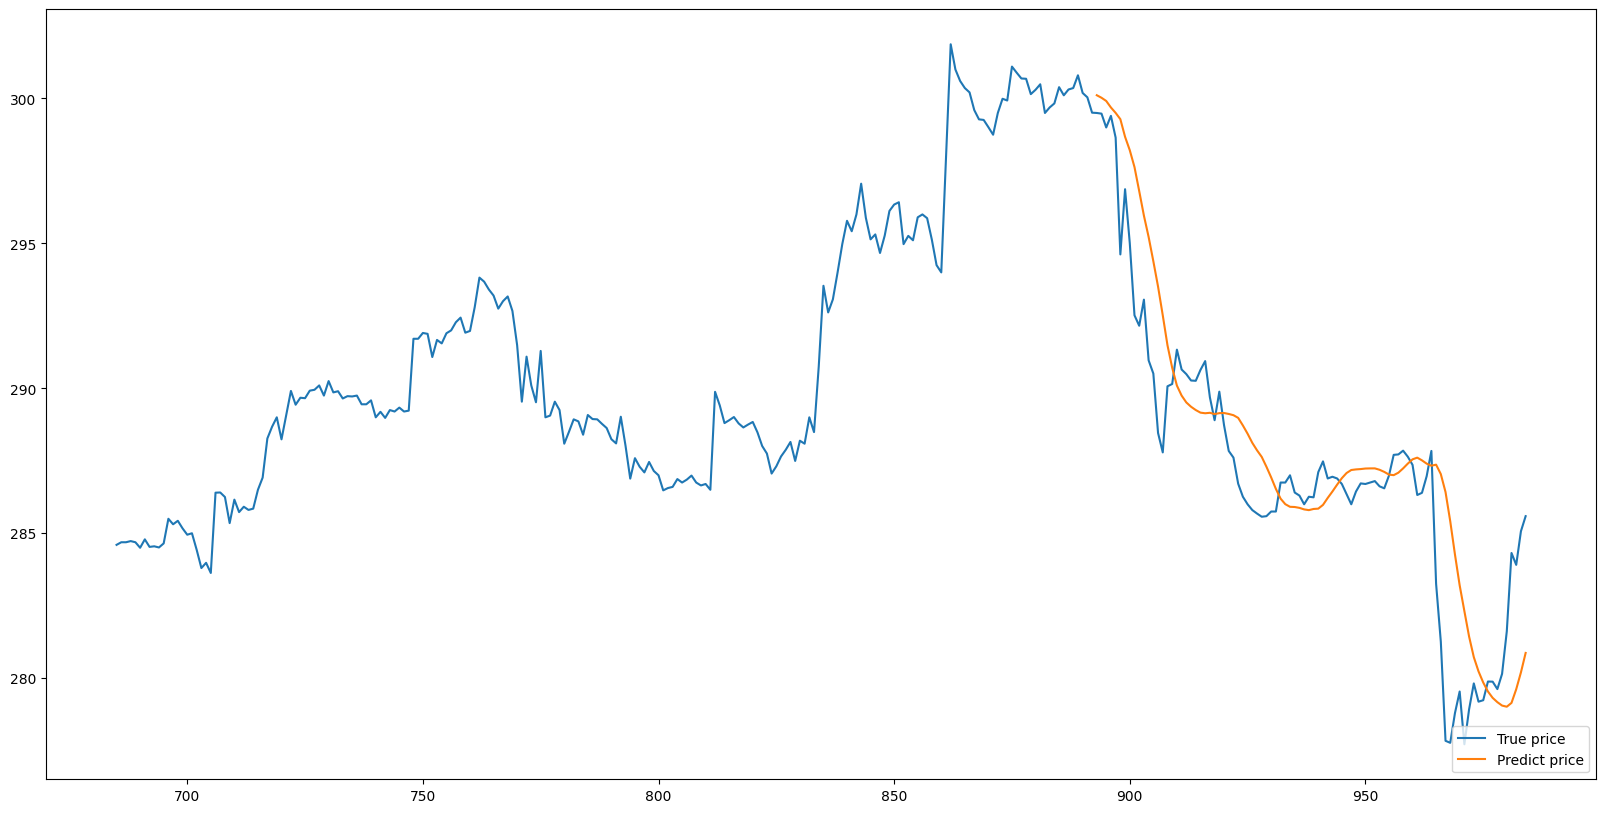

In [28]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

Epoch 1/20
24/24 [==============================] - 5s 61ms/step - loss: 0.0366 - val_loss: 0.0045
Epoch 2/20
24/24 [==============================] - 1s 34ms/step - loss: 0.0050 - val_loss: 0.0027
Epoch 3/20
24/24 [==============================] - 1s 35ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 4/20
24/24 [==============================] - 1s 33ms/step - loss: 0.0019 - val_loss: 0.0046
Epoch 5/20
24/24 [==============================] - 1s 33ms/step - loss: 0.0018 - val_loss: 0.0052
Epoch 6/20
24/24 [==============================] - 1s 32ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 7/20
24/24 [==============================] - 1s 32ms/step - loss: 0.0016 - val_loss: 0.0038
Epoch 8/20
24/24 [==============================] - 1s 31ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 9/20
24/24 [==============================] - 1s 31ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 10/20
24/24 [==============================] - 1s 31ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 11/

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 11ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\2478985766.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


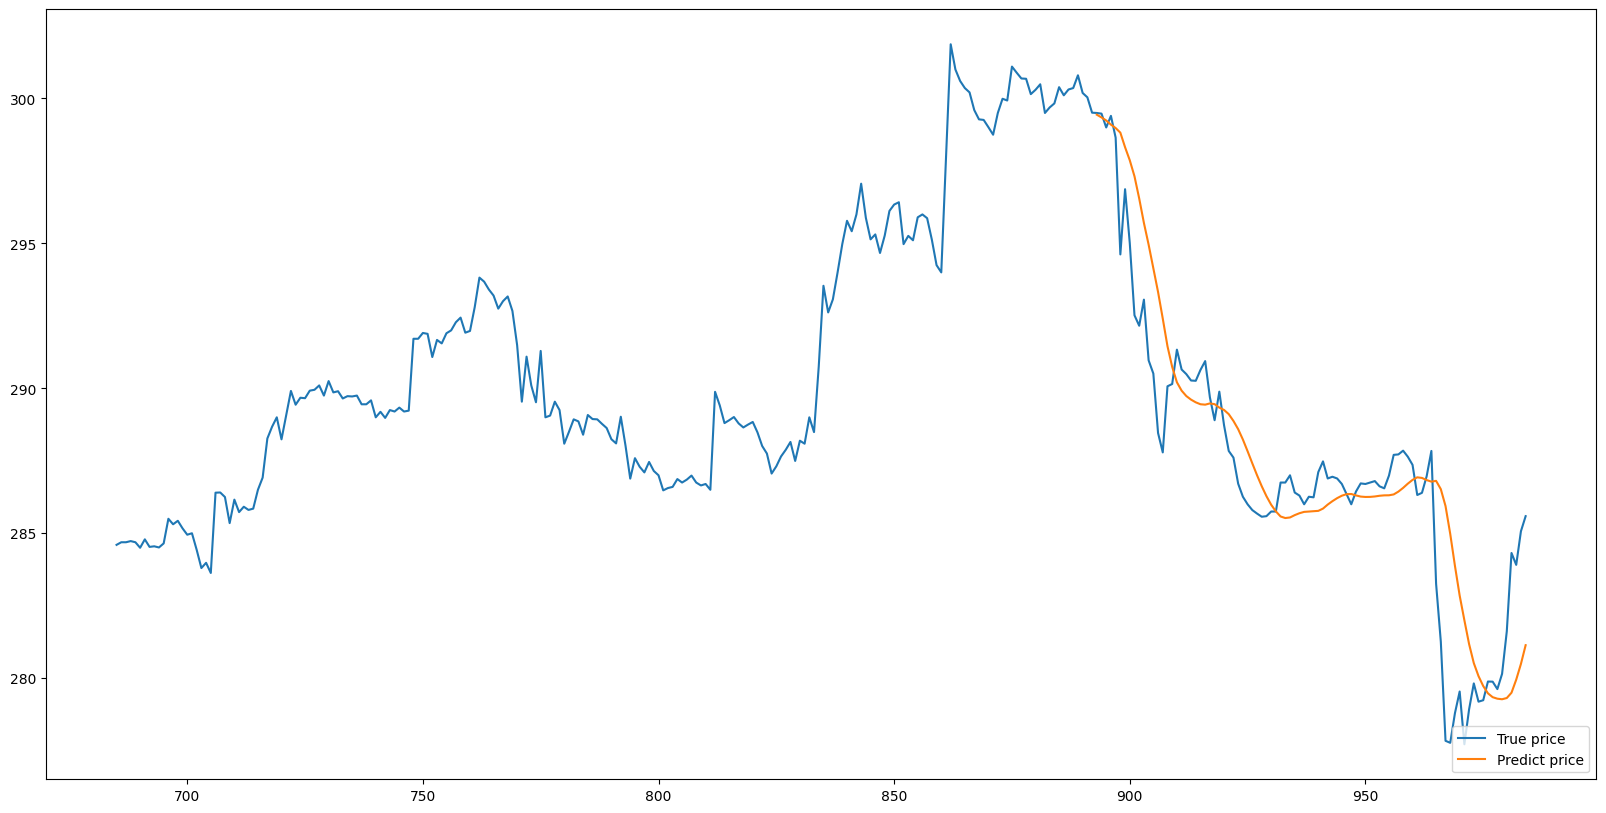

In [29]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

Epoch 1/20
24/24 [==============================] - 5s 62ms/step - loss: 0.0856 - val_loss: 0.0032
Epoch 2/20
24/24 [==============================] - 1s 32ms/step - loss: 0.0070 - val_loss: 0.0030
Epoch 3/20
24/24 [==============================] - 1s 34ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 4/20
24/24 [==============================] - 1s 34ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 5/20
24/24 [==============================] - 1s 32ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 6/20
24/24 [==============================] - 1s 32ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 7/20
24/24 [==============================] - 1s 33ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 8/20
24/24 [==============================] - 1s 32ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 9/20
24/24 [==============================] - 1s 31ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 10/20
24/24 [==============================] - 1s 32ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 11/

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 14ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\2854864207.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


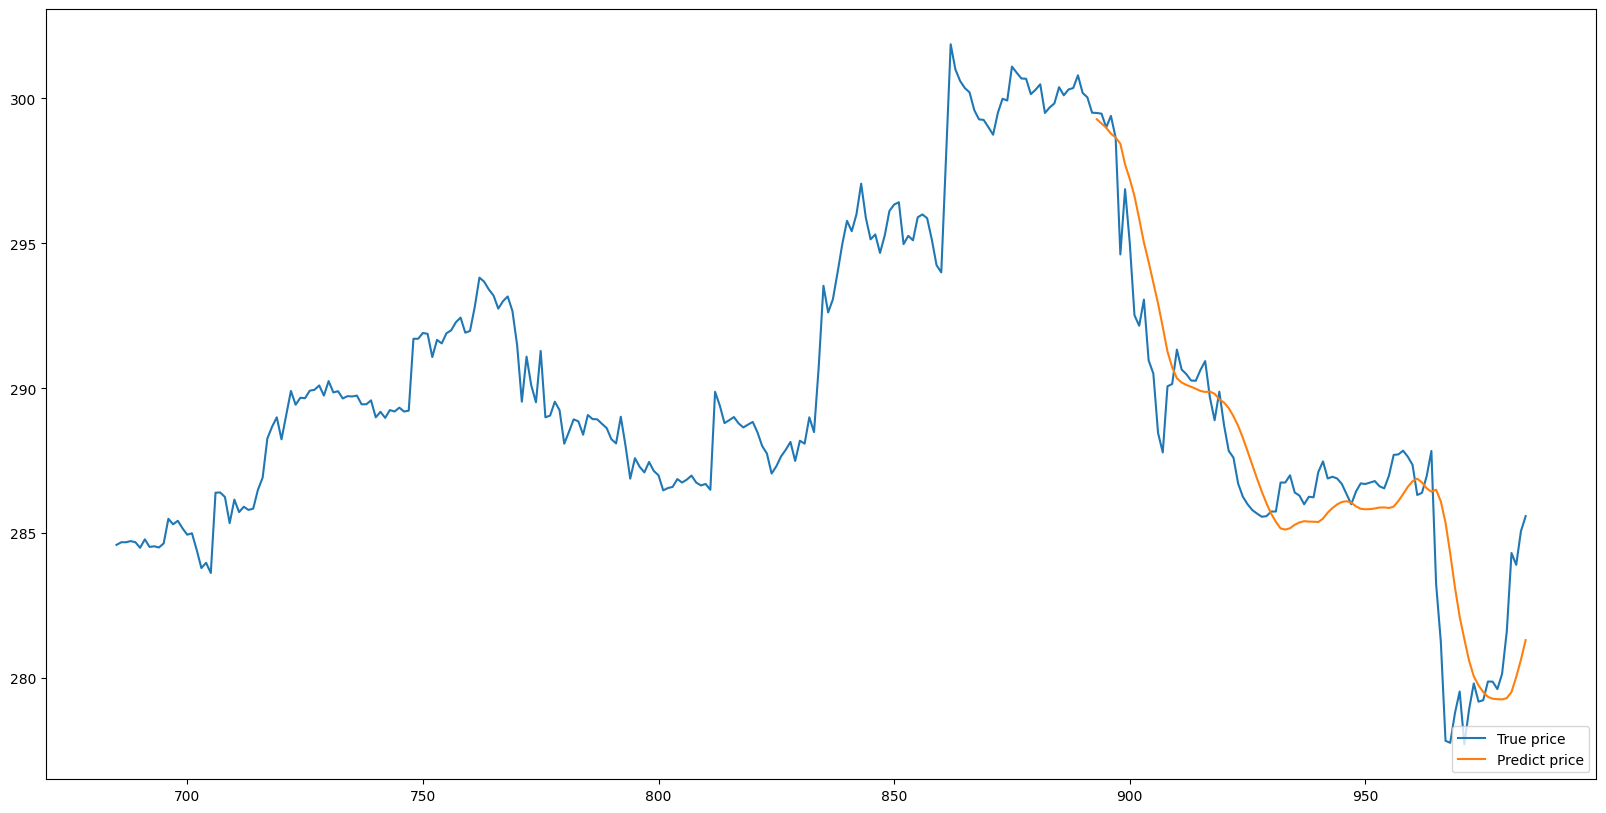

In [30]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

Epoch 1/20
24/24 [==============================] - 5s 62ms/step - loss: 0.0887 - val_loss: 0.0089
Epoch 2/20
24/24 [==============================] - 1s 34ms/step - loss: 0.0074 - val_loss: 0.0060
Epoch 3/20
24/24 [==============================] - 1s 35ms/step - loss: 0.0040 - val_loss: 0.0064
Epoch 4/20
24/24 [==============================] - 1s 35ms/step - loss: 0.0031 - val_loss: 0.0069
Epoch 5/20
24/24 [==============================] - 1s 34ms/step - loss: 0.0027 - val_loss: 0.0065
Epoch 6/20
24/24 [==============================] - 1s 34ms/step - loss: 0.0025 - val_loss: 0.0076
Epoch 7/20
24/24 [==============================] - 1s 35ms/step - loss: 0.0023 - val_loss: 0.0069
Epoch 8/20
24/24 [==============================] - 1s 34ms/step - loss: 0.0021 - val_loss: 0.0049
Epoch 9/20
24/24 [==============================] - 1s 34ms/step - loss: 0.0021 - val_loss: 0.0048
Epoch 10/20
24/24 [==============================] - 1s 34ms/step - loss: 0.0017 - val_loss: 0.0043
Epoch 11/

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 12ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\976809281.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


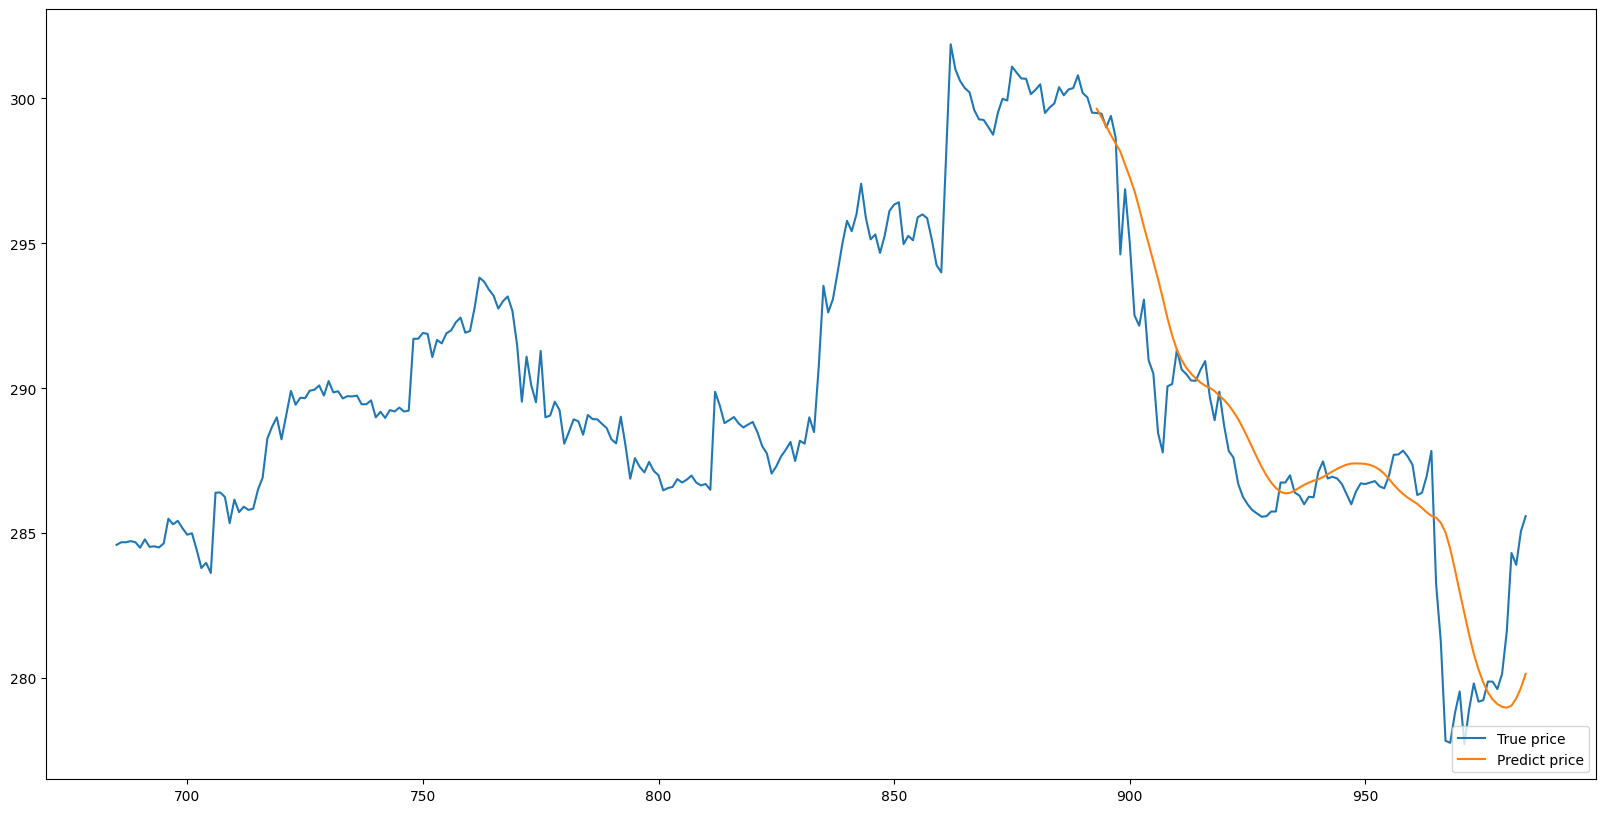

In [31]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

Epoch 1/20
24/24 [==============================] - 4s 59ms/step - loss: 0.0447 - val_loss: 0.0057
Epoch 2/20
24/24 [==============================] - 1s 32ms/step - loss: 0.0049 - val_loss: 0.0052
Epoch 3/20
24/24 [==============================] - 1s 31ms/step - loss: 0.0026 - val_loss: 0.0045
Epoch 4/20
24/24 [==============================] - 1s 32ms/step - loss: 0.0021 - val_loss: 0.0045
Epoch 5/20
24/24 [==============================] - 1s 32ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 6/20
24/24 [==============================] - 1s 31ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 7/20
24/24 [==============================] - 1s 30ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 8/20
24/24 [==============================] - 1s 32ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 9/20
24/24 [==============================] - 1s 42ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 10/20
24/24 [==============================] - 1s 33ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 11/

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 11ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\610689180.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


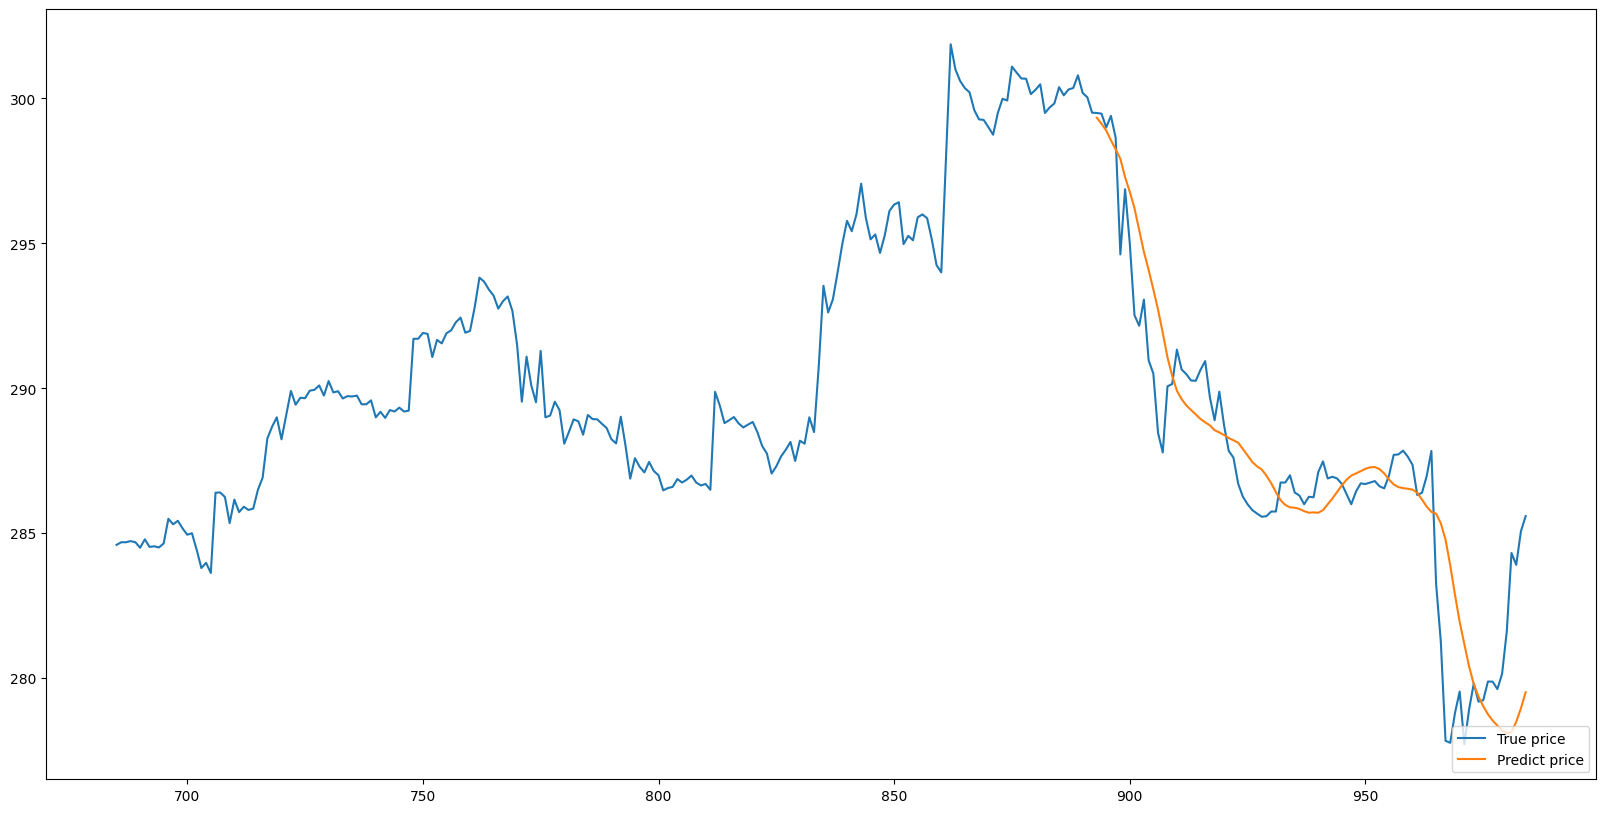

In [32]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

Epoch 1/20
24/24 [==============================] - 4s 60ms/step - loss: 0.0164 - val_loss: 0.0095
Epoch 2/20
24/24 [==============================] - 1s 32ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 3/20
24/24 [==============================] - 1s 31ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 4/20
24/24 [==============================] - 1s 32ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 5/20
24/24 [==============================] - 1s 32ms/step - loss: 9.2880e-04 - val_loss: 0.0047
Epoch 6/20
24/24 [==============================] - 1s 31ms/step - loss: 8.8304e-04 - val_loss: 0.0028
Epoch 7/20
24/24 [==============================] - 1s 33ms/step - loss: 8.6850e-04 - val_loss: 0.0055
Epoch 8/20
24/24 [==============================] - 1s 32ms/step - loss: 9.3286e-04 - val_loss: 0.0054
Epoch 9/20
24/24 [==============================] - 1s 31ms/step - loss: 8.7000e-04 - val_loss: 0.0034
Epoch 10/20
24/24 [==============================] - 1s 32ms/step - loss: 7.5478e-04 - va

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 13ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\3727467000.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


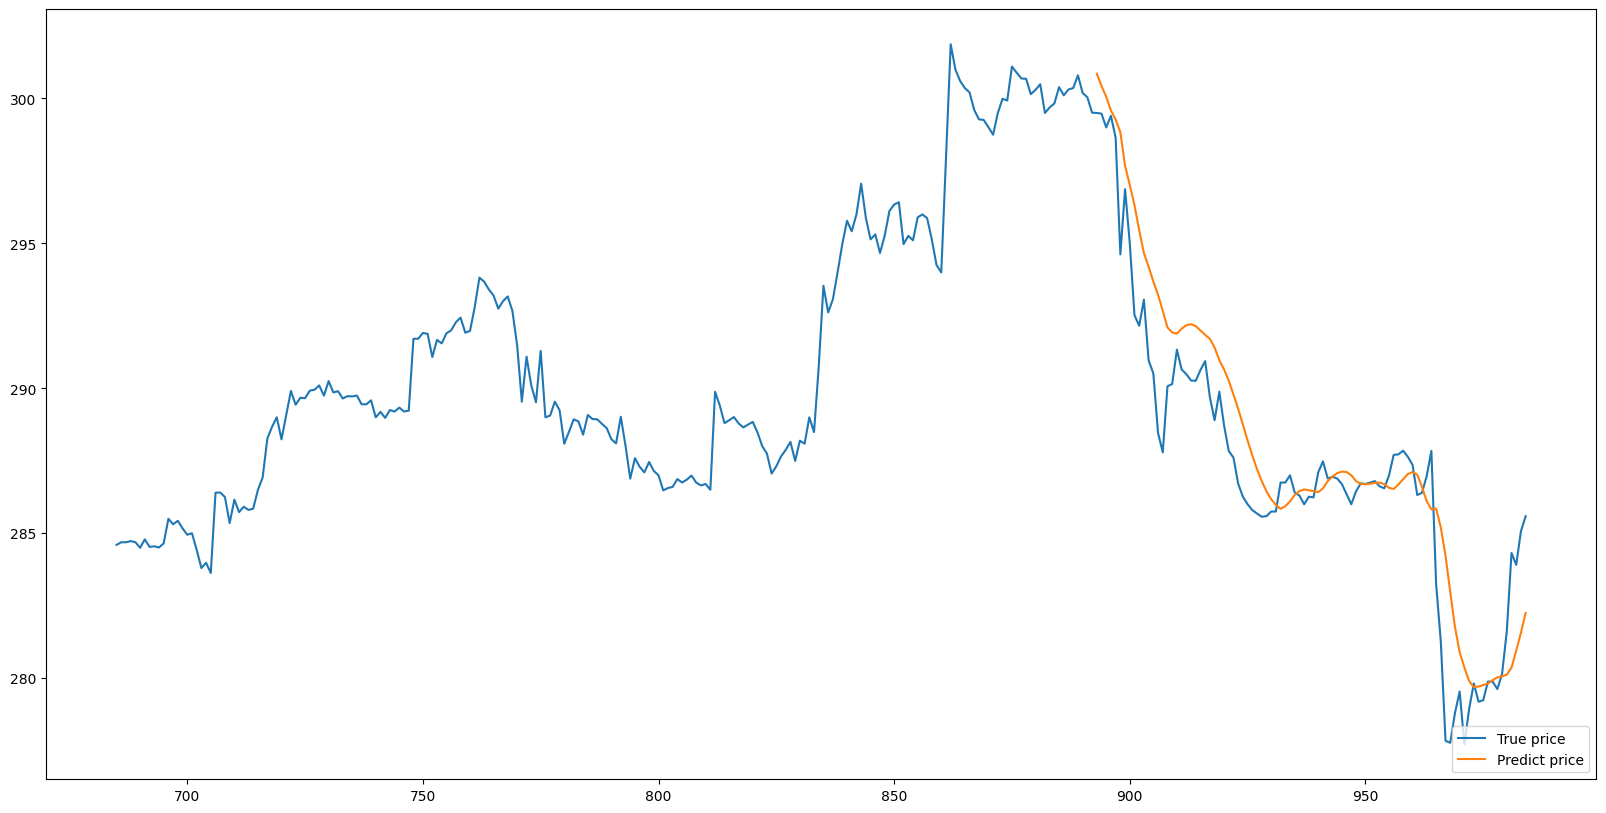

In [33]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

Epoch 1/20
24/24 [==============================] - 5s 62ms/step - loss: 0.0319 - val_loss: 0.0035
Epoch 2/20
24/24 [==============================] - 1s 35ms/step - loss: 0.0039 - val_loss: 0.0042
Epoch 3/20
24/24 [==============================] - 1s 35ms/step - loss: 0.0026 - val_loss: 0.0053
Epoch 4/20
24/24 [==============================] - 1s 36ms/step - loss: 0.0023 - val_loss: 0.0049
Epoch 5/20
24/24 [==============================] - 1s 34ms/step - loss: 0.0021 - val_loss: 0.0047
Epoch 6/20
24/24 [==============================] - 1s 34ms/step - loss: 0.0019 - val_loss: 0.0037
Epoch 7/20
24/24 [==============================] - 1s 35ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 8/20
24/24 [==============================] - 1s 35ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 9/20
24/24 [==============================] - 1s 35ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 10/20
24/24 [==============================] - 1s 34ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 11/

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 14ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\794696673.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


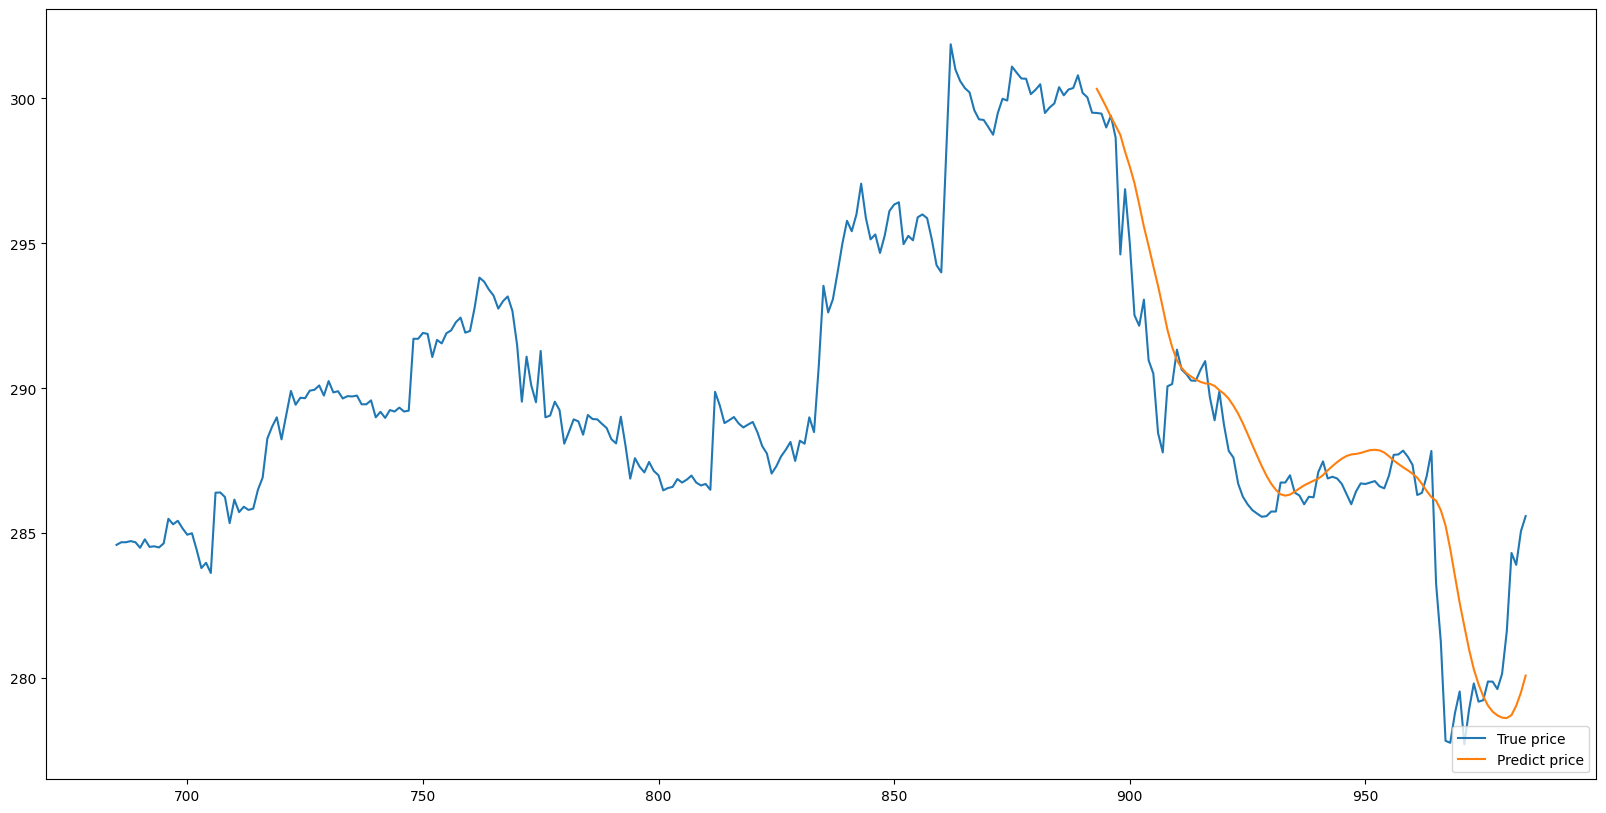

In [34]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

Epoch 1/20
24/24 [==============================] - 4s 61ms/step - loss: 0.0326 - val_loss: 0.0035
Epoch 2/20
24/24 [==============================] - 1s 33ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 3/20
24/24 [==============================] - 1s 33ms/step - loss: 0.0014 - val_loss: 0.0037
Epoch 4/20
24/24 [==============================] - 1s 33ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 5/20
24/24 [==============================] - 1s 32ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 6/20
24/24 [==============================] - 1s 32ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 7/20
24/24 [==============================] - 1s 33ms/step - loss: 9.9189e-04 - val_loss: 0.0028
Epoch 8/20
24/24 [==============================] - 1s 33ms/step - loss: 8.9814e-04 - val_loss: 0.0030
Epoch 9/20
24/24 [==============================] - 1s 32ms/step - loss: 9.0966e-04 - val_loss: 0.0022
Epoch 10/20
24/24 [==============================] - 1s 32ms/step - loss: 9.1870e-04 - val_loss: 

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 13ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\3631243799.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


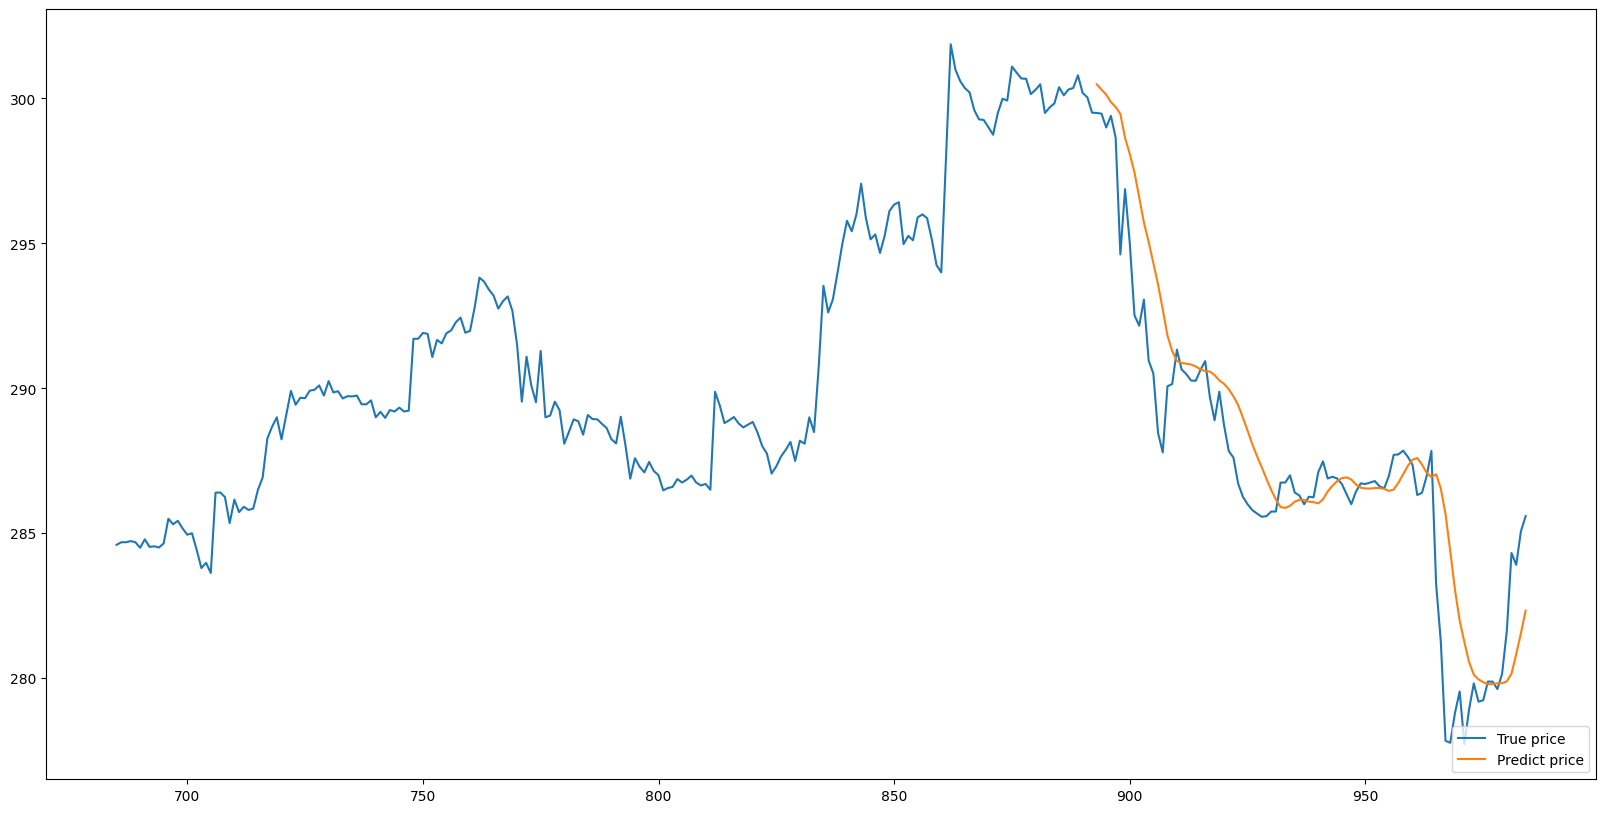

In [35]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

Epoch 1/20
24/24 [==============================] - 5s 62ms/step - loss: 0.0616 - val_loss: 0.0040
Epoch 2/20
24/24 [==============================] - 1s 35ms/step - loss: 0.0053 - val_loss: 0.0036
Epoch 3/20
24/24 [==============================] - 1s 35ms/step - loss: 0.0023 - val_loss: 0.0050
Epoch 4/20
24/24 [==============================] - 1s 35ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 5/20
24/24 [==============================] - 1s 33ms/step - loss: 0.0014 - val_loss: 0.0039
Epoch 6/20
24/24 [==============================] - 1s 34ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 7/20
24/24 [==============================] - 1s 36ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 8/20
24/24 [==============================] - 1s 35ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 9/20
24/24 [==============================] - 1s 37ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 10/20
24/24 [==============================] - 1s 37ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 11/

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 15ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\918472296.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


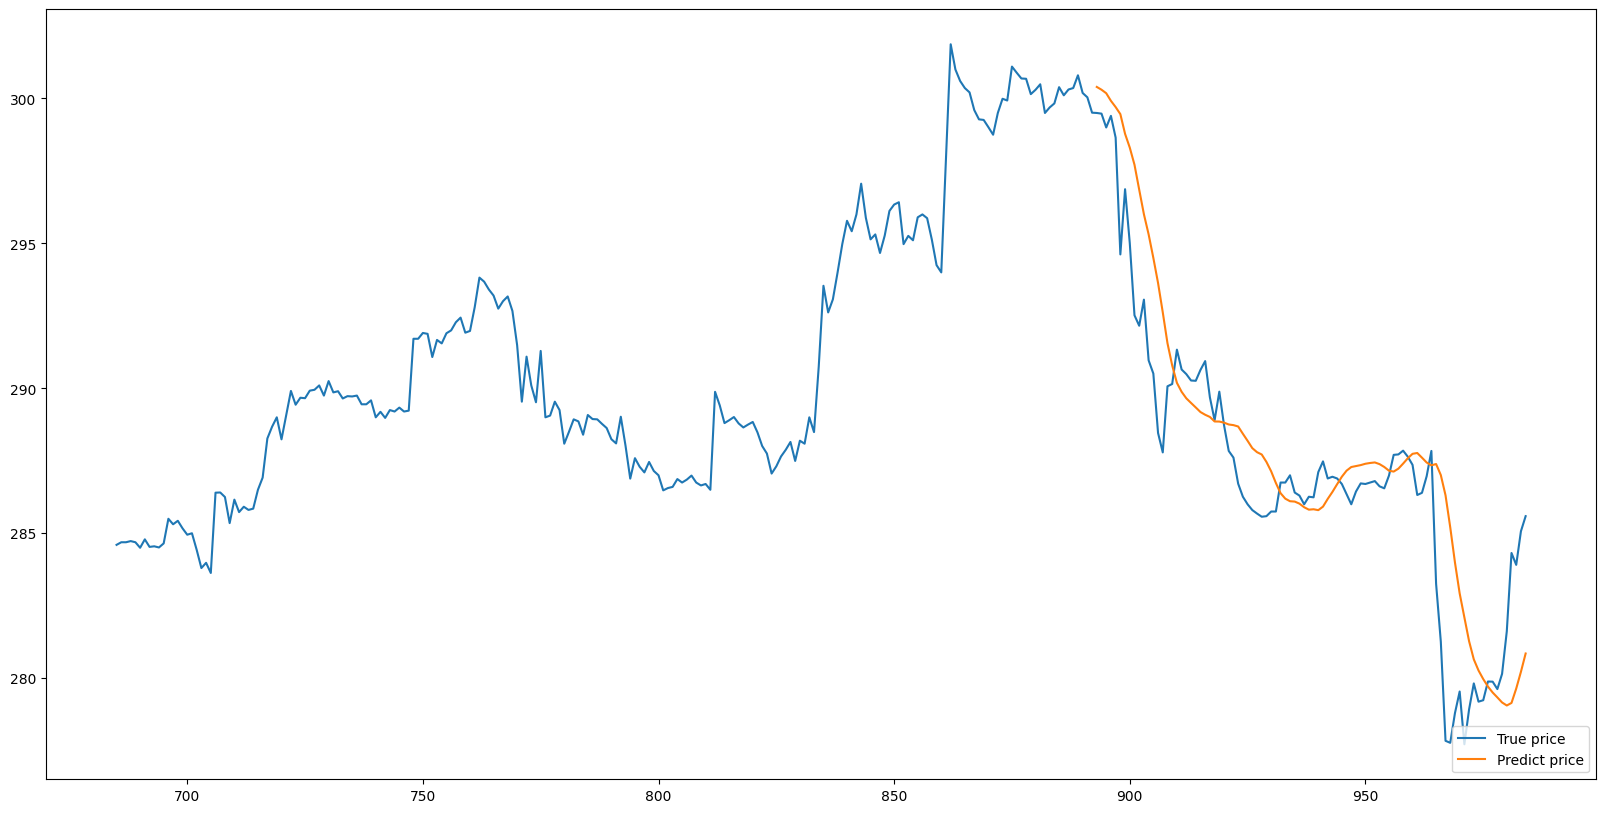

In [36]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

Epoch 1/20
24/24 [==============================] - 4s 60ms/step - loss: 0.0952 - val_loss: 0.0039
Epoch 2/20
24/24 [==============================] - 1s 33ms/step - loss: 0.0060 - val_loss: 0.0065
Epoch 3/20
24/24 [==============================] - 1s 33ms/step - loss: 0.0027 - val_loss: 0.0040
Epoch 4/20
24/24 [==============================] - 1s 32ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 5/20
24/24 [==============================] - 1s 33ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 6/20
24/24 [==============================] - 1s 32ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 7/20
24/24 [==============================] - 1s 33ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 8/20
24/24 [==============================] - 1s 34ms/step - loss: 9.7896e-04 - val_loss: 0.0024
Epoch 9/20
24/24 [==============================] - 1s 32ms/step - loss: 9.6623e-04 - val_loss: 0.0020
Epoch 10/20
24/24 [==============================] - 1s 32ms/step - loss: 9.7144e-04 - val_loss: 0.00

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 15ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\2086726756.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


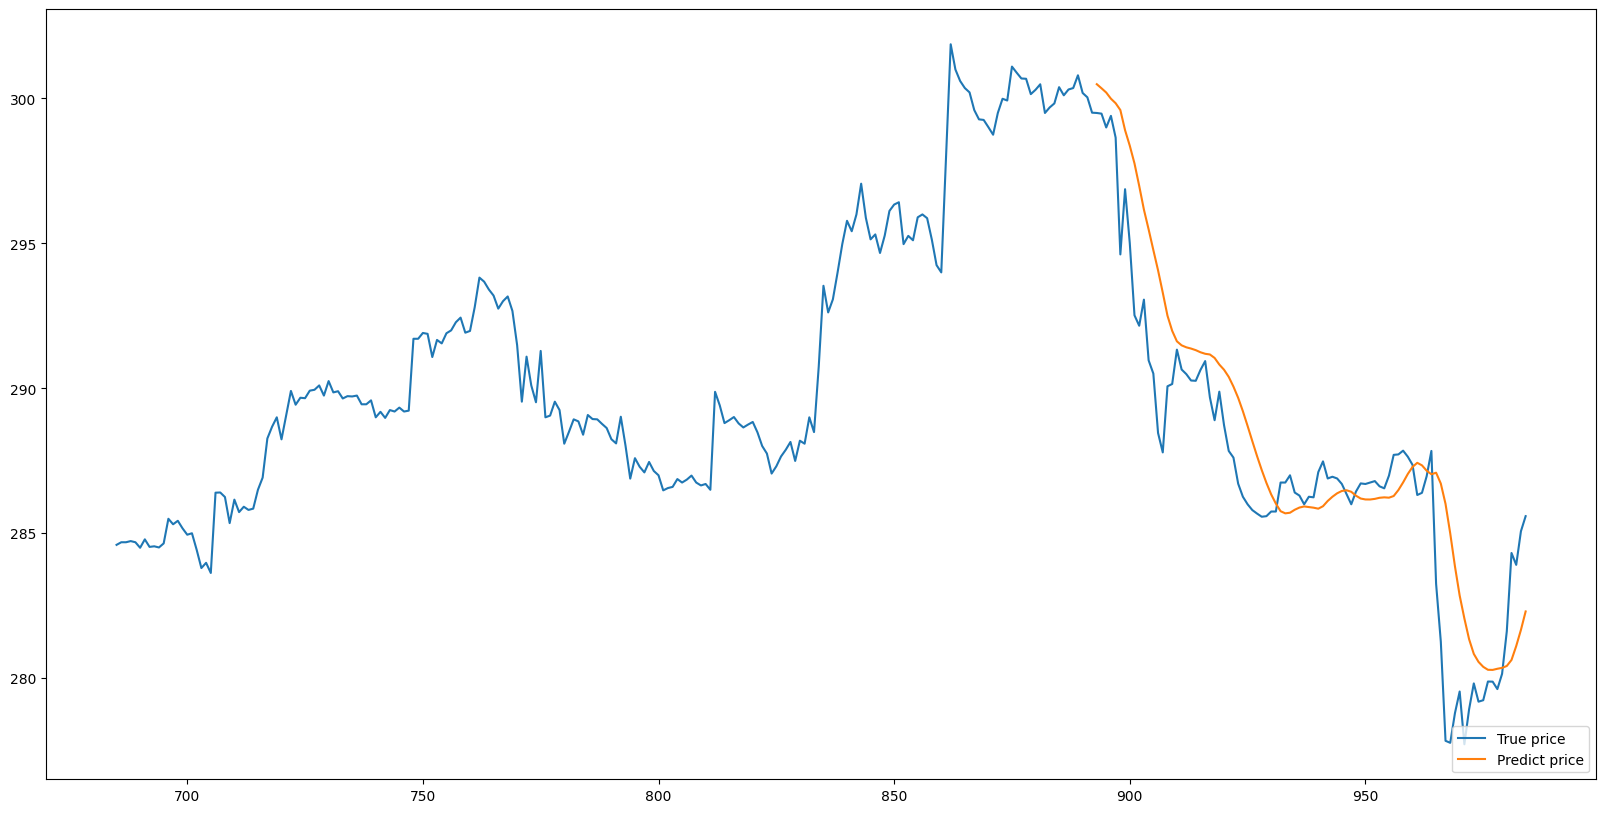

In [37]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

Epoch 1/20
24/24 [==============================] - 4s 60ms/step - loss: 0.0938 - val_loss: 0.0058
Epoch 2/20
24/24 [==============================] - 1s 33ms/step - loss: 0.0053 - val_loss: 0.0061
Epoch 3/20
24/24 [==============================] - 1s 33ms/step - loss: 0.0030 - val_loss: 0.0044
Epoch 4/20
24/24 [==============================] - 1s 33ms/step - loss: 0.0021 - val_loss: 0.0055
Epoch 5/20
24/24 [==============================] - 1s 33ms/step - loss: 0.0015 - val_loss: 0.0042
Epoch 6/20
24/24 [==============================] - 1s 33ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 7/20
24/24 [==============================] - 1s 33ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 8/20
24/24 [==============================] - 1s 33ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 9/20
24/24 [==============================] - 1s 33ms/step - loss: 0.0010 - val_loss: 0.0030
Epoch 10/20
24/24 [==============================] - 1s 34ms/step - loss: 0.0010 - val_loss: 0.0039
Epoch 11/

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 14ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\3900059495.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


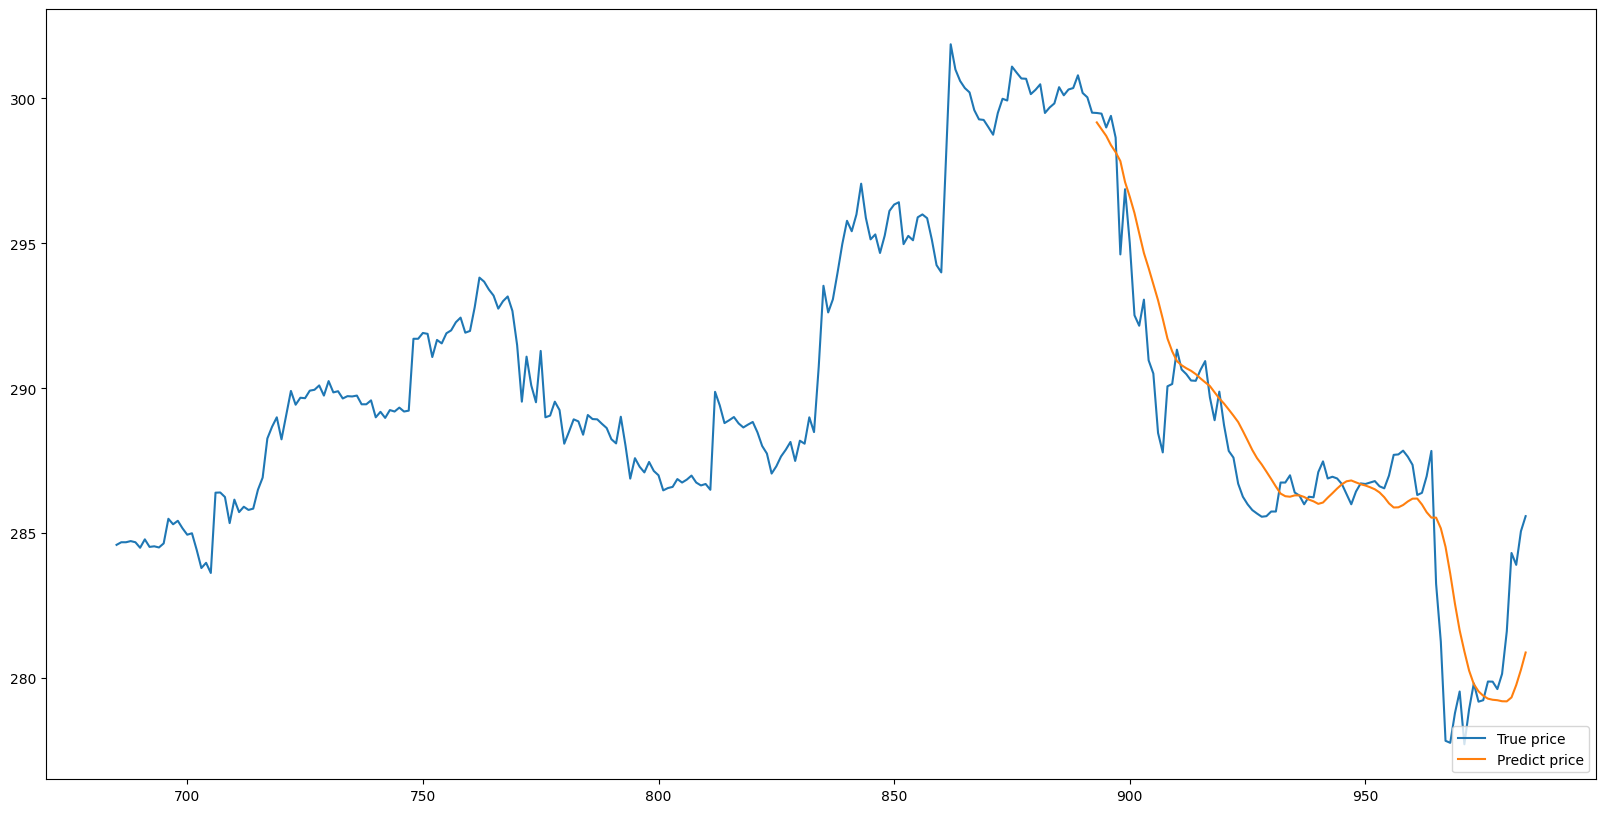

In [38]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

Epoch 1/20
24/24 [==============================] - 6s 72ms/step - loss: 0.0820 - val_loss: 0.0046
Epoch 2/20
24/24 [==============================] - 1s 43ms/step - loss: 0.0056 - val_loss: 0.0050
Epoch 3/20
24/24 [==============================] - 1s 42ms/step - loss: 0.0032 - val_loss: 0.0052
Epoch 4/20
24/24 [==============================] - 1s 37ms/step - loss: 0.0026 - val_loss: 0.0041
Epoch 5/20
24/24 [==============================] - 1s 37ms/step - loss: 0.0022 - val_loss: 0.0046
Epoch 6/20
24/24 [==============================] - 1s 35ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 7/20
24/24 [==============================] - 1s 35ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 8/20
24/24 [==============================] - 1s 38ms/step - loss: 0.0016 - val_loss: 0.0038
Epoch 9/20
24/24 [==============================] - 1s 39ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 10/20
24/24 [==============================] - 1s 40ms/step - loss: 0.0013 - val_loss: 0.0038
Epoch 11/

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 14ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1789390124.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


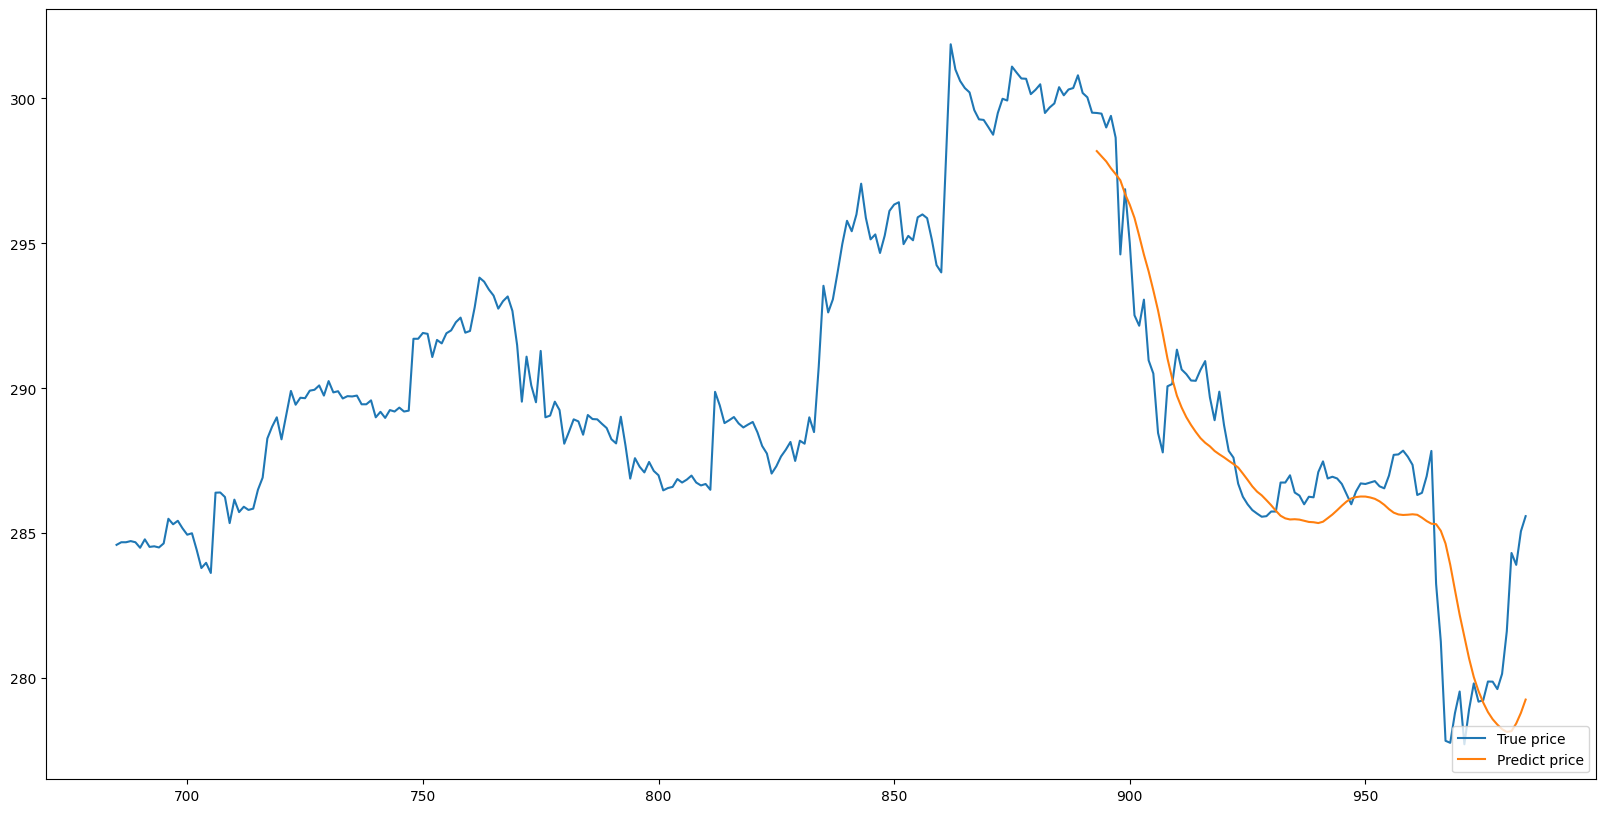

In [39]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

Epoch 1/20
24/24 [==============================] - 4s 60ms/step - loss: 0.0611 - val_loss: 0.0035
Epoch 2/20
24/24 [==============================] - 1s 35ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 3/20
24/24 [==============================] - 1s 34ms/step - loss: 0.0022 - val_loss: 0.0057
Epoch 4/20
24/24 [==============================] - 1s 34ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 5/20
24/24 [==============================] - 1s 34ms/step - loss: 0.0015 - val_loss: 0.0044
Epoch 6/20
24/24 [==============================] - 1s 34ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 7/20
24/24 [==============================] - 1s 34ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 8/20
24/24 [==============================] - 1s 34ms/step - loss: 0.0013 - val_loss: 0.0036
Epoch 9/20
24/24 [==============================] - 1s 33ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 10/20
24/24 [==============================] - 1s 33ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 11/

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 12ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\3095690293.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


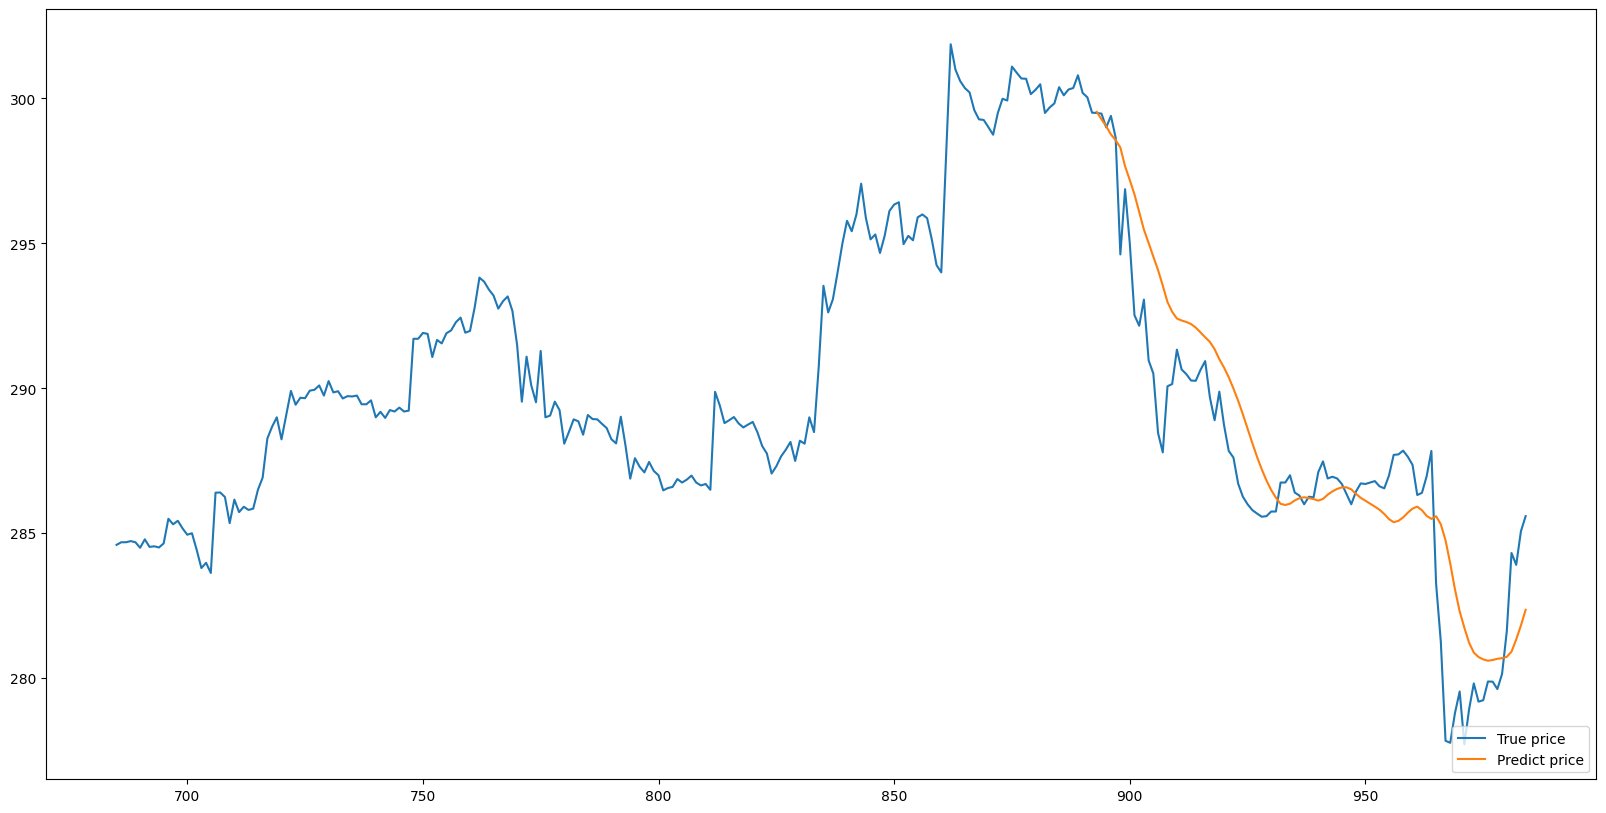

In [40]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

Epoch 1/20
24/24 [==============================] - 5s 62ms/step - loss: 0.0512 - val_loss: 0.0035
Epoch 2/20
24/24 [==============================] - 1s 37ms/step - loss: 0.0045 - val_loss: 0.0039
Epoch 3/20
24/24 [==============================] - 1s 35ms/step - loss: 0.0021 - val_loss: 0.0038
Epoch 4/20
24/24 [==============================] - 1s 36ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 5/20
24/24 [==============================] - 1s 35ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 6/20
24/24 [==============================] - 1s 35ms/step - loss: 0.0010 - val_loss: 0.0041
Epoch 7/20
24/24 [==============================] - 1s 36ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 8/20
24/24 [==============================] - 1s 35ms/step - loss: 9.8628e-04 - val_loss: 0.0031
Epoch 9/20
24/24 [==============================] - 1s 35ms/step - loss: 0.0010 - val_loss: 0.0026
Epoch 10/20
24/24 [==============================] - 1s 35ms/step - loss: 9.3449e-04 - val_loss: 0.0023
E

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 13ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\3871568780.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


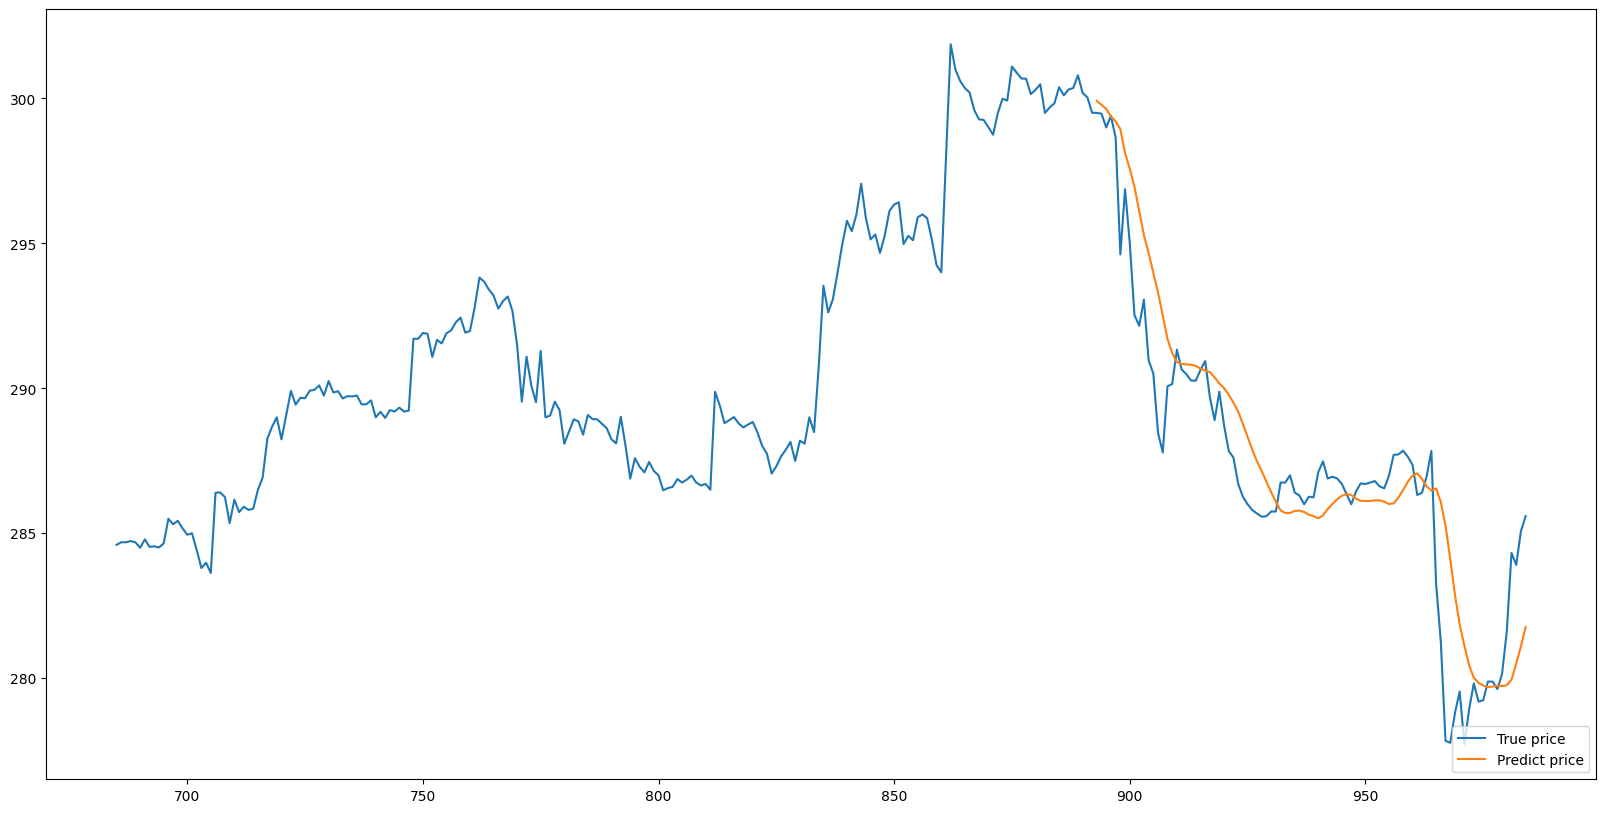

In [41]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

Epoch 1/20
24/24 [==============================] - 4s 61ms/step - loss: 0.0364 - val_loss: 0.0041
Epoch 2/20
24/24 [==============================] - 1s 34ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 3/20
24/24 [==============================] - 1s 35ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 4/20
24/24 [==============================] - 1s 34ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 5/20
24/24 [==============================] - 1s 34ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 6/20
24/24 [==============================] - 1s 34ms/step - loss: 9.8304e-04 - val_loss: 0.0024
Epoch 7/20
24/24 [==============================] - 1s 35ms/step - loss: 9.2095e-04 - val_loss: 0.0025
Epoch 8/20
24/24 [==============================] - 1s 35ms/step - loss: 8.3386e-04 - val_loss: 0.0032
Epoch 9/20
24/24 [==============================] - 1s 34ms/step - loss: 8.0880e-04 - val_loss: 0.0020
Epoch 10/20
24/24 [==============================] - 1s 33ms/step - loss: 9.6990e-04 - val_lo

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 12ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\2282918751.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


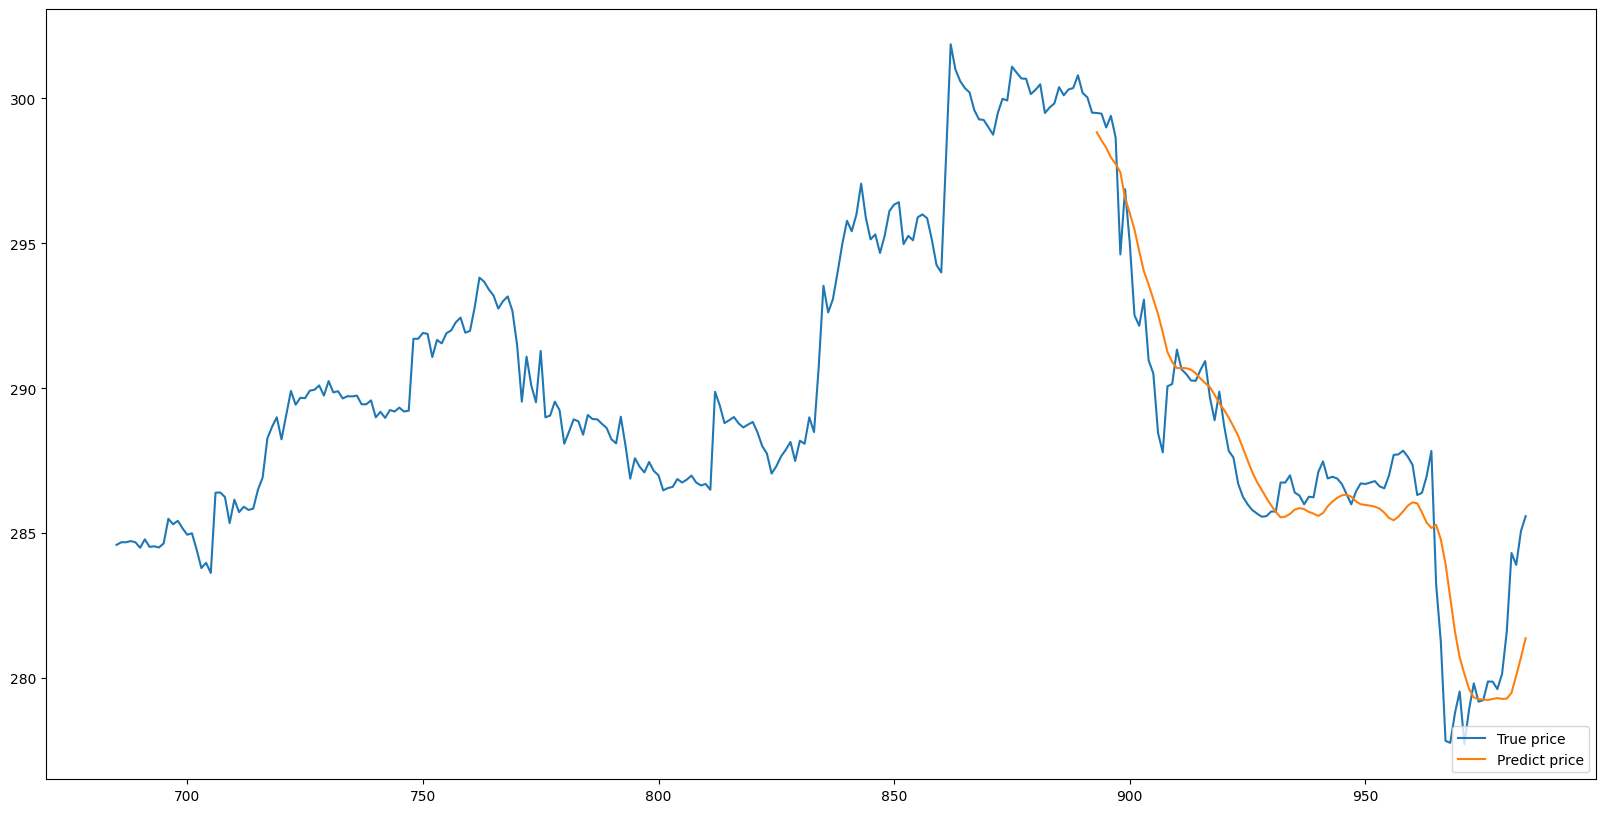

In [42]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### e. Predict Future

In [43]:
def lstm_predict_future(data, modelName, indicatorArr, period):
    modelFileName = './MODEL/' + modelName
    sorted(indicatorArr)
    for indicator in indicatorArr:
        if indicator == 'close':
            continue
        modelFileName = modelFileName + '_' + indicator
    modelFileName = modelFileName + '.h5'
    model = load_model(modelFileName)
    numDataPoint = int(period / 15)
    
    data = data[indicatorArr].values
    data = data[-60:]

    scaler = MinMaxScaler(feature_range=(0,1))
    scaledData = scaler.fit_transform(data)

    modelInput = scaledData.reshape(-1, scaledData.shape[0], scaledData.shape[1])

    predictedScaledValue = model.predict(modelInput)

    predictedValue = scaler.inverse_transform(np.tile(predictedScaledValue, (1, scaledData.shape[1])))[:, 0]
    
    return predictedValue

## 2. RNN

### a. Prepare Input

In [44]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[315.52 ],
       [314.93 ],
       [316.5  ],
       [314.055],
       [313.965],
       [313.65 ],
       [313.41 ],
       [313.785],
       [314.265],
       [314.75 ],
       [314.68 ],
       [315.1  ],
       [315.38 ],
       [315.78 ],
       [316.45 ],
       [315.44 ],
       [314.855],
       [314.11 ],
       [314.37 ],
       [313.43 ],
       [312.275],
       [311.3  ],
       [310.7  ],
       [311.395],
       [312.15 ],
       [311.68 ],
       [310.945],
       [310.73 ],
       [310.755],
       [310.9  ],
       [311.1  ],
       [310.84 ],
       [310.955],
       [310.825],
       [310.98 ],
       [311.2  ],
       [311.   ],
       [310.855],
       [310.76 ],
       [310.95 ],
       [310.82 ],
       [310.85 ],
       [310.76 ],
       [310.79 ],
       [312.65 ],
       [312.81 ],
       [312.23 ],
       [312.4  ],
       [312.44 ],
       [312.49 ],
       [312.3  ],
       [312.31 ],
       [312.02 ],
       [311.75 ],
       [311.7  ],
       [31

In [45]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.974678  ],
       [0.96031263],
       [0.99853912],
       [0.93900806],
       [0.93681673],
       [0.92914709],
       [0.92330355],
       [0.93243408],
       [0.94412116],
       [0.95592997],
       [0.95422561],
       [0.9644518 ],
       [0.97126927],
       [0.9810085 ],
       [0.99732171],
       [0.97273015],
       [0.95848652],
       [0.9403472 ],
       [0.9466777 ],
       [0.92379051],
       [0.89566848],
       [0.8719291 ],
       [0.85732025],
       [0.87424217],
       [0.89262497],
       [0.88118137],
       [0.86328553],
       [0.85805069],
       [0.85865939],
       [0.86218987],
       [0.86705948],
       [0.86072898],
       [0.86352901],
       [0.86036376],
       [0.86413771],
       [0.86949429],
       [0.86462467],
       [0.8610942 ],
       [0.85878114],
       [0.86340727],
       [0.86024202],
       [0.86097246],
       [0.85878114],
       [0.85951158],
       [0.90479901],
       [0.9086947 ],
       [0.89457281],
       [0.898

In [46]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

925
925


In [47]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (740, 60, 1)
Size validate:  (93, 60, 1)
Size test:  (92, 60, 1)


### b. Train Model

In [48]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN.h5")

Epoch 1/25
24/24 [==============================] - 8s 124ms/step - loss: 0.0675 - val_loss: 0.0055
Epoch 2/25
24/24 [==============================] - 2s 71ms/step - loss: 0.0150 - val_loss: 0.0044
Epoch 3/25
24/24 [==============================] - 2s 69ms/step - loss: 0.0085 - val_loss: 0.0088
Epoch 4/25
24/24 [==============================] - 2s 69ms/step - loss: 0.0072 - val_loss: 0.0066
Epoch 5/25
24/24 [==============================] - 2s 69ms/step - loss: 0.0074 - val_loss: 0.0090
Epoch 6/25
24/24 [==============================] - 2s 69ms/step - loss: 0.0080 - val_loss: 0.0043
Epoch 7/25
24/24 [==============================] - 2s 69ms/step - loss: 0.0073 - val_loss: 0.0112
Epoch 8/25
24/24 [==============================] - 2s 69ms/step - loss: 0.0069 - val_loss: 0.0121
Epoch 9/25
24/24 [==============================] - 2s 69ms/step - loss: 0.0076 - val_loss: 0.0046
Epoch 10/25
24/24 [==============================] - 2s 69ms/step - loss: 0.0071 - val_loss: 0.0047
Epoch 11

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### c. Test Model

In [49]:
model_rnn = load_model('./MODEL/RNN.h5')

In [50]:
predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(predictions)

3/3 [==============================] - 1s 24ms/step


In [51]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\USER\AppData\Local\Temp\ipykernel_14184\2018918845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


date    open     high      low    close    volume     ROC  \
893  2023-08-24 08:15:00  299.51  299.950  299.000  299.500   15816.0 -0.1633   
894  2023-08-24 08:30:00  299.30  299.800  294.240  299.477   20594.0 -0.1510   
895  2023-08-24 08:45:00  299.30  301.640  298.590  299.000   21160.0 -0.6974   
896  2023-08-24 09:00:00  299.00  299.500  292.540  299.400   26129.0 -0.4952   
897  2023-08-24 09:15:00  299.38  299.500  298.300  298.650   28398.0 -0.6784   
..                   ...     ...      ...      ...      ...       ...     ...   
980  2023-08-25 14:00:00  280.18  281.616  280.020  281.617  363166.0 -1.9985   
981  2023-08-25 14:15:00  281.65  284.330  281.335  284.320  868083.0 -0.6985   
982  2023-08-25 14:30:00  284.33  285.300  283.710  283.910  852731.0 -0.8677   
983  2023-08-25 14:45:00  283.96  285.070  283.410  285.070  381817.0 -0.6621   
984  2023-08-25 15:00:00  285.01  285.900  283.890  285.590  579807.0 -0.7817   

          SMA      RSI  Real Upper Band  Real Middle Band  Real Lower Band  \
893  300.2230  53.8008       307.793311          300.2230       292.652689   
894  300.2003  53.6581       307.345837          300.2003       293.054763   
895  300.0953  50.7207       306.971573          300.0953       293.219027   
896  300.0208  52.9922       306.086323          300.0208       293.955277   
897  299.9188  48.5732       305.553164          299.9188       294.284436   
..        ...      ...              ...               ...              ...   
980  281.1018  44.7020       283.550959          281.1018       278.652641   
981  281.0018  53.4391       282.805418          281.0018       279.198182   
982  280.8776  52.1242       282.544106          280.8776       279.211094   
983  280.7825  55.3931       282.427650          280.7825       279.137350   
984  280.6700  56.7854       282.305539          280.6700       279.034461   

     predictions  
893   299.765350  
894   299.755035  
895   299.733948  
896   299.698486  
897   299.648804  
..           ...  
980   280.089935  
981   279.794159  
982   279.598816  
983   279.514069  
984   279.545990  

[92 rows x 13 columns]

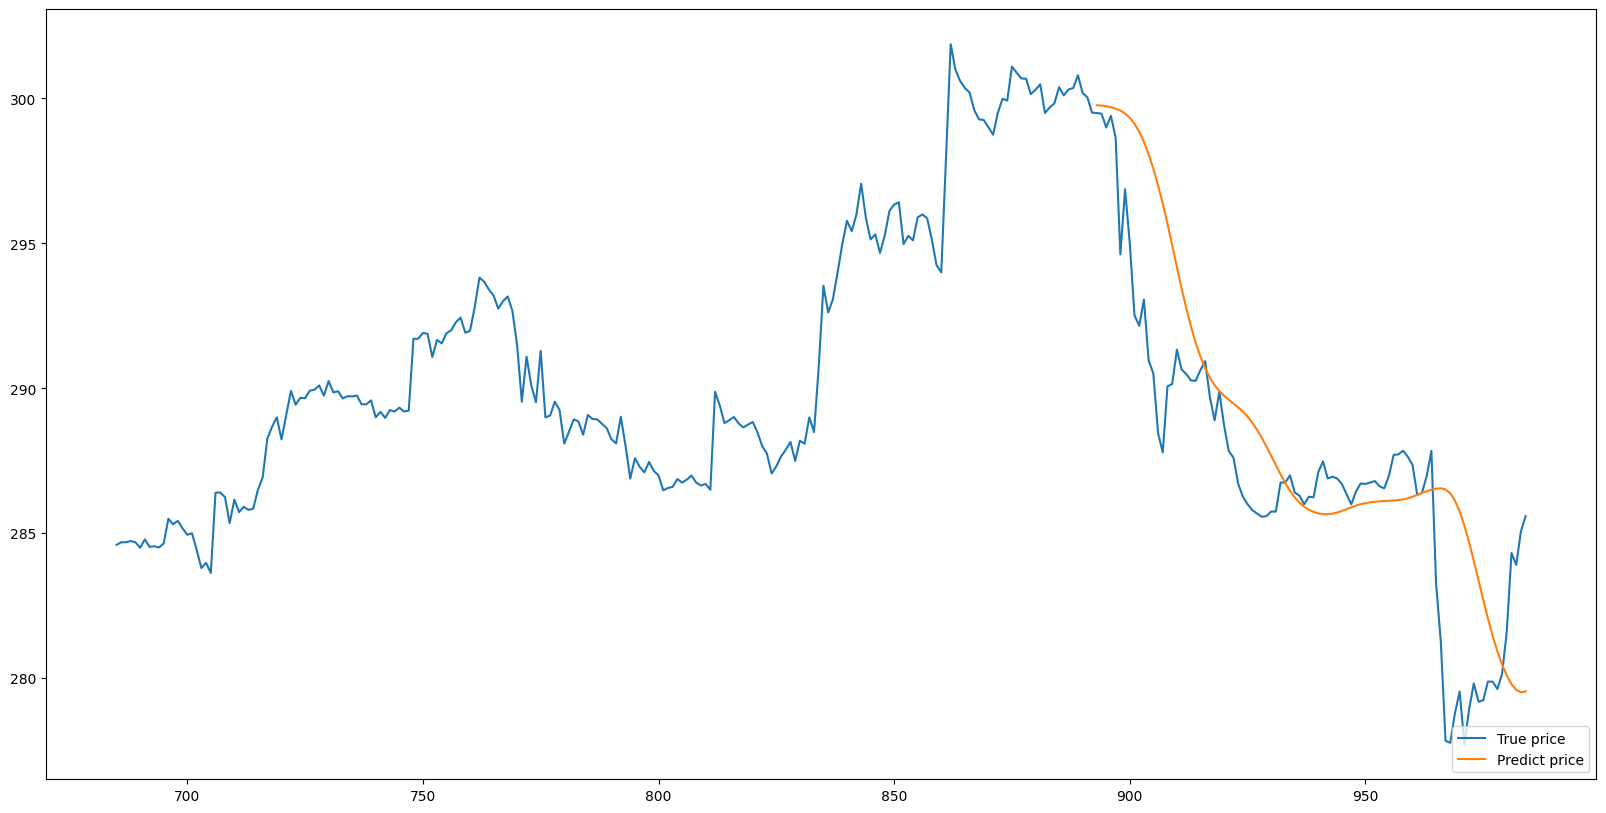

In [52]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [53]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset

array([[ 3.1552e+02, -8.2300e-02],
       [ 3.1493e+02, -1.2050e-01],
       [ 3.1650e+02,  4.3790e-01],
       ...,
       [ 2.8391e+02, -8.6770e-01],
       [ 2.8507e+02, -6.6210e-01],
       [ 2.8559e+02, -7.8170e-01]])

In [54]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.974678  , 0.55192858],
       [0.96031263, 0.54676949],
       [0.99853912, 0.62218411],
       ...,
       [0.20503518, 0.44585652],
       [0.23327896, 0.47362379],
       [0.24593996, 0.45747123]])

In [55]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

925
925


In [56]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (740, 60, 2)
Size validate:  (93, 60, 2)
Size test:  (92, 60, 2)


In [57]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],2)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC.h5")

Epoch 1/25
24/24 [==============================] - 9s 126ms/step - loss: 0.0722 - val_loss: 0.0054
Epoch 2/25
24/24 [==============================] - 2s 74ms/step - loss: 0.0110 - val_loss: 0.0102
Epoch 3/25
24/24 [==============================] - 2s 78ms/step - loss: 0.0075 - val_loss: 0.0066
Epoch 4/25
24/24 [==============================] - 2s 79ms/step - loss: 0.0071 - val_loss: 0.0065
Epoch 5/25
24/24 [==============================] - 2s 77ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 6/25
24/24 [==============================] - 2s 73ms/step - loss: 0.0073 - val_loss: 0.0047
Epoch 7/25
24/24 [==============================] - 2s 70ms/step - loss: 0.0060 - val_loss: 0.0065
Epoch 8/25
24/24 [==============================] - 2s 69ms/step - loss: 0.0064 - val_loss: 0.0029
Epoch 9/25
24/24 [==============================] - 2s 70ms/step - loss: 0.0064 - val_loss: 0.0045
Epoch 10/25
24/24 [==============================] - 2s 70ms/step - loss: 0.0060 - val_loss: 0.0036
Epoch 11

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [58]:
model_rnn = load_model('./MODEL/RNN_ROC.h5')

In [59]:
predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, 2)))[:, 0]

3/3 [==============================] - 1s 26ms/step


In [60]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\USER\AppData\Local\Temp\ipykernel_14184\2018918845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


date    open     high      low    close    volume     ROC  \
893  2023-08-24 08:15:00  299.51  299.950  299.000  299.500   15816.0 -0.1633   
894  2023-08-24 08:30:00  299.30  299.800  294.240  299.477   20594.0 -0.1510   
895  2023-08-24 08:45:00  299.30  301.640  298.590  299.000   21160.0 -0.6974   
896  2023-08-24 09:00:00  299.00  299.500  292.540  299.400   26129.0 -0.4952   
897  2023-08-24 09:15:00  299.38  299.500  298.300  298.650   28398.0 -0.6784   
..                   ...     ...      ...      ...      ...       ...     ...   
980  2023-08-25 14:00:00  280.18  281.616  280.020  281.617  363166.0 -1.9985   
981  2023-08-25 14:15:00  281.65  284.330  281.335  284.320  868083.0 -0.6985   
982  2023-08-25 14:30:00  284.33  285.300  283.710  283.910  852731.0 -0.8677   
983  2023-08-25 14:45:00  283.96  285.070  283.410  285.070  381817.0 -0.6621   
984  2023-08-25 15:00:00  285.01  285.900  283.890  285.590  579807.0 -0.7817   

          SMA      RSI  Real Upper Band  Real Middle Band  Real Lower Band  \
893  300.2230  53.8008       307.793311          300.2230       292.652689   
894  300.2003  53.6581       307.345837          300.2003       293.054763   
895  300.0953  50.7207       306.971573          300.0953       293.219027   
896  300.0208  52.9922       306.086323          300.0208       293.955277   
897  299.9188  48.5732       305.553164          299.9188       294.284436   
..        ...      ...              ...               ...              ...   
980  281.1018  44.7020       283.550959          281.1018       278.652641   
981  281.0018  53.4391       282.805418          281.0018       279.198182   
982  280.8776  52.1242       282.544106          280.8776       279.211094   
983  280.7825  55.3931       282.427650          280.7825       279.137350   
984  280.6700  56.7854       282.305539          280.6700       279.034461   

     predictions  
893   298.917694  
894   298.901917  
895   298.881195  
896   298.842926  
897   298.783905  
..           ...  
980   279.452118  
981   279.091034  
982   278.841187  
983   278.721100  
984   278.737640  

[92 rows x 13 columns]

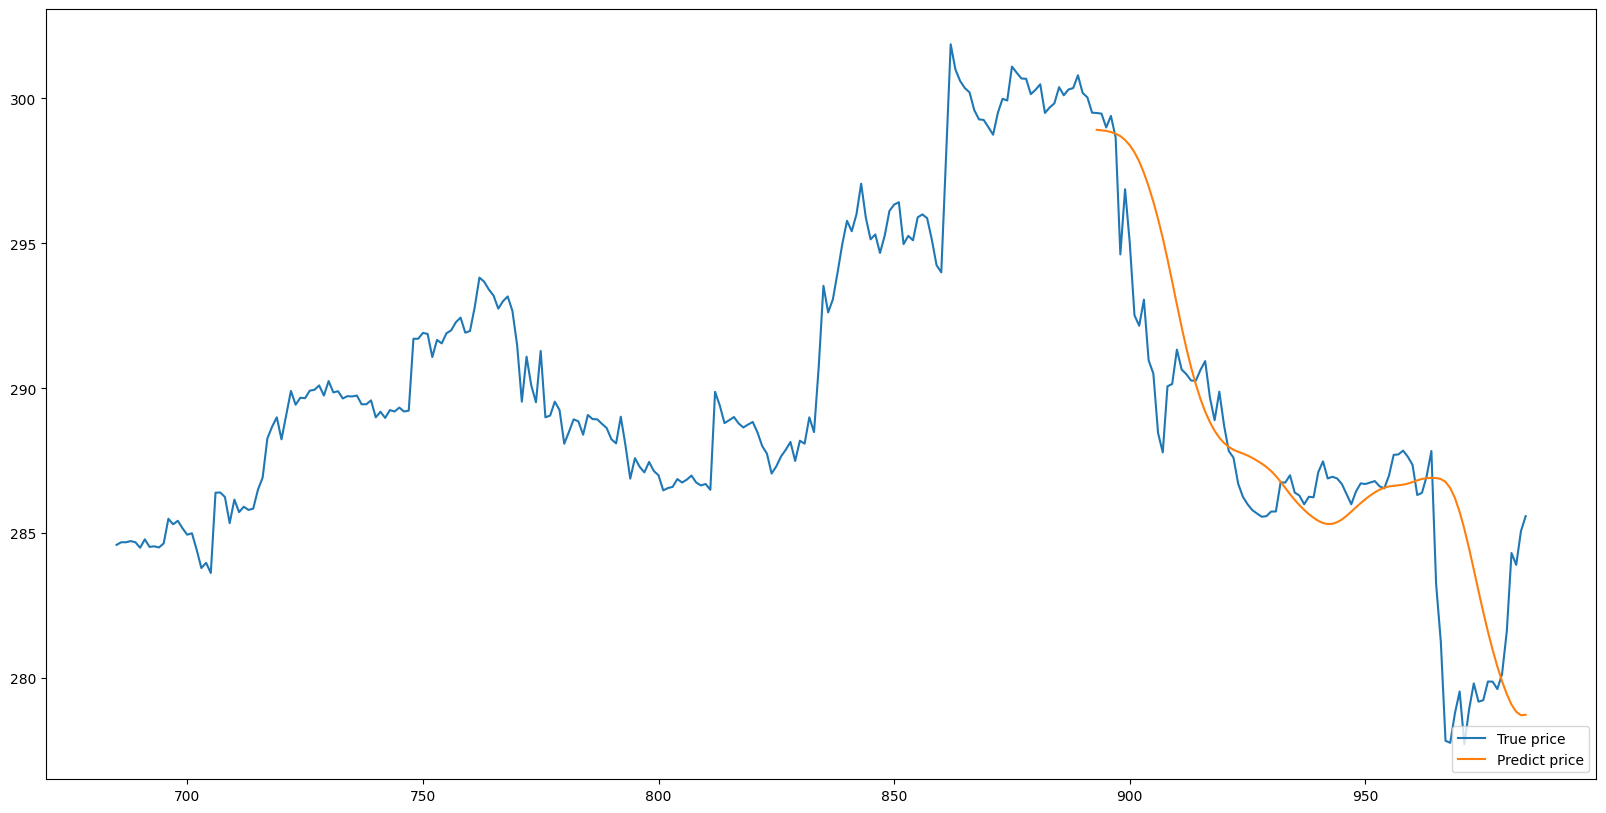

In [61]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

Epoch 1/25
24/24 [==============================] - 9s 138ms/step - loss: 0.0728 - val_loss: 0.0089
Epoch 2/25
24/24 [==============================] - 2s 76ms/step - loss: 0.0138 - val_loss: 0.0117
Epoch 3/25
24/24 [==============================] - 2s 75ms/step - loss: 0.0092 - val_loss: 0.0102
Epoch 4/25
24/24 [==============================] - 2s 70ms/step - loss: 0.0078 - val_loss: 0.0083
Epoch 5/25
24/24 [==============================] - 2s 70ms/step - loss: 0.0080 - val_loss: 0.0048
Epoch 6/25
24/24 [==============================] - 2s 78ms/step - loss: 0.0078 - val_loss: 0.0138
Epoch 7/25
24/24 [==============================] - 2s 75ms/step - loss: 0.0075 - val_loss: 0.0041
Epoch 8/25
24/24 [==============================] - 2s 78ms/step - loss: 0.0061 - val_loss: 0.0042
Epoch 9/25
24/24 [==============================] - 2s 78ms/step - loss: 0.0058 - val_loss: 0.0075
Epoch 10/25
24/24 [==============================] - 2s 72ms/step - loss: 0.0064 - val_loss: 0.0051
Epoch 11

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 25ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\4003201351.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


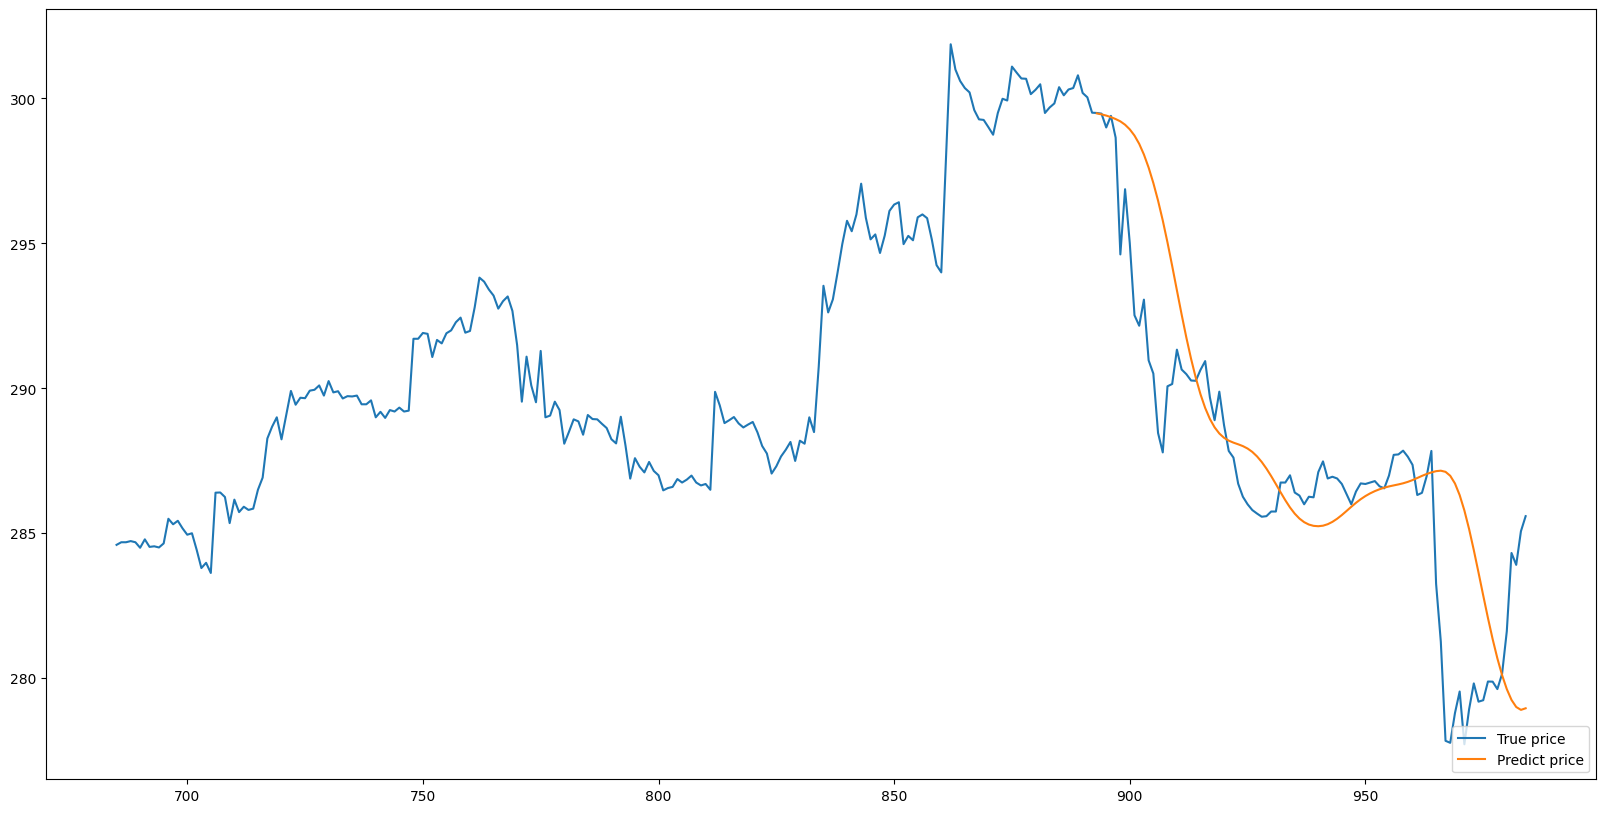

In [62]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_SMA.h5")

model_rnn = load_model('./MODEL/RNN_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

Epoch 1/25
24/24 [==============================] - 9s 129ms/step - loss: 0.0938 - val_loss: 0.0113
Epoch 2/25
24/24 [==============================] - 2s 73ms/step - loss: 0.0141 - val_loss: 0.0063
Epoch 3/25
24/24 [==============================] - 2s 70ms/step - loss: 0.0080 - val_loss: 0.0074
Epoch 4/25
24/24 [==============================] - 2s 66ms/step - loss: 0.0068 - val_loss: 0.0058
Epoch 5/25
24/24 [==============================] - 2s 66ms/step - loss: 0.0067 - val_loss: 0.0045
Epoch 6/25
24/24 [==============================] - 2s 69ms/step - loss: 0.0070 - val_loss: 0.0045
Epoch 7/25
24/24 [==============================] - 2s 66ms/step - loss: 0.0066 - val_loss: 0.0034
Epoch 8/25
24/24 [==============================] - 2s 64ms/step - loss: 0.0076 - val_loss: 0.0080
Epoch 9/25
24/24 [==============================] - 2s 70ms/step - loss: 0.0074 - val_loss: 0.0035
Epoch 10/25
24/24 [==============================] - 2s 68ms/step - loss: 0.0065 - val_loss: 0.0052
Epoch 11

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 2s 24ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\38367729.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


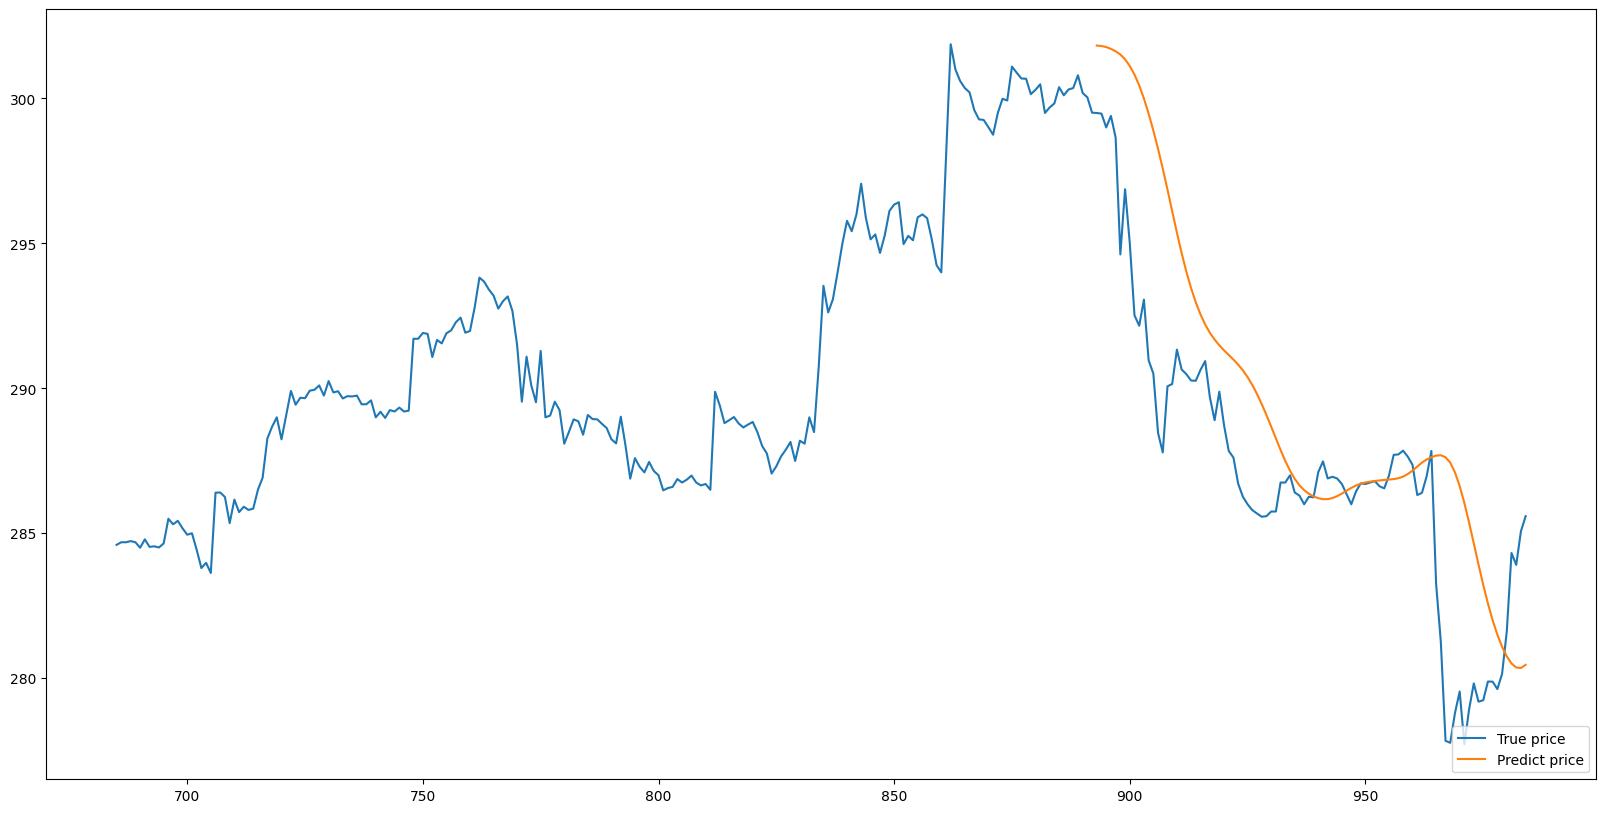

In [63]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_RSI.h5")

model_rnn = load_model('./MODEL/RNN_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

Epoch 1/25
24/24 [==============================] - 9s 130ms/step - loss: 0.0576 - val_loss: 0.0068
Epoch 2/25
24/24 [==============================] - 2s 69ms/step - loss: 0.0135 - val_loss: 0.0119
Epoch 3/25
24/24 [==============================] - 2s 72ms/step - loss: 0.0098 - val_loss: 0.0109
Epoch 4/25
24/24 [==============================] - 2s 73ms/step - loss: 0.0090 - val_loss: 0.0097
Epoch 5/25
24/24 [==============================] - 2s 70ms/step - loss: 0.0078 - val_loss: 0.0096
Epoch 6/25
24/24 [==============================] - 2s 79ms/step - loss: 0.0088 - val_loss: 0.0069
Epoch 7/25
24/24 [==============================] - 2s 77ms/step - loss: 0.0082 - val_loss: 0.0099
Epoch 8/25
24/24 [==============================] - 2s 74ms/step - loss: 0.0061 - val_loss: 0.0086
Epoch 9/25
24/24 [==============================] - 2s 71ms/step - loss: 0.0059 - val_loss: 0.0104
Epoch 10/25
24/24 [==============================] - 2s 70ms/step - loss: 0.0071 - val_loss: 0.0096
Epoch 11

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 24ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\3316815588.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


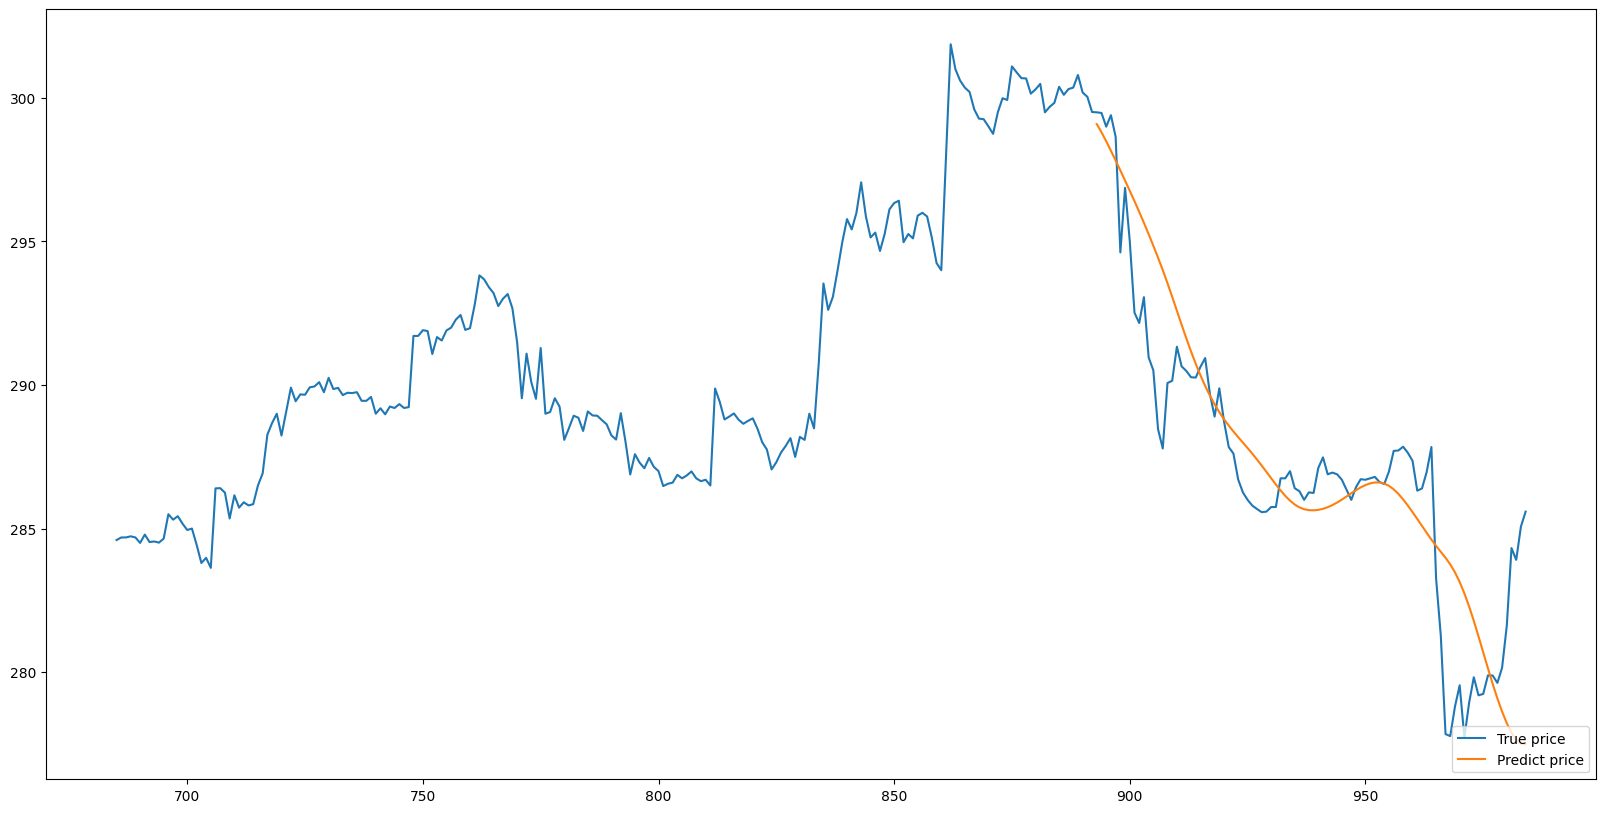

In [64]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

Epoch 1/25
24/24 [==============================] - 9s 128ms/step - loss: 0.0830 - val_loss: 0.0071
Epoch 2/25
24/24 [==============================] - 2s 73ms/step - loss: 0.0136 - val_loss: 0.0149
Epoch 3/25
24/24 [==============================] - 2s 71ms/step - loss: 0.0090 - val_loss: 0.0093
Epoch 4/25
24/24 [==============================] - 2s 79ms/step - loss: 0.0076 - val_loss: 0.0141
Epoch 5/25
24/24 [==============================] - 2s 68ms/step - loss: 0.0081 - val_loss: 0.0042
Epoch 6/25
24/24 [==============================] - 2s 70ms/step - loss: 0.0073 - val_loss: 0.0036
Epoch 7/25
24/24 [==============================] - 2s 70ms/step - loss: 0.0072 - val_loss: 0.0076
Epoch 8/25
24/24 [==============================] - 2s 73ms/step - loss: 0.0065 - val_loss: 0.0055
Epoch 9/25
24/24 [==============================] - 2s 68ms/step - loss: 0.0063 - val_loss: 0.0067
Epoch 10/25
24/24 [==============================] - 2s 71ms/step - loss: 0.0064 - val_loss: 0.0051
Epoch 11

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 22ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1497373739.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


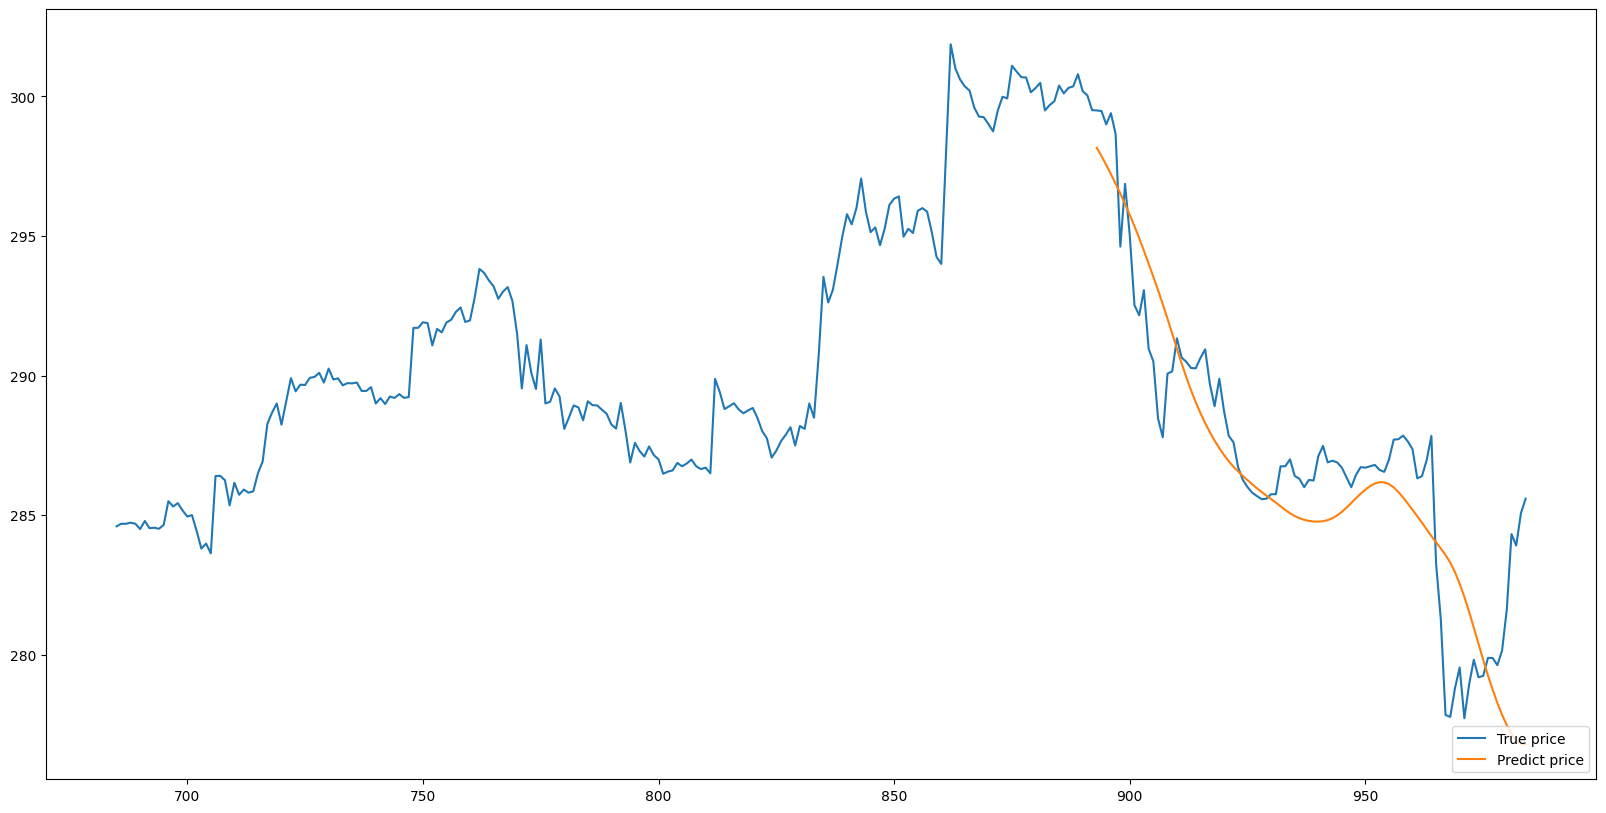

In [65]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

Epoch 1/25
24/24 [==============================] - 9s 121ms/step - loss: 0.0584 - val_loss: 0.0089
Epoch 2/25
24/24 [==============================] - 2s 67ms/step - loss: 0.0114 - val_loss: 0.0100
Epoch 3/25
24/24 [==============================] - 2s 66ms/step - loss: 0.0086 - val_loss: 0.0082
Epoch 4/25
24/24 [==============================] - 2s 77ms/step - loss: 0.0077 - val_loss: 0.0100
Epoch 5/25
24/24 [==============================] - 2s 73ms/step - loss: 0.0067 - val_loss: 0.0092
Epoch 6/25
24/24 [==============================] - 2s 78ms/step - loss: 0.0064 - val_loss: 0.0117
Epoch 7/25
24/24 [==============================] - 2s 80ms/step - loss: 0.0072 - val_loss: 0.0109
Epoch 8/25
24/24 [==============================] - 2s 75ms/step - loss: 0.0055 - val_loss: 0.0090
Epoch 9/25
24/24 [==============================] - 2s 71ms/step - loss: 0.0063 - val_loss: 0.0127
Epoch 10/25
24/24 [==============================] - 2s 70ms/step - loss: 0.0073 - val_loss: 0.0077
Epoch 11

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 23ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\3709587709.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


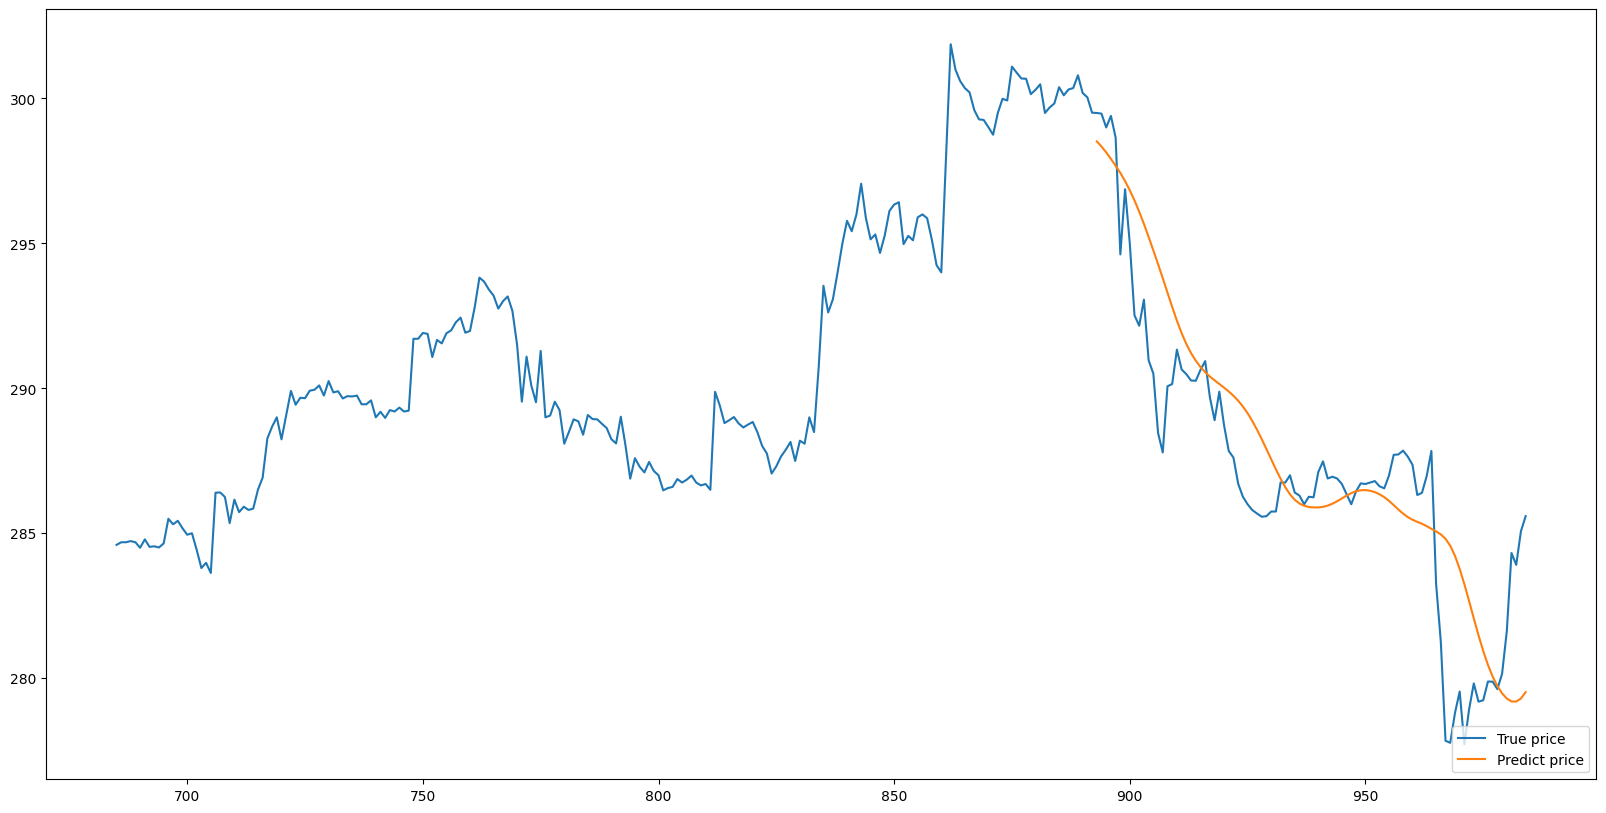

In [66]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_RSI.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

Epoch 1/25
24/24 [==============================] - 8s 117ms/step - loss: 0.0640 - val_loss: 0.0059
Epoch 2/25
24/24 [==============================] - 2s 67ms/step - loss: 0.0153 - val_loss: 0.0054
Epoch 3/25
24/24 [==============================] - 2s 66ms/step - loss: 0.0122 - val_loss: 0.0146
Epoch 4/25
24/24 [==============================] - 2s 66ms/step - loss: 0.0082 - val_loss: 0.0154
Epoch 5/25
24/24 [==============================] - 2s 64ms/step - loss: 0.0079 - val_loss: 0.0133
Epoch 6/25
24/24 [==============================] - 2s 64ms/step - loss: 0.0070 - val_loss: 0.0088
Epoch 7/25
24/24 [==============================] - 2s 65ms/step - loss: 0.0074 - val_loss: 0.0083
Epoch 8/25
24/24 [==============================] - 2s 65ms/step - loss: 0.0069 - val_loss: 0.0154
Epoch 9/25
24/24 [==============================] - 2s 65ms/step - loss: 0.0068 - val_loss: 0.0129
Epoch 10/25
24/24 [==============================] - 2s 69ms/step - loss: 0.0072 - val_loss: 0.0078
Epoch 11

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 24ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\3706970121.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


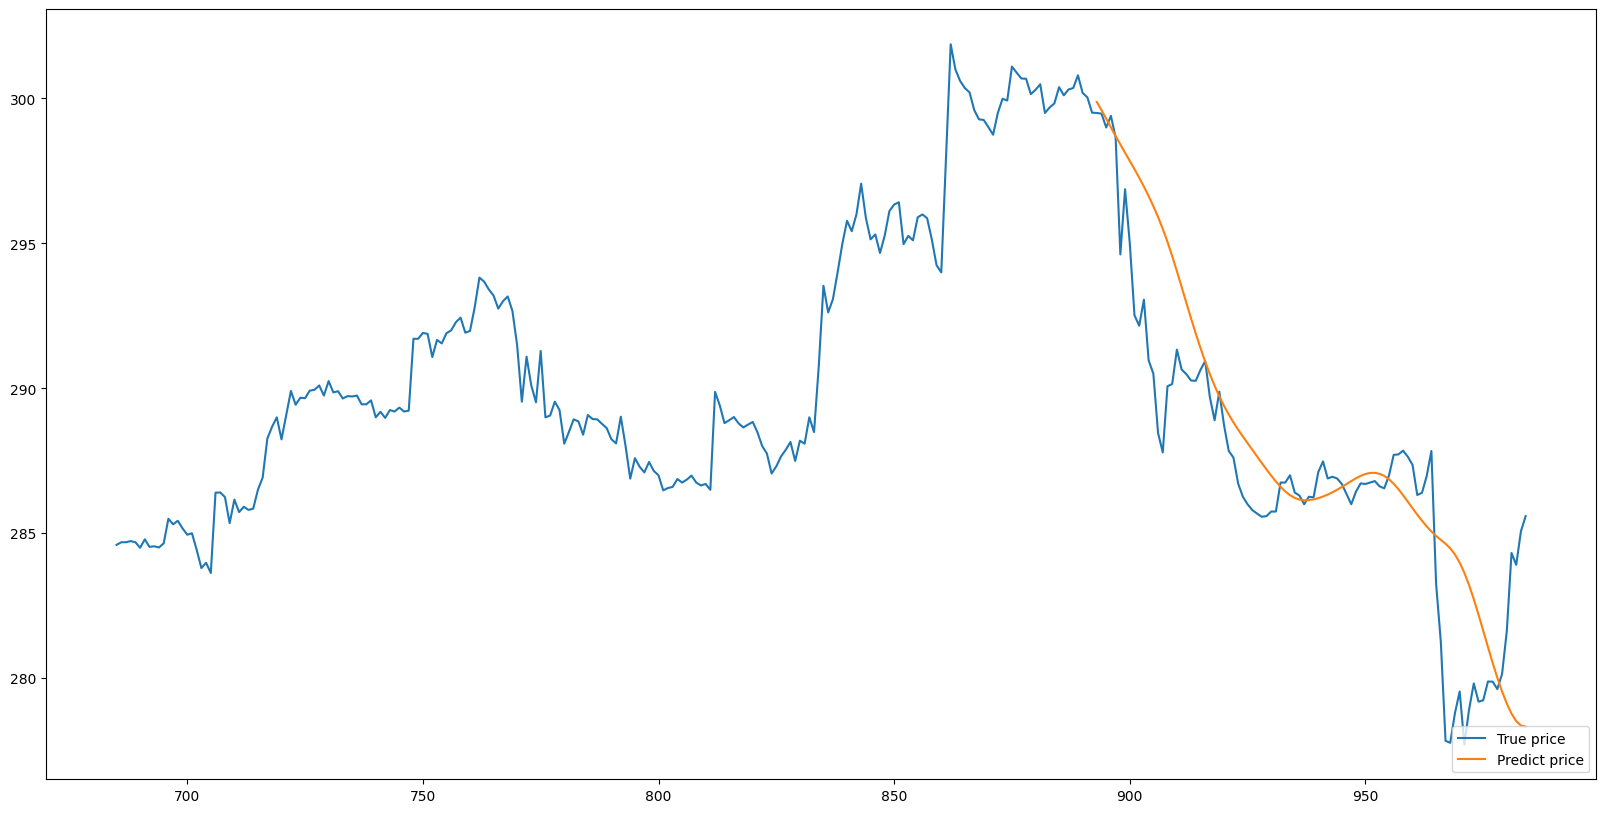

In [67]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

Epoch 1/25
24/24 [==============================] - 9s 119ms/step - loss: 0.0877 - val_loss: 0.0065
Epoch 2/25
24/24 [==============================] - 2s 67ms/step - loss: 0.0117 - val_loss: 0.0043
Epoch 3/25
24/24 [==============================] - 2s 68ms/step - loss: 0.0071 - val_loss: 0.0106
Epoch 4/25
24/24 [==============================] - 2s 68ms/step - loss: 0.0090 - val_loss: 0.0060
Epoch 5/25
24/24 [==============================] - 2s 67ms/step - loss: 0.0080 - val_loss: 0.0038
Epoch 6/25
24/24 [==============================] - 2s 75ms/step - loss: 0.0065 - val_loss: 0.0074
Epoch 7/25
24/24 [==============================] - 2s 69ms/step - loss: 0.0055 - val_loss: 0.0039
Epoch 8/25
24/24 [==============================] - 2s 69ms/step - loss: 0.0060 - val_loss: 0.0036
Epoch 9/25
24/24 [==============================] - 2s 73ms/step - loss: 0.0061 - val_loss: 0.0044
Epoch 10/25
24/24 [==============================] - 2s 71ms/step - loss: 0.0069 - val_loss: 0.0055
Epoch 11

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 2s 23ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1737227570.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


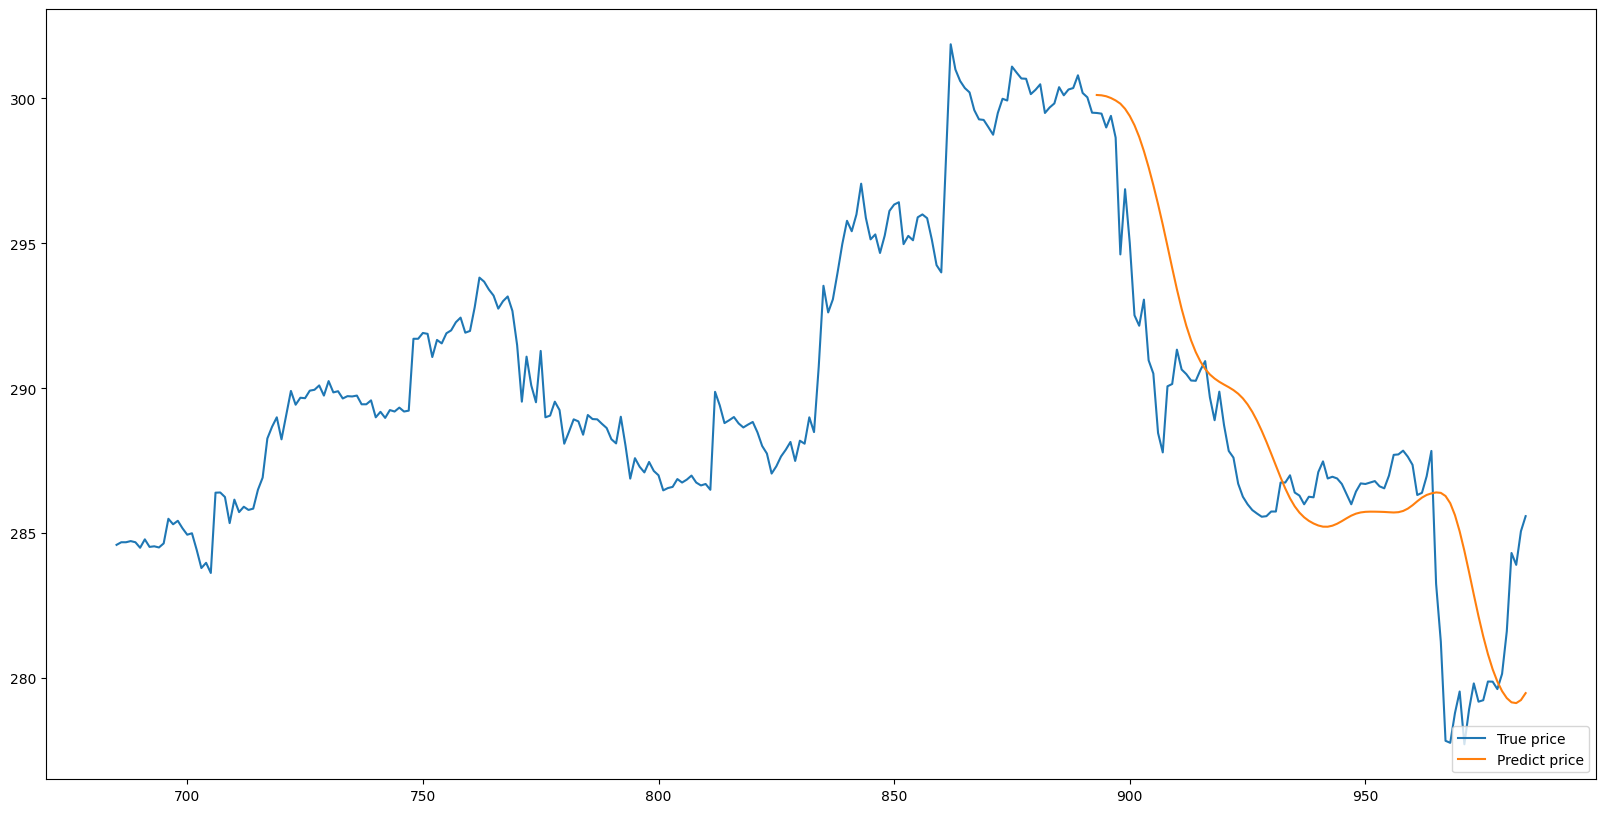

In [68]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_RSI.h5")

model_rnn = load_model('./MODEL/RNN_ROC_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

Epoch 1/25
24/24 [==============================] - 9s 121ms/step - loss: 0.0618 - val_loss: 0.0151
Epoch 2/25
24/24 [==============================] - 2s 76ms/step - loss: 0.0138 - val_loss: 0.0076
Epoch 3/25
24/24 [==============================] - 2s 71ms/step - loss: 0.0091 - val_loss: 0.0063
Epoch 4/25
24/24 [==============================] - 2s 72ms/step - loss: 0.0080 - val_loss: 0.0032
Epoch 5/25
24/24 [==============================] - 2s 71ms/step - loss: 0.0072 - val_loss: 0.0030
Epoch 6/25
24/24 [==============================] - 2s 67ms/step - loss: 0.0067 - val_loss: 0.0058
Epoch 7/25
24/24 [==============================] - 2s 75ms/step - loss: 0.0061 - val_loss: 0.0049
Epoch 8/25
24/24 [==============================] - 2s 72ms/step - loss: 0.0060 - val_loss: 0.0034
Epoch 9/25
24/24 [==============================] - 2s 70ms/step - loss: 0.0064 - val_loss: 0.0041
Epoch 10/25
24/24 [==============================] - 2s 67ms/step - loss: 0.0067 - val_loss: 0.0029
Epoch 11

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 25ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\3739138904.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


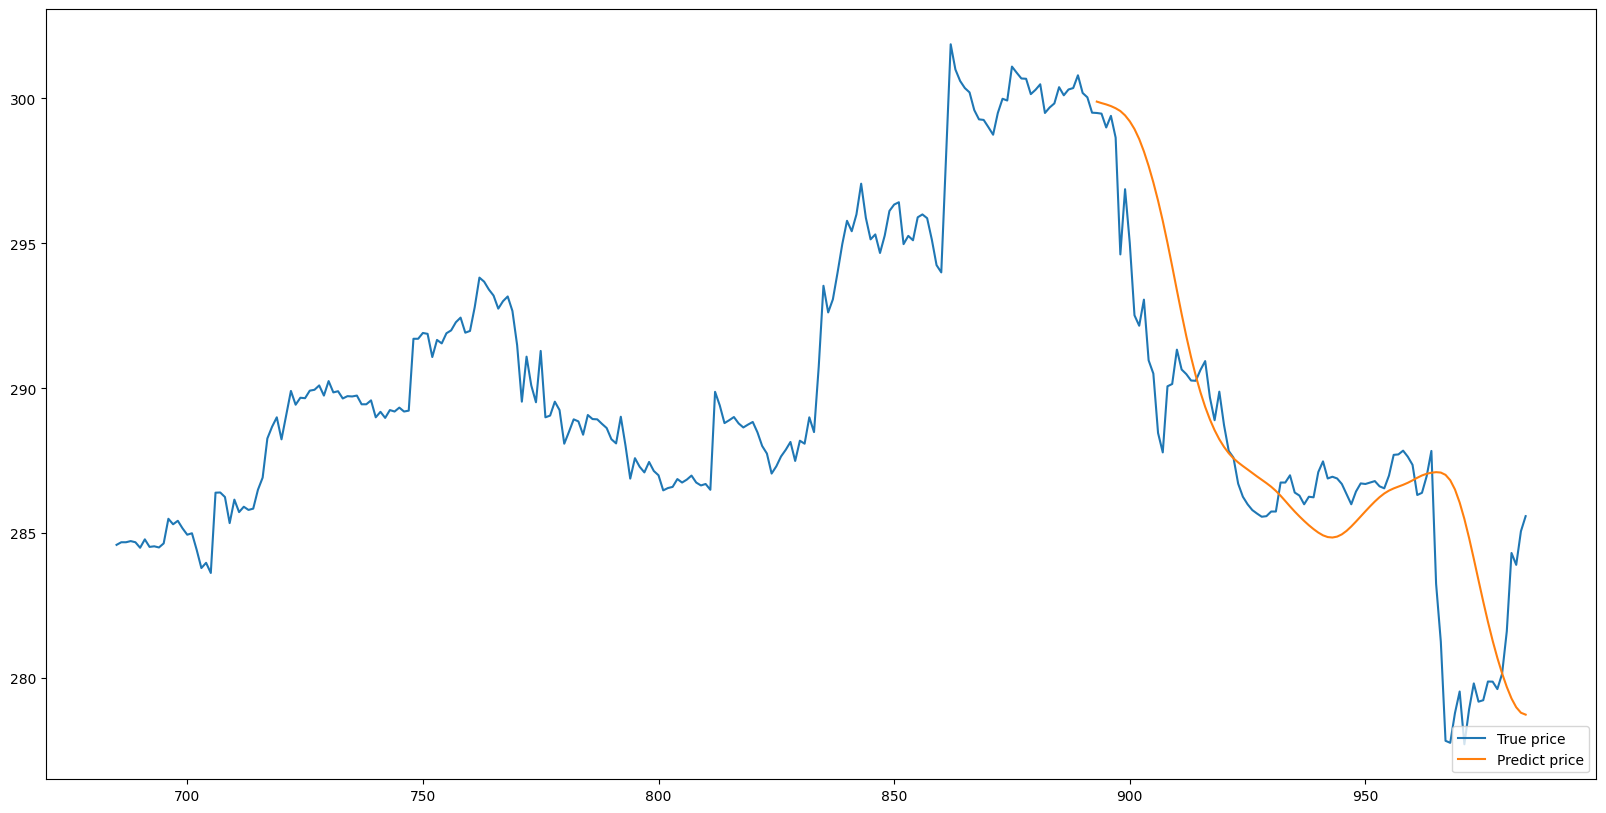

In [69]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_SMA.h5")

model_rnn = load_model('./MODEL/RNN_ROC_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

Epoch 1/25
24/24 [==============================] - 9s 124ms/step - loss: 0.0490 - val_loss: 0.0106
Epoch 2/25
24/24 [==============================] - 2s 76ms/step - loss: 0.0112 - val_loss: 0.0085
Epoch 3/25
24/24 [==============================] - 2s 67ms/step - loss: 0.0080 - val_loss: 0.0053
Epoch 4/25
24/24 [==============================] - 2s 77ms/step - loss: 0.0073 - val_loss: 0.0053
Epoch 5/25
24/24 [==============================] - 2s 72ms/step - loss: 0.0062 - val_loss: 0.0036
Epoch 6/25
24/24 [==============================] - 2s 70ms/step - loss: 0.0062 - val_loss: 0.0043
Epoch 7/25
24/24 [==============================] - 2s 68ms/step - loss: 0.0070 - val_loss: 0.0151
Epoch 8/25
24/24 [==============================] - 2s 80ms/step - loss: 0.0082 - val_loss: 0.0034
Epoch 9/25
24/24 [==============================] - 2s 68ms/step - loss: 0.0059 - val_loss: 0.0114
Epoch 10/25
24/24 [==============================] - 2s 75ms/step - loss: 0.0066 - val_loss: 0.0032
Epoch 11

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 29ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\3709734419.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


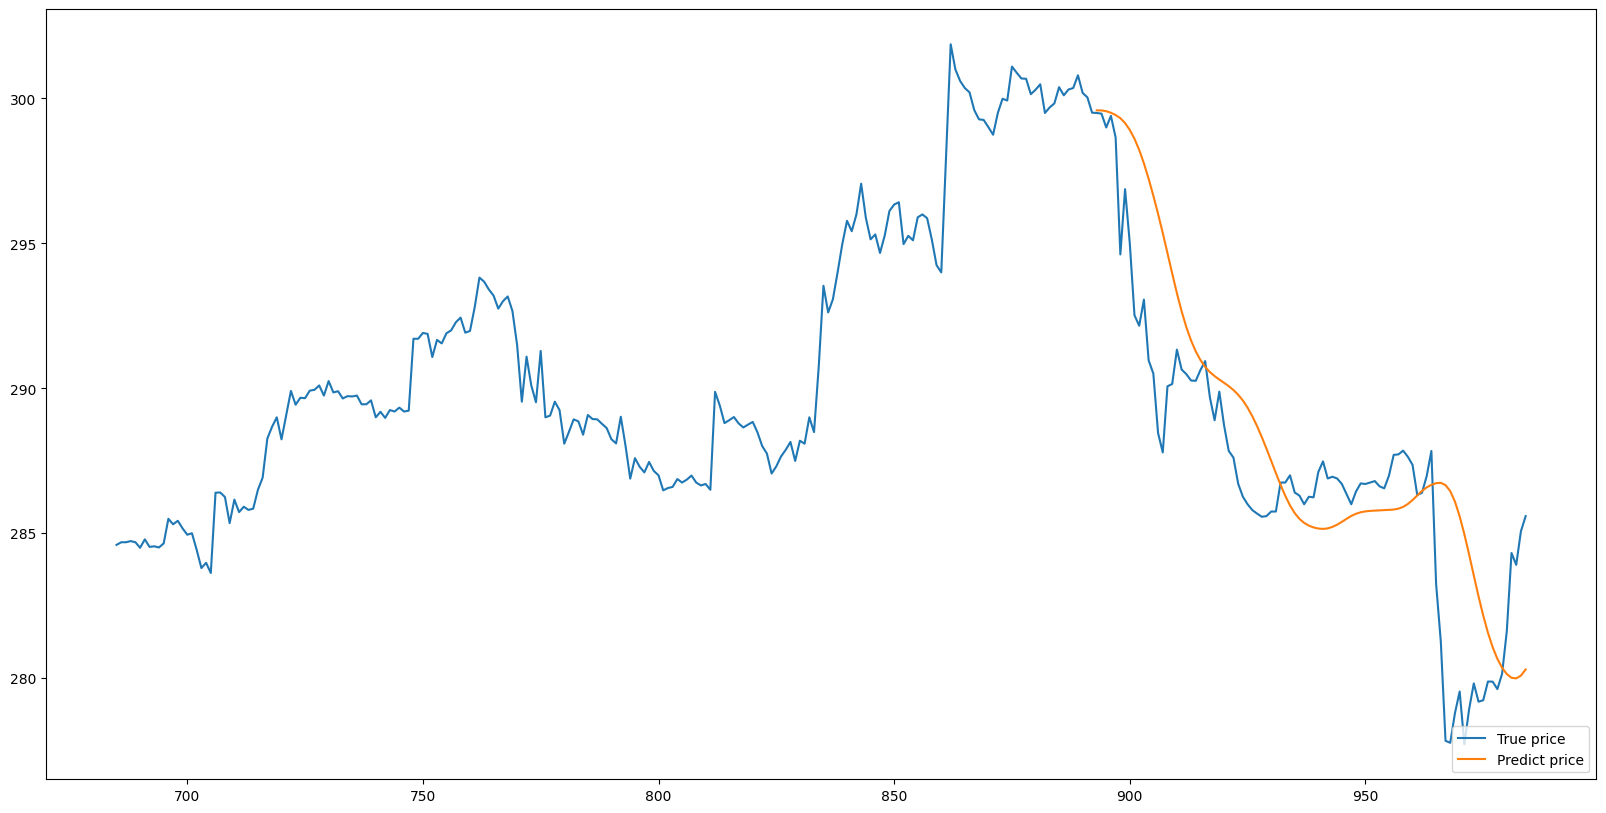

In [70]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

Epoch 1/25
24/24 [==============================] - 9s 131ms/step - loss: 0.0609 - val_loss: 0.0131
Epoch 2/25
24/24 [==============================] - 2s 77ms/step - loss: 0.0132 - val_loss: 0.0073
Epoch 3/25
24/24 [==============================] - 2s 78ms/step - loss: 0.0113 - val_loss: 0.0078
Epoch 4/25
24/24 [==============================] - 2s 73ms/step - loss: 0.0070 - val_loss: 0.0091
Epoch 5/25
24/24 [==============================] - 2s 73ms/step - loss: 0.0061 - val_loss: 0.0082
Epoch 6/25
24/24 [==============================] - 2s 74ms/step - loss: 0.0076 - val_loss: 0.0043
Epoch 7/25
24/24 [==============================] - 2s 75ms/step - loss: 0.0083 - val_loss: 0.0119
Epoch 8/25
24/24 [==============================] - 2s 74ms/step - loss: 0.0068 - val_loss: 0.0094
Epoch 9/25
24/24 [==============================] - 2s 75ms/step - loss: 0.0058 - val_loss: 0.0087
Epoch 10/25
24/24 [==============================] - 2s 74ms/step - loss: 0.0056 - val_loss: 0.0188
Epoch 11

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 30ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\841149531.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


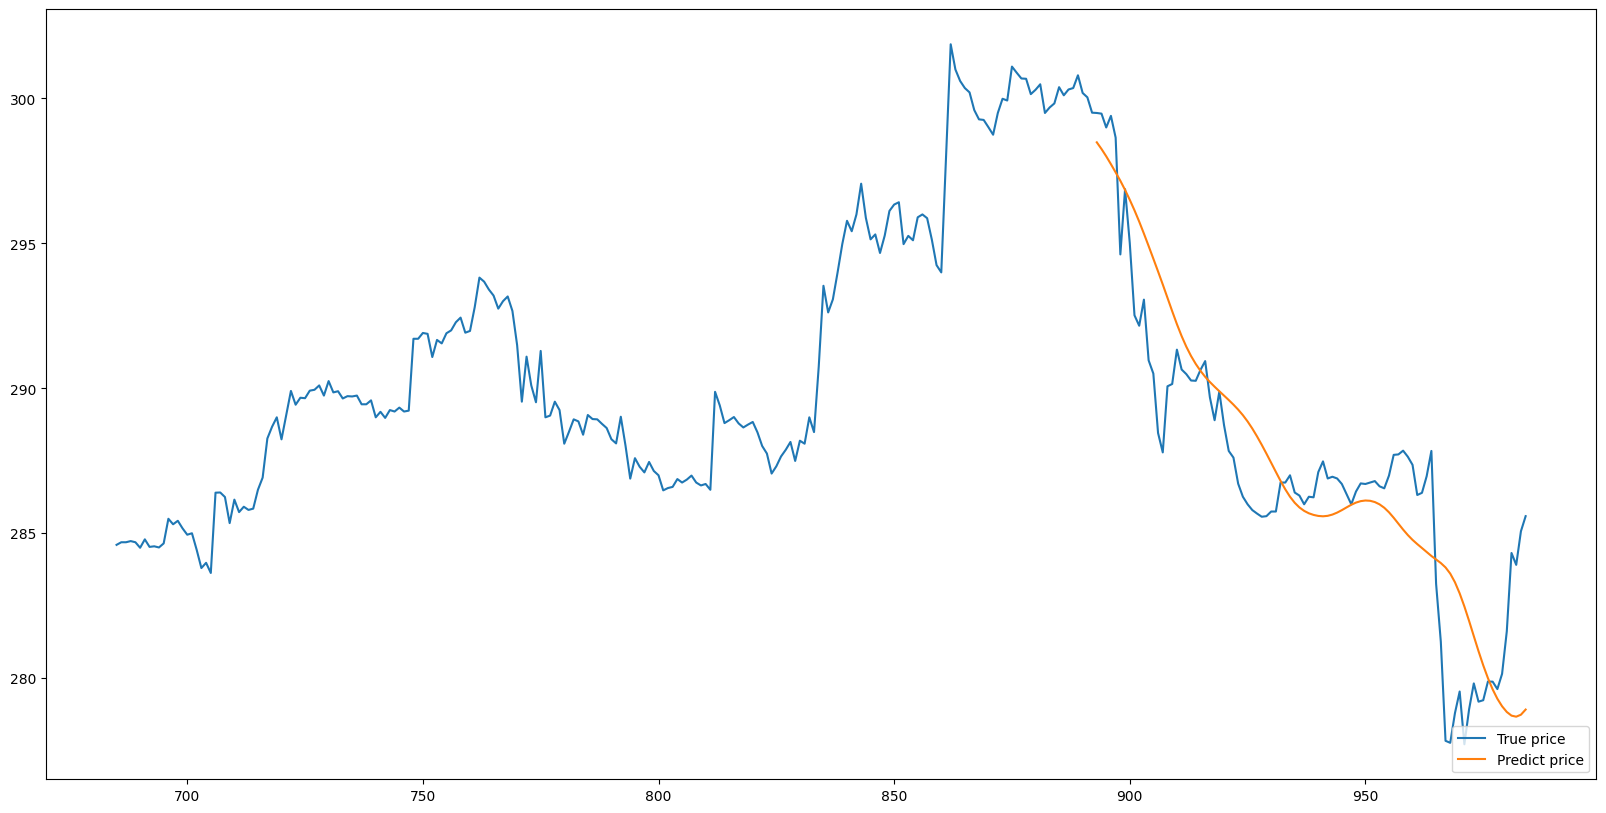

In [71]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_RSI.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

Epoch 1/25
24/24 [==============================] - 10s 128ms/step - loss: 0.1063 - val_loss: 0.0142
Epoch 2/25
24/24 [==============================] - 2s 76ms/step - loss: 0.0167 - val_loss: 0.0175
Epoch 3/25
24/24 [==============================] - 2s 69ms/step - loss: 0.0114 - val_loss: 0.0102
Epoch 4/25
24/24 [==============================] - 2s 69ms/step - loss: 0.0081 - val_loss: 0.0097
Epoch 5/25
24/24 [==============================] - 2s 77ms/step - loss: 0.0075 - val_loss: 0.0060
Epoch 6/25
24/24 [==============================] - 2s 77ms/step - loss: 0.0072 - val_loss: 0.0049
Epoch 7/25
24/24 [==============================] - 2s 69ms/step - loss: 0.0067 - val_loss: 0.0103
Epoch 8/25
24/24 [==============================] - 2s 70ms/step - loss: 0.0100 - val_loss: 0.0038
Epoch 9/25
24/24 [==============================] - 2s 73ms/step - loss: 0.0081 - val_loss: 0.0111
Epoch 10/25
24/24 [==============================] - 2s 68ms/step - loss: 0.0067 - val_loss: 0.0060
Epoch 1

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 24ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\3091204550.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


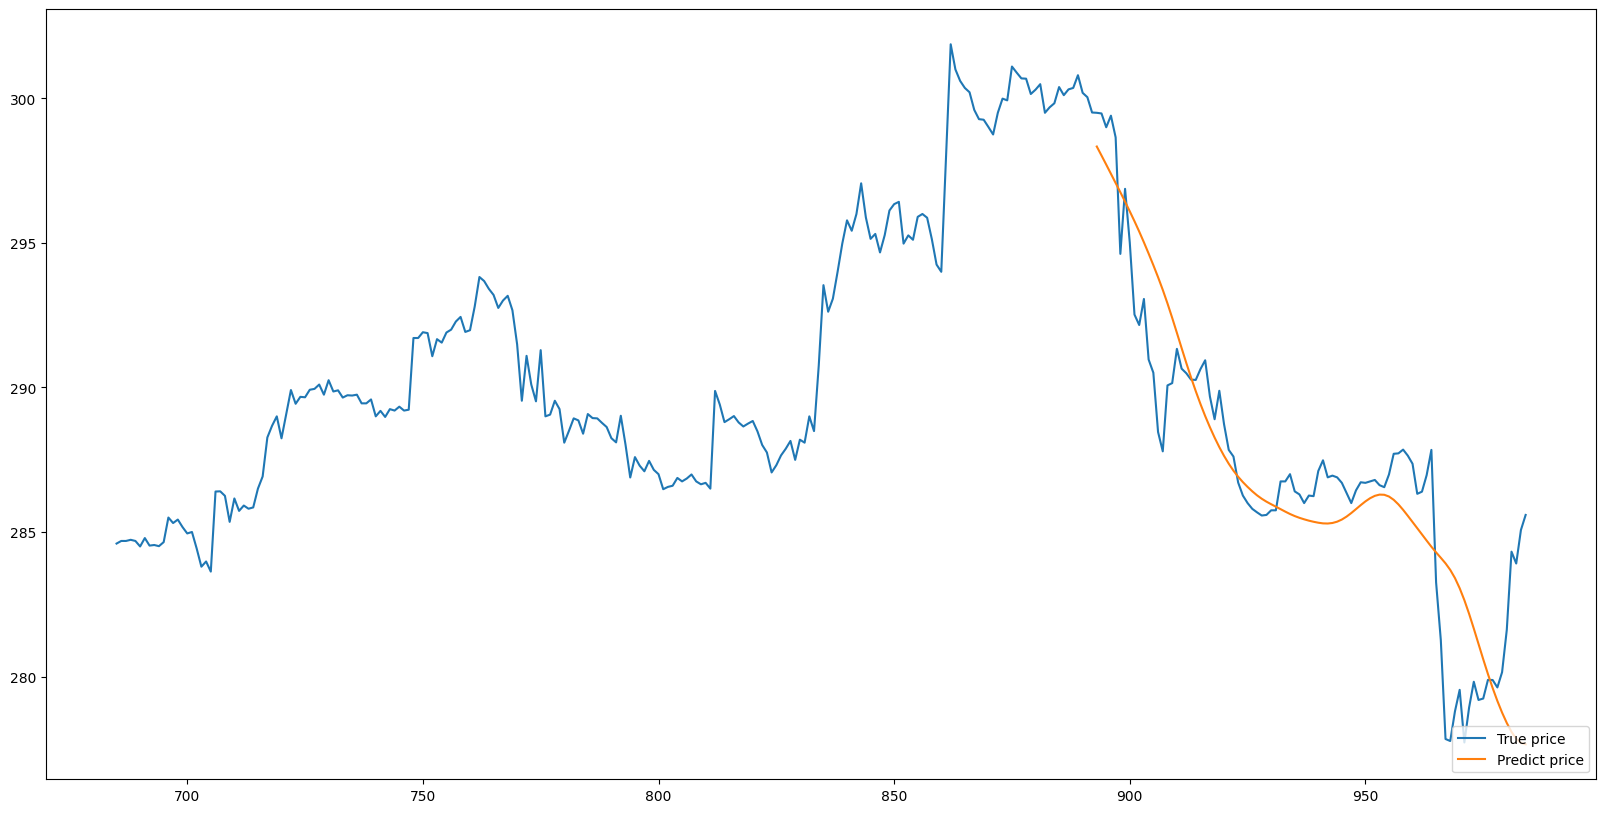

In [72]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

Epoch 1/25
24/24 [==============================] - 10s 142ms/step - loss: 0.0771 - val_loss: 0.0075
Epoch 2/25
24/24 [==============================] - 2s 75ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 3/25
24/24 [==============================] - 2s 74ms/step - loss: 0.0085 - val_loss: 0.0107
Epoch 4/25
24/24 [==============================] - 2s 73ms/step - loss: 0.0071 - val_loss: 0.0091
Epoch 5/25
24/24 [==============================] - 2s 87ms/step - loss: 0.0069 - val_loss: 0.0080
Epoch 6/25
24/24 [==============================] - 2s 79ms/step - loss: 0.0069 - val_loss: 0.0106
Epoch 7/25
24/24 [==============================] - 2s 83ms/step - loss: 0.0062 - val_loss: 0.0085
Epoch 8/25
24/24 [==============================] - 2s 92ms/step - loss: 0.0057 - val_loss: 0.0060
Epoch 9/25
24/24 [==============================] - 2s 91ms/step - loss: 0.0056 - val_loss: 0.0099
Epoch 10/25
24/24 [==============================] - 2s 77ms/step - loss: 0.0051 - val_loss: 0.0105
Epoch 1

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 2s 36ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1855689813.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


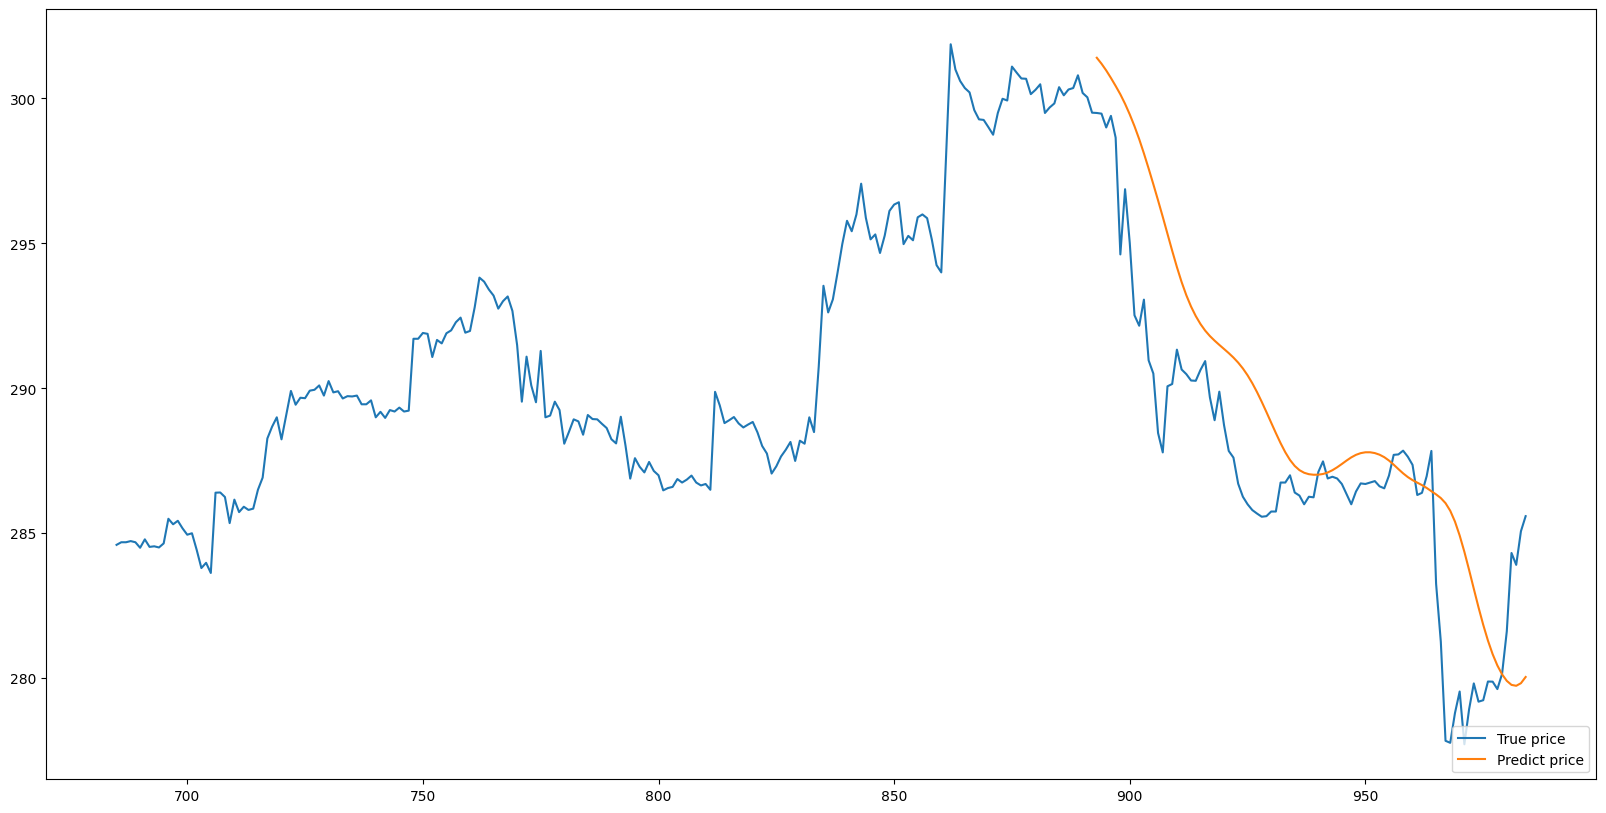

In [73]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

Epoch 1/25
24/24 [==============================] - 10s 138ms/step - loss: 0.0753 - val_loss: 0.0169
Epoch 2/25
24/24 [==============================] - 2s 86ms/step - loss: 0.0132 - val_loss: 0.0101
Epoch 3/25
24/24 [==============================] - 2s 73ms/step - loss: 0.0117 - val_loss: 0.0160
Epoch 4/25
24/24 [==============================] - 2s 71ms/step - loss: 0.0077 - val_loss: 0.0095
Epoch 5/25
24/24 [==============================] - 2s 70ms/step - loss: 0.0064 - val_loss: 0.0085
Epoch 6/25
24/24 [==============================] - 2s 71ms/step - loss: 0.0063 - val_loss: 0.0090
Epoch 7/25
24/24 [==============================] - 2s 68ms/step - loss: 0.0067 - val_loss: 0.0070
Epoch 8/25
24/24 [==============================] - 2s 69ms/step - loss: 0.0062 - val_loss: 0.0091
Epoch 9/25
24/24 [==============================] - 2s 78ms/step - loss: 0.0059 - val_loss: 0.0095
Epoch 10/25
24/24 [==============================] - 2s 72ms/step - loss: 0.0060 - val_loss: 0.0100
Epoch 1

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 24ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\95320114.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


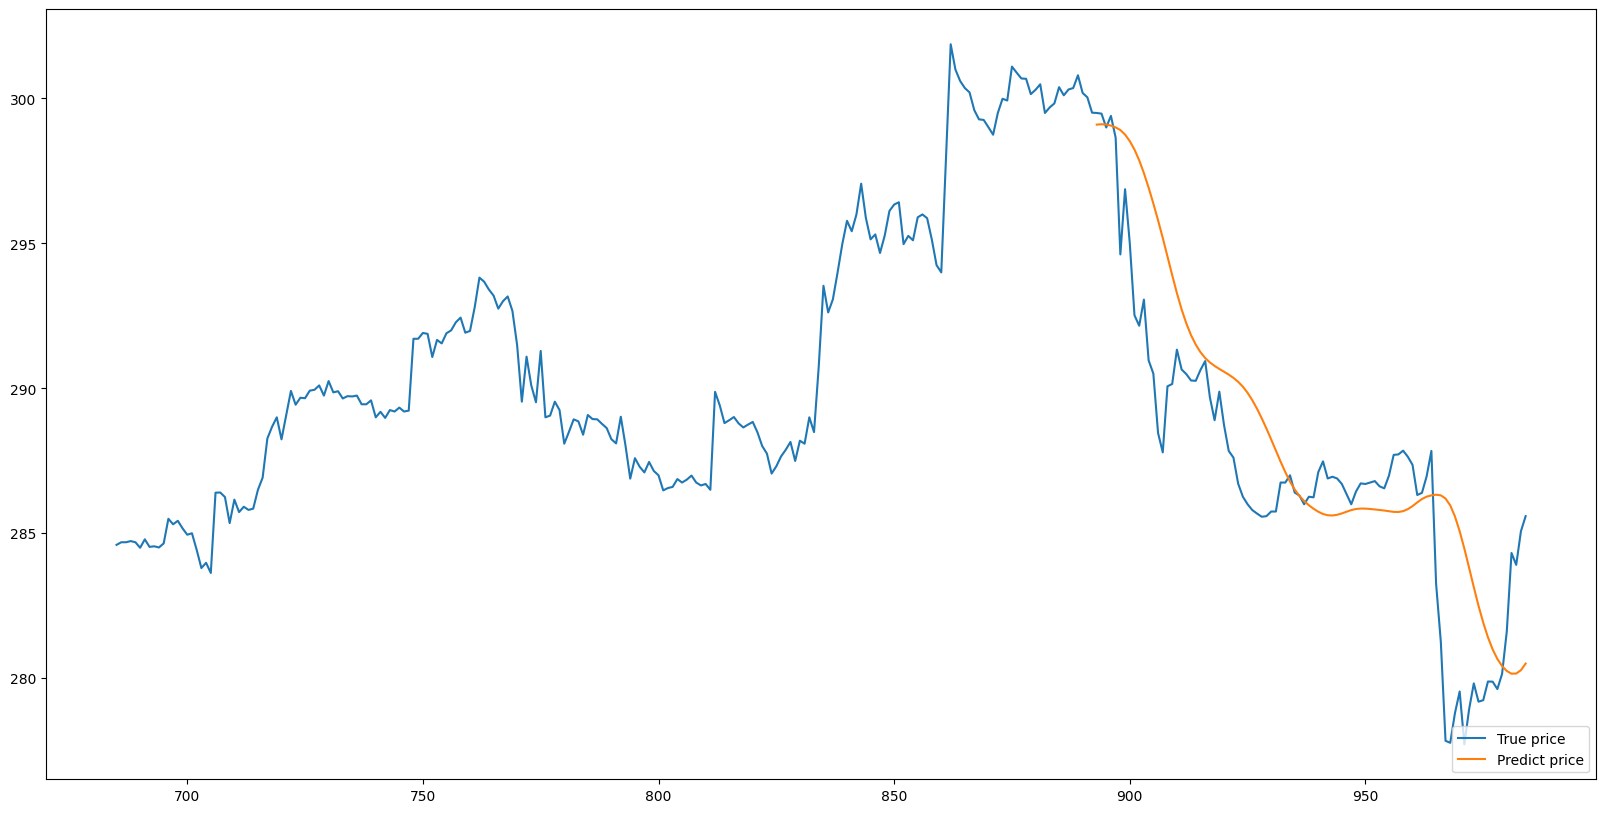

In [74]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_ROC_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

Epoch 1/25
24/24 [==============================] - 9s 129ms/step - loss: 0.0512 - val_loss: 0.0140
Epoch 2/25
24/24 [==============================] - 2s 71ms/step - loss: 0.0141 - val_loss: 0.0060
Epoch 3/25
24/24 [==============================] - 2s 69ms/step - loss: 0.0105 - val_loss: 0.0066
Epoch 4/25
24/24 [==============================] - 2s 74ms/step - loss: 0.0074 - val_loss: 0.0058
Epoch 5/25
24/24 [==============================] - 2s 72ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 6/25
24/24 [==============================] - 2s 74ms/step - loss: 0.0066 - val_loss: 0.0096
Epoch 7/25
24/24 [==============================] - 2s 69ms/step - loss: 0.0069 - val_loss: 0.0044
Epoch 8/25
24/24 [==============================] - 2s 71ms/step - loss: 0.0068 - val_loss: 0.0075
Epoch 9/25
24/24 [==============================] - 2s 69ms/step - loss: 0.0053 - val_loss: 0.0103
Epoch 10/25
24/24 [==============================] - 2s 71ms/step - loss: 0.0060 - val_loss: 0.0122
Epoch 11

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 24ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1118276770.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


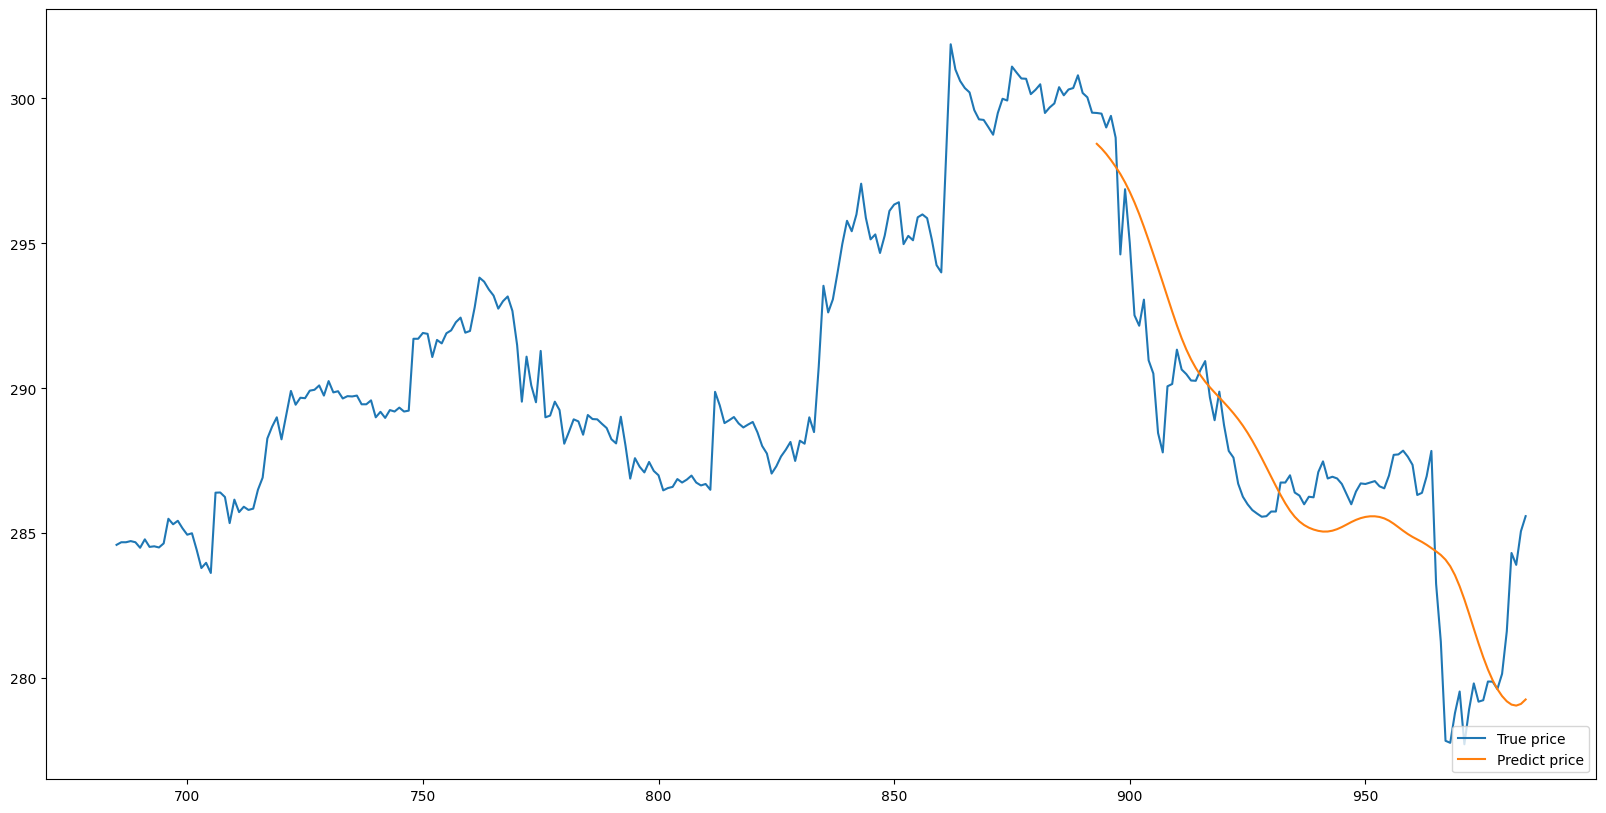

In [75]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

## 3. XGBOOST

### a. Prepare Input

In [76]:
original_df = pd.read_csv(csvPath)
dataset = original_df[['close', 'volume']]
dataset

close     volume
0    315.520    28445.0
1    314.930    34239.0
2    316.500  1613569.0
3    314.055   817536.0
4    313.965   868140.0
..       ...        ...
980  281.617   363166.0
981  284.320   868083.0
982  283.910   852731.0
983  285.070   381817.0
984  285.590   579807.0

[985 rows x 2 columns]

In [77]:
for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
dataset

C:\Users\USER\AppData\Local\Temp\ipykernel_14184\2714080084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\2714080084.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\2714080084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

close     volume  close_date_1  volume_date_1  close_date_2  \
0    315.520    28445.0           NaN            NaN           NaN   
1    314.930    34239.0       315.520        28445.0           NaN   
2    316.500  1613569.0       314.930        34239.0       315.520   
3    314.055   817536.0       316.500      1613569.0       314.930   
4    313.965   868140.0       314.055       817536.0       316.500   
..       ...        ...           ...            ...           ...   
980  281.617   363166.0       280.150       209768.0       279.624   
981  284.320   868083.0       281.617       363166.0       280.150   
982  283.910   852731.0       284.320       868083.0       281.617   
983  285.070   381817.0       283.910       852731.0       284.320   
984  285.590   579807.0       285.070       381817.0       283.910   

     volume_date_2  
0              NaN  
1              NaN  
2          28445.0  
3          34239.0  
4        1613569.0  
..             ...  
980       255731.0  
981       209768.0  
982       363166.0  
983       868083.0  
984       852731.0  

[985 rows x 6 columns]

In [78]:
dataset.dropna(inplace=True)
dataset

C:\Users\USER\AppData\Local\Temp\ipykernel_14184\2012072806.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.dropna(inplace=True)


close     volume  close_date_1  volume_date_1  close_date_2  \
2    316.500  1613569.0       314.930        34239.0       315.520   
3    314.055   817536.0       316.500      1613569.0       314.930   
4    313.965   868140.0       314.055       817536.0       316.500   
5    313.650   619879.0       313.965       868140.0       314.055   
6    313.410   780962.0       313.650       619879.0       313.965   
..       ...        ...           ...            ...           ...   
980  281.617   363166.0       280.150       209768.0       279.624   
981  284.320   868083.0       281.617       363166.0       280.150   
982  283.910   852731.0       284.320       868083.0       281.617   
983  285.070   381817.0       283.910       852731.0       284.320   
984  285.590   579807.0       285.070       381817.0       283.910   

     volume_date_2  
2          28445.0  
3          34239.0  
4        1613569.0  
5         817536.0  
6         868140.0  
..             ...  
980       255731.0  
981       209768.0  
982       363166.0  
983       868083.0  
984       852731.0  

[983 rows x 6 columns]

In [79]:
X = dataset.drop(['close', 'volume'], axis=1)
y = pd.DataFrame(dataset['close'])
print(X.shape)
print(y.shape)
X

(983, 4)
(983, 1)


close_date_1  volume_date_1  close_date_2  volume_date_2
2         314.930        34239.0       315.520        28445.0
3         316.500      1613569.0       314.930        34239.0
4         314.055       817536.0       316.500      1613569.0
5         313.965       868140.0       314.055       817536.0
6         313.650       619879.0       313.965       868140.0
..            ...            ...           ...            ...
980       280.150       209768.0       279.624       255731.0
981       281.617       363166.0       280.150       209768.0
982       284.320       868083.0       281.617       363166.0
983       283.910       852731.0       284.320       868083.0
984       285.070       381817.0       283.910       852731.0

[983 rows x 4 columns]

In [80]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

Size train:  (885, 4)
Size test:  (98, 4)


### b. Train Model

In [81]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST.dat", "wb"))

### c. Test Model

In [82]:
model_xgboost = pickle.load(open("./MODEL/XGBOOST.dat", "rb"))

In [83]:
predictions = model_xgboost.predict(X_test)
predictions

array([299.90402, 300.67984, 300.8035 , 301.0575 , 299.674  , 299.5481 ,
       299.44226, 299.4547 , 299.3252 , 299.2798 , 299.33786, 297.53357,
       294.28207, 296.0966 , 294.44702, 291.90033, 292.20193, 294.1506 ,
       291.39716, 290.3484 , 288.8363 , 288.6853 , 288.91626, 289.7002 ,
       291.3675 , 290.2452 , 290.2063 , 290.04065, 289.81293, 290.3243 ,
       291.9883 , 289.7741 , 289.04007, 289.37936, 289.00134, 288.67404,
       288.1782 , 286.74893, 285.5894 , 286.24994, 286.4555 , 286.20248,
       285.6709 , 285.88824, 286.27448, 286.2725 , 286.5297 , 286.3322 ,
       286.53873, 287.07587, 286.3058 , 286.47284, 286.3557 , 286.29492,
       286.44604, 288.52475, 286.92245, 287.09503, 287.1635 , 287.2031 ,
       286.2799 , 286.1863 , 286.3239 , 286.31354, 286.28607, 286.3239 ,
       286.50247, 287.5754 , 286.63187, 286.2569 , 288.50275, 288.40195,
       288.24393, 288.148  , 286.81696, 287.0738 , 285.7422 , 285.79938,
       288.1614 , 284.095  , 279.8648 , 279.49994, 

In [84]:
prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\USER\AppData\Local\Temp\ipykernel_14184\3408706775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


close    volume  close_date_1  volume_date_1  close_date_2  \
887  300.310     274.0       300.110         2299.0       300.390   
888  300.360    5808.0       300.310          274.0       300.110   
889  300.800   12630.0       300.360         5808.0       300.310   
890  300.190    9827.0       300.800        12630.0       300.360   
891  300.040    9177.0       300.190         9827.0       300.800   
..       ...       ...           ...            ...           ...   
980  281.617  363166.0       280.150       209768.0       279.624   
981  284.320  868083.0       281.617       363166.0       280.150   
982  283.910  852731.0       284.320       868083.0       281.617   
983  285.070  381817.0       283.910       852731.0       284.320   
984  285.590  579807.0       285.070       381817.0       283.910   

     volume_date_2  predictions  
887         2675.0   299.904022  
888         2299.0   300.679840  
889          274.0   300.803497  
890         5808.0   301.057495  
891        12630.0   299.674011  
..             ...          ...  
980       255731.0   280.320770  
981       209768.0   280.712952  
982       363166.0   283.829681  
983       868083.0   283.345734  
984       852731.0   284.857788  

[98 rows x 7 columns]

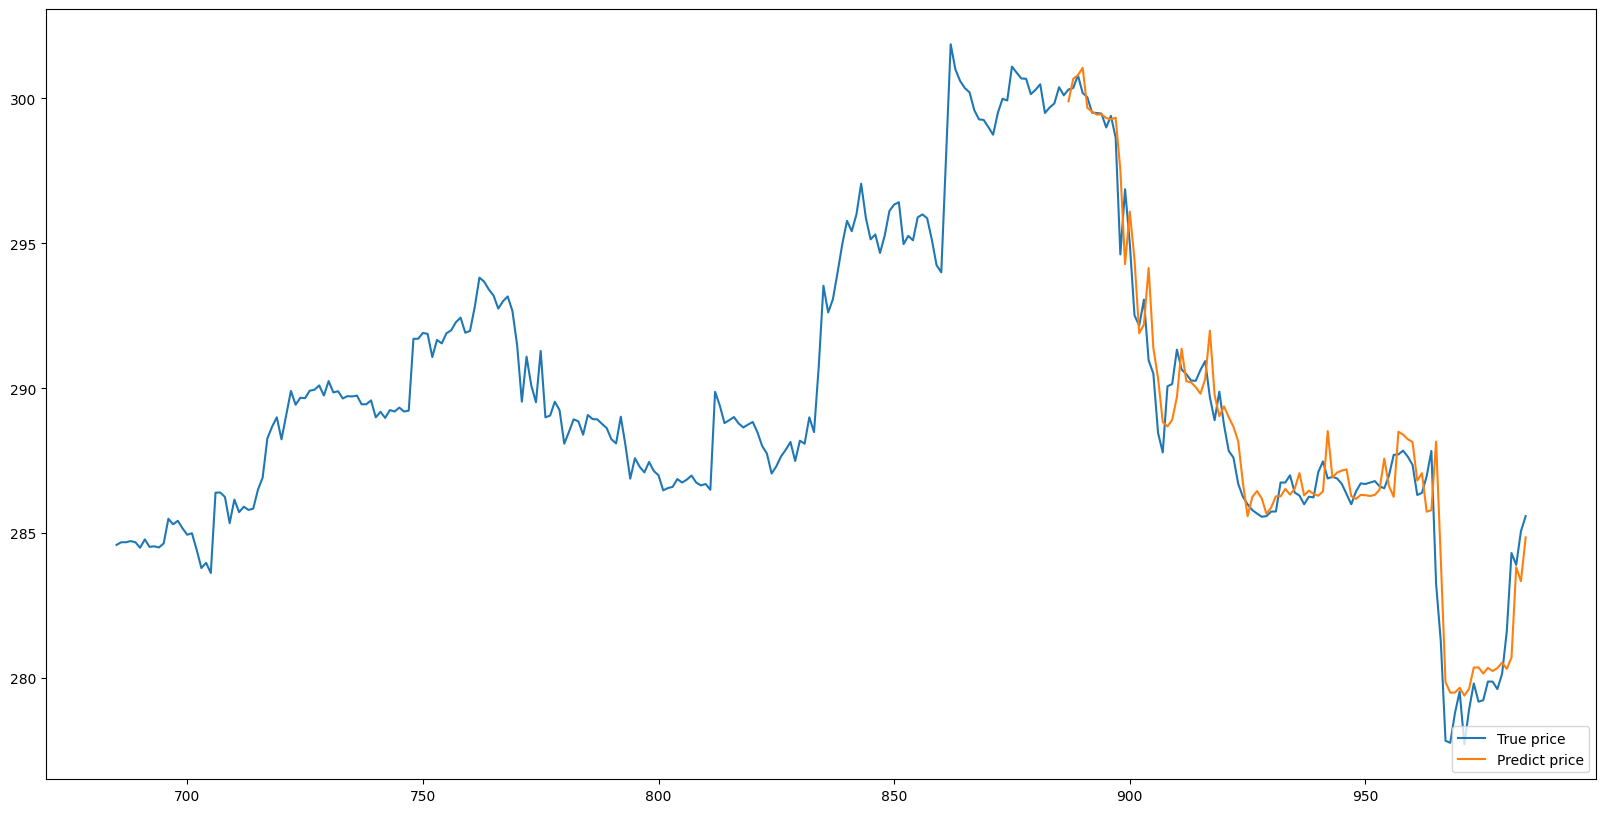

In [85]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [86]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC']]
dataset

close     volume     ROC
0    315.520    28445.0 -0.0823
1    314.930    34239.0 -0.1205
2    316.500  1613569.0  0.4379
3    314.055   817536.0 -0.3316
4    313.965   868140.0 -0.4076
..       ...        ...     ...
980  281.617   363166.0 -1.9985
981  284.320   868083.0 -0.6985
982  283.910   852731.0 -0.8677
983  285.070   381817.0 -0.6621
984  285.590   579807.0 -0.7817

[985 rows x 3 columns]

In [87]:
for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
dataset

C:\Users\USER\AppData\Local\Temp\ipykernel_14184\666477088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\666477088.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\666477088.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

close     volume     ROC  close_date_1  volume_date_1  ROC_date_1  \
0    315.520    28445.0 -0.0823           NaN            NaN         NaN   
1    314.930    34239.0 -0.1205       315.520        28445.0     -0.0823   
2    316.500  1613569.0  0.4379       314.930        34239.0     -0.1205   
3    314.055   817536.0 -0.3316       316.500      1613569.0      0.4379   
4    313.965   868140.0 -0.4076       314.055       817536.0     -0.3316   
..       ...        ...     ...           ...            ...         ...   
980  281.617   363166.0 -1.9985       280.150       209768.0     -2.6039   
981  284.320   868083.0 -0.6985       281.617       363166.0     -1.9985   
982  283.910   852731.0 -0.8677       284.320       868083.0     -0.6985   
983  285.070   381817.0 -0.6621       283.910       852731.0     -0.8677   
984  285.590   579807.0 -0.7817       285.070       381817.0     -0.6621   

     close_date_2  volume_date_2  ROC_date_2  
0             NaN            NaN         NaN  
1             NaN            NaN         NaN  
2         315.520        28445.0     -0.0823  
3         314.930        34239.0     -0.1205  
4         316.500      1613569.0      0.4379  
..            ...            ...         ...  
980       279.624       255731.0     -2.8577  
981       280.150       209768.0     -2.6039  
982       281.617       363166.0     -1.9985  
983       284.320       868083.0     -0.6985  
984       283.910       852731.0     -0.8677  

[985 rows x 9 columns]

In [88]:
dataset.dropna(inplace=True)
dataset

C:\Users\USER\AppData\Local\Temp\ipykernel_14184\2012072806.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.dropna(inplace=True)


close     volume     ROC  close_date_1  volume_date_1  ROC_date_1  \
2    316.500  1613569.0  0.4379       314.930        34239.0     -0.1205   
3    314.055   817536.0 -0.3316       316.500      1613569.0      0.4379   
4    313.965   868140.0 -0.4076       314.055       817536.0     -0.3316   
5    313.650   619879.0 -0.6745       313.965       868140.0     -0.4076   
6    313.410   780962.0 -0.6624       313.650       619879.0     -0.6745   
..       ...        ...     ...           ...            ...         ...   
980  281.617   363166.0 -1.9985       280.150       209768.0     -2.6039   
981  284.320   868083.0 -0.6985       281.617       363166.0     -1.9985   
982  283.910   852731.0 -0.8677       284.320       868083.0     -0.6985   
983  285.070   381817.0 -0.6621       283.910       852731.0     -0.8677   
984  285.590   579807.0 -0.7817       285.070       381817.0     -0.6621   

     close_date_2  volume_date_2  ROC_date_2  
2         315.520        28445.0     -0.0823  
3         314.930        34239.0     -0.1205  
4         316.500      1613569.0      0.4379  
5         314.055       817536.0     -0.3316  
6         313.965       868140.0     -0.4076  
..            ...            ...         ...  
980       279.624       255731.0     -2.8577  
981       280.150       209768.0     -2.6039  
982       281.617       363166.0     -1.9985  
983       284.320       868083.0     -0.6985  
984       283.910       852731.0     -0.8677  

[983 rows x 9 columns]

In [89]:
X = dataset.drop(['close', 'volume', 'ROC'], axis=1)
y = pd.DataFrame(dataset['close'])
print(X.shape)
print(y.shape)
X

(983, 6)
(983, 1)


close_date_1  volume_date_1  ROC_date_1  close_date_2  volume_date_2  \
2         314.930        34239.0     -0.1205       315.520        28445.0   
3         316.500      1613569.0      0.4379       314.930        34239.0   
4         314.055       817536.0     -0.3316       316.500      1613569.0   
5         313.965       868140.0     -0.4076       314.055       817536.0   
6         313.650       619879.0     -0.6745       313.965       868140.0   
..            ...            ...         ...           ...            ...   
980       280.150       209768.0     -2.6039       279.624       255731.0   
981       281.617       363166.0     -1.9985       280.150       209768.0   
982       284.320       868083.0     -0.6985       281.617       363166.0   
983       283.910       852731.0     -0.8677       284.320       868083.0   
984       285.070       381817.0     -0.6621       283.910       852731.0   

     ROC_date_2  
2       -0.0823  
3       -0.1205  
4        0.4379  
5       -0.3316  
6       -0.4076  
..          ...  
980     -2.8577  
981     -2.6039  
982     -1.9985  
983     -0.6985  
984     -0.8677  

[983 rows x 6 columns]

In [90]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

Size train:  (885, 6)
Size test:  (98, 6)


In [91]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC.dat", "wb"))

In [92]:
model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC.dat", "rb"))

In [93]:
predictions = model_xgboost.predict(X_test)
predictions

array([299.6256 , 300.6528 , 300.493  , 300.70535, 299.2974 , 299.23917,
       299.13028, 299.36948, 299.47308, 299.16006, 299.4377 , 297.35214,
       294.16437, 295.95007, 294.79175, 292.1401 , 291.69843, 293.67087,
       291.53177, 290.27368, 288.70215, 287.9631 , 288.5523 , 289.56787,
       291.42792, 290.1082 , 290.1001 , 289.75452, 289.7187 , 290.07782,
       291.69617, 289.75162, 288.83612, 289.3295 , 288.91324, 288.49057,
       287.74695, 285.87302, 285.10474, 285.5105 , 285.7191 , 285.71204,
       285.6889 , 285.34845, 285.71857, 285.672  , 286.26025, 285.7873 ,
       286.21497, 286.54938, 285.83893, 286.1214 , 285.93607, 286.14902,
       286.13766, 288.52313, 286.98706, 287.13232, 287.0945 , 286.85422,
       285.93375, 285.88177, 286.14453, 285.82974, 285.88525, 285.88525,
       286.1336 , 287.3235 , 286.64545, 286.18814, 288.24112, 288.03668,
       288.56985, 288.1844 , 286.8018 , 287.48376, 285.71487, 285.71173,
       288.41348, 283.80453, 279.76993, 279.17728, 

In [94]:
prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\USER\AppData\Local\Temp\ipykernel_14184\3408706775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


close    volume     ROC  close_date_1  volume_date_1  ROC_date_1  \
887  300.310     274.0  0.2370       300.110         2299.0     -0.0333   
888  300.360    5808.0  0.3609       300.310          274.0      0.2370   
889  300.800   12630.0  0.5146       300.360         5808.0      0.3609   
890  300.190    9827.0  0.3946       300.800        12630.0      0.5146   
891  300.040    9177.0  0.4318       300.190         9827.0      0.3946   
..       ...       ...     ...           ...            ...         ...   
980  281.617  363166.0 -1.9985       280.150       209768.0     -2.6039   
981  284.320  868083.0 -0.6985       281.617       363166.0     -1.9985   
982  283.910  852731.0 -0.8677       284.320       868083.0     -0.6985   
983  285.070  381817.0 -0.6621       283.910       852731.0     -0.8677   
984  285.590  579807.0 -0.7817       285.070       381817.0     -0.6621   

     close_date_2  volume_date_2  ROC_date_2  predictions  
887       300.390         2675.0      0.0100   299.625610  
888       300.110         2299.0     -0.0333   300.652802  
889       300.310          274.0      0.2370   300.493011  
890       300.360         5808.0      0.3609   300.705353  
891       300.800        12630.0      0.5146   299.297394  
..            ...            ...         ...          ...  
980       279.624       255731.0     -2.8577   280.302246  
981       280.150       209768.0     -2.6039   280.674103  
982       281.617       363166.0     -1.9985   283.560516  
983       284.320       868083.0     -0.6985   283.474915  
984       283.910       852731.0     -0.8677   284.264221  

[98 rows x 10 columns]

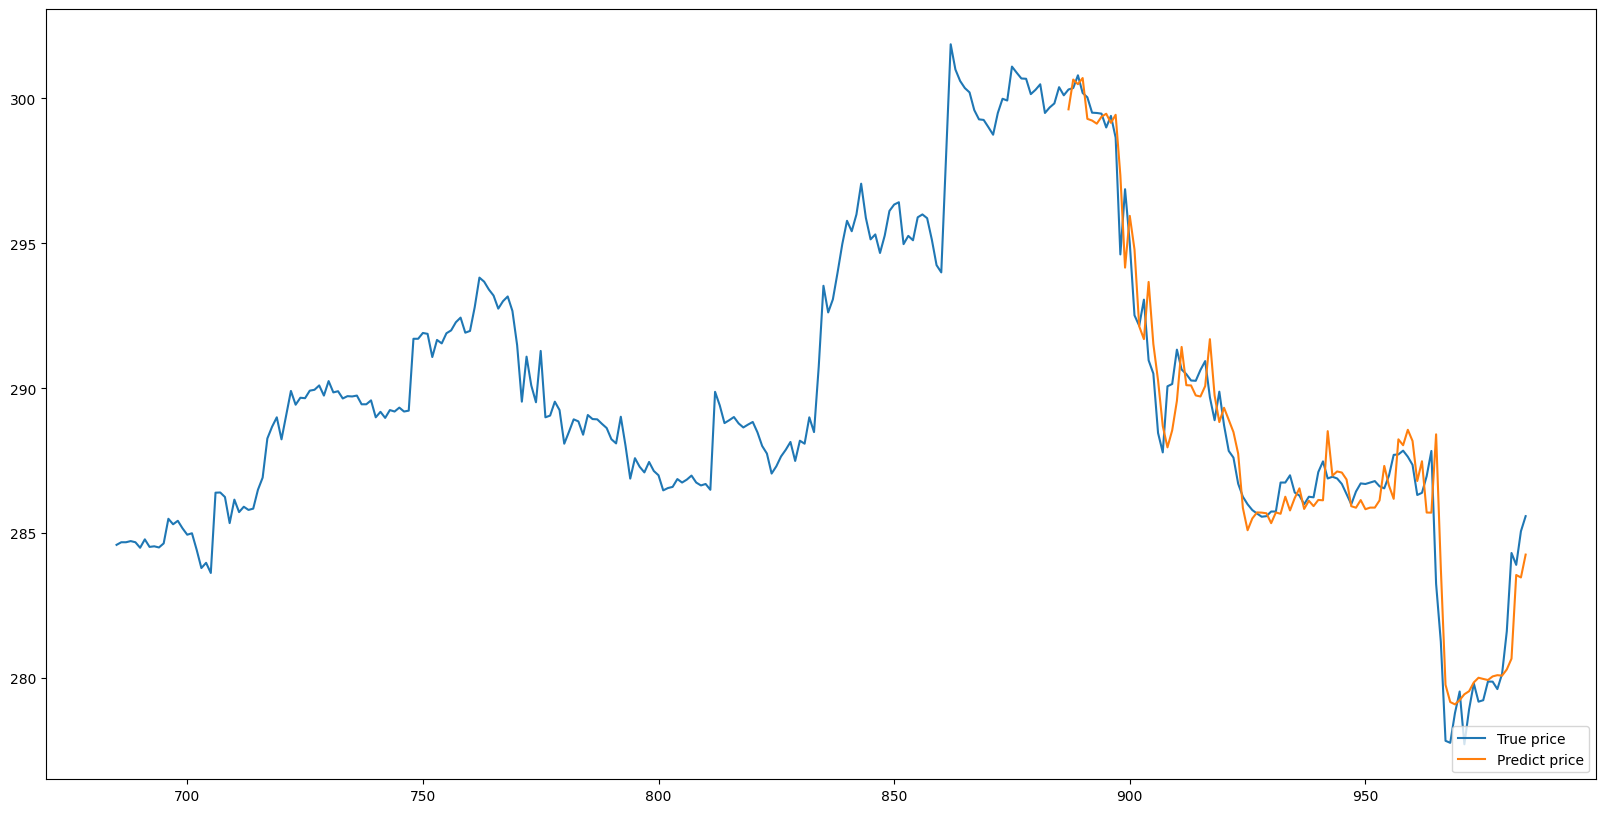

In [95]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1026725636.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1026725636.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1026725636.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

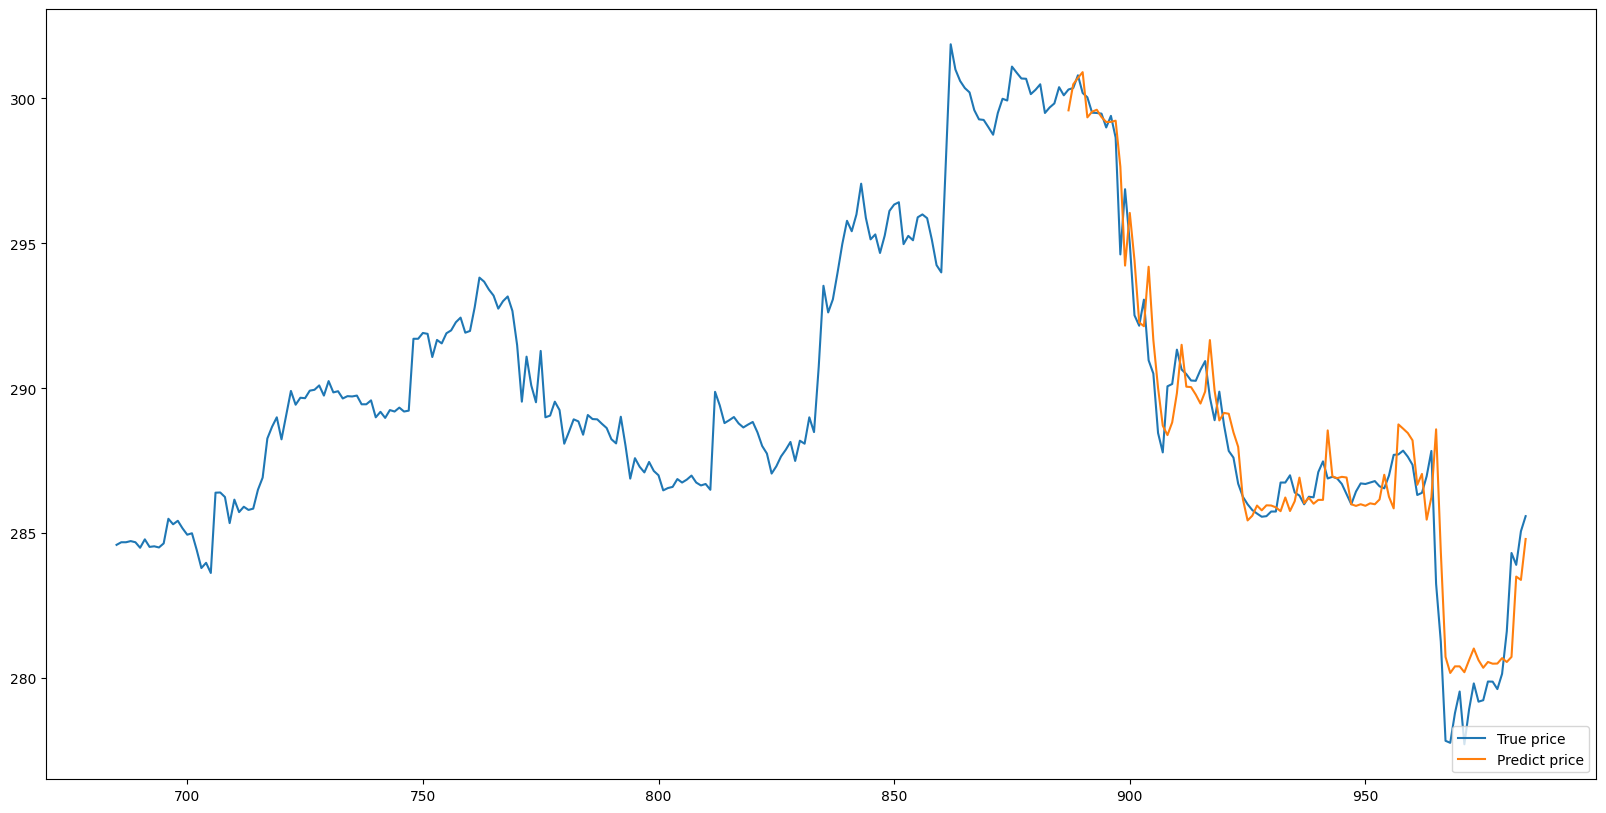

In [96]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1500967414.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1500967414.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1500967414.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

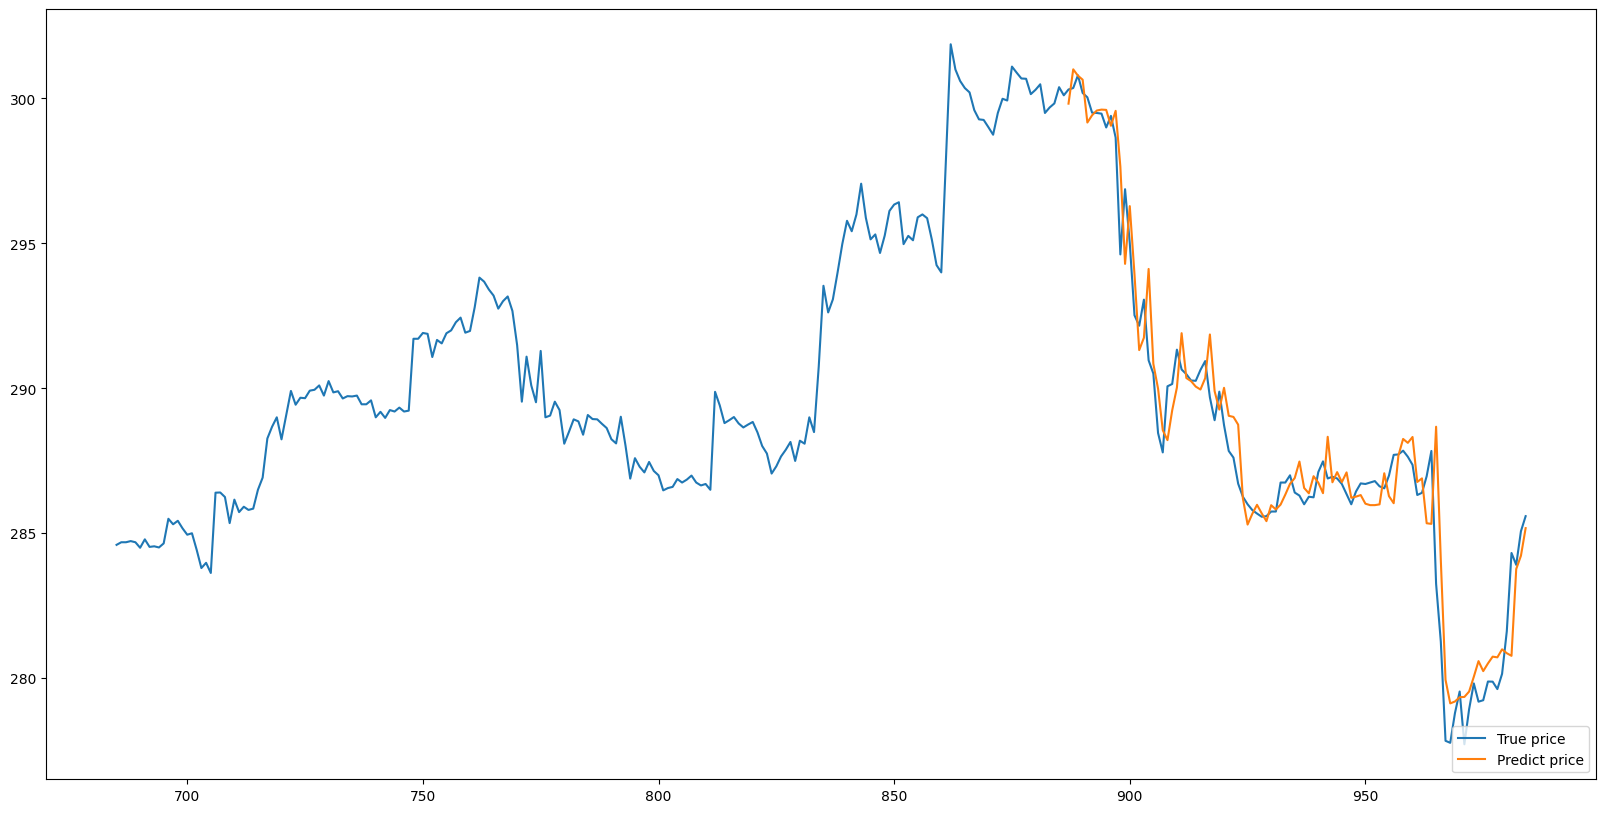

In [97]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

C:\Users\USER\AppData\Local\Temp\ipykernel_14184\2668610043.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\2668610043.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\2668610043.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

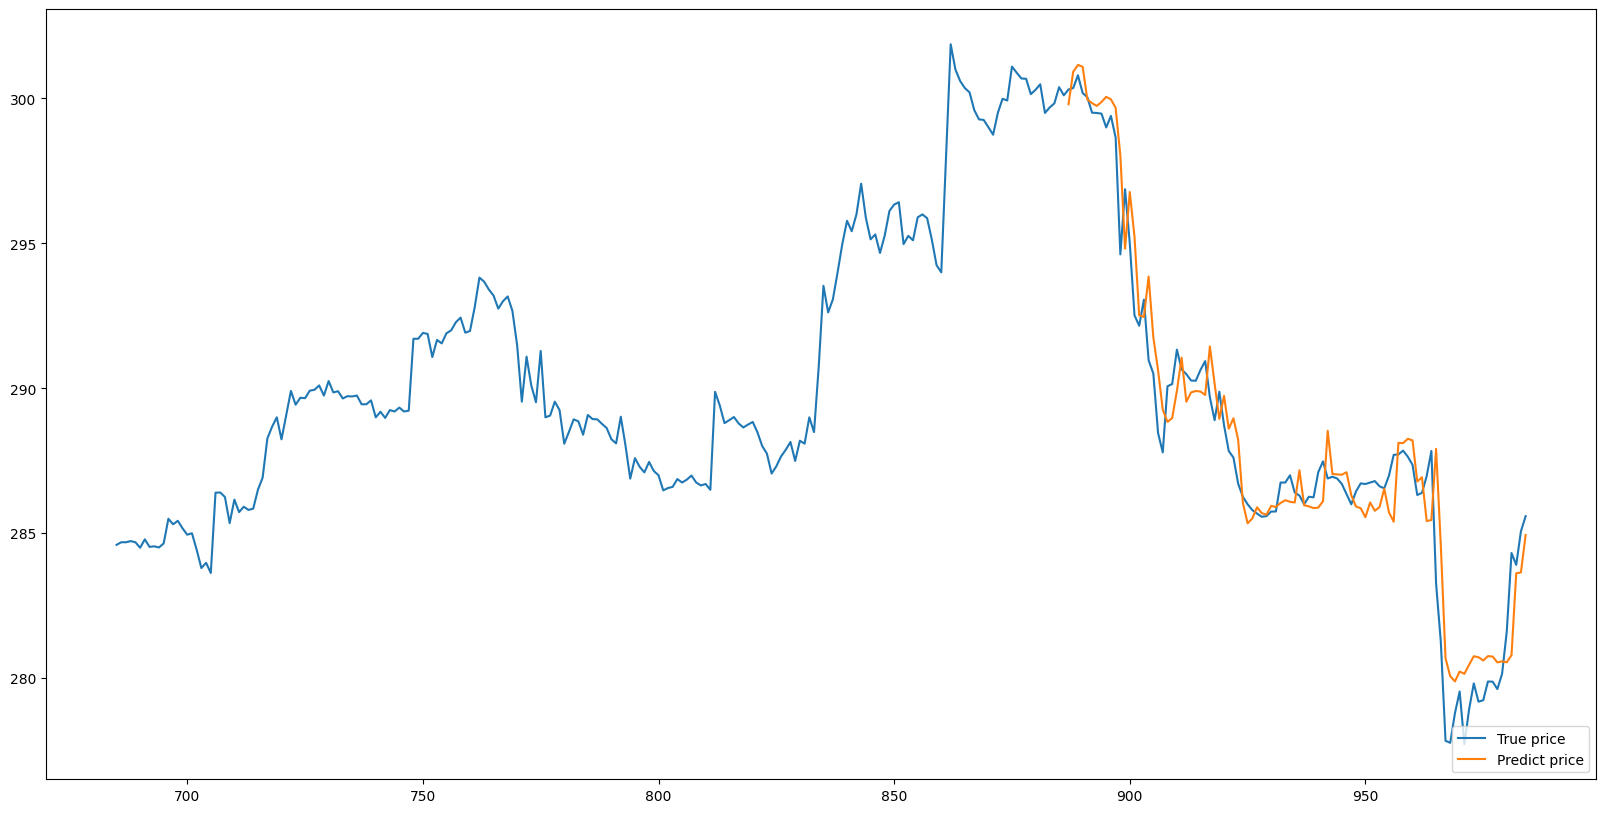

In [98]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)


dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

C:\Users\USER\AppData\Local\Temp\ipykernel_14184\2913271233.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\2913271233.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\2913271233.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

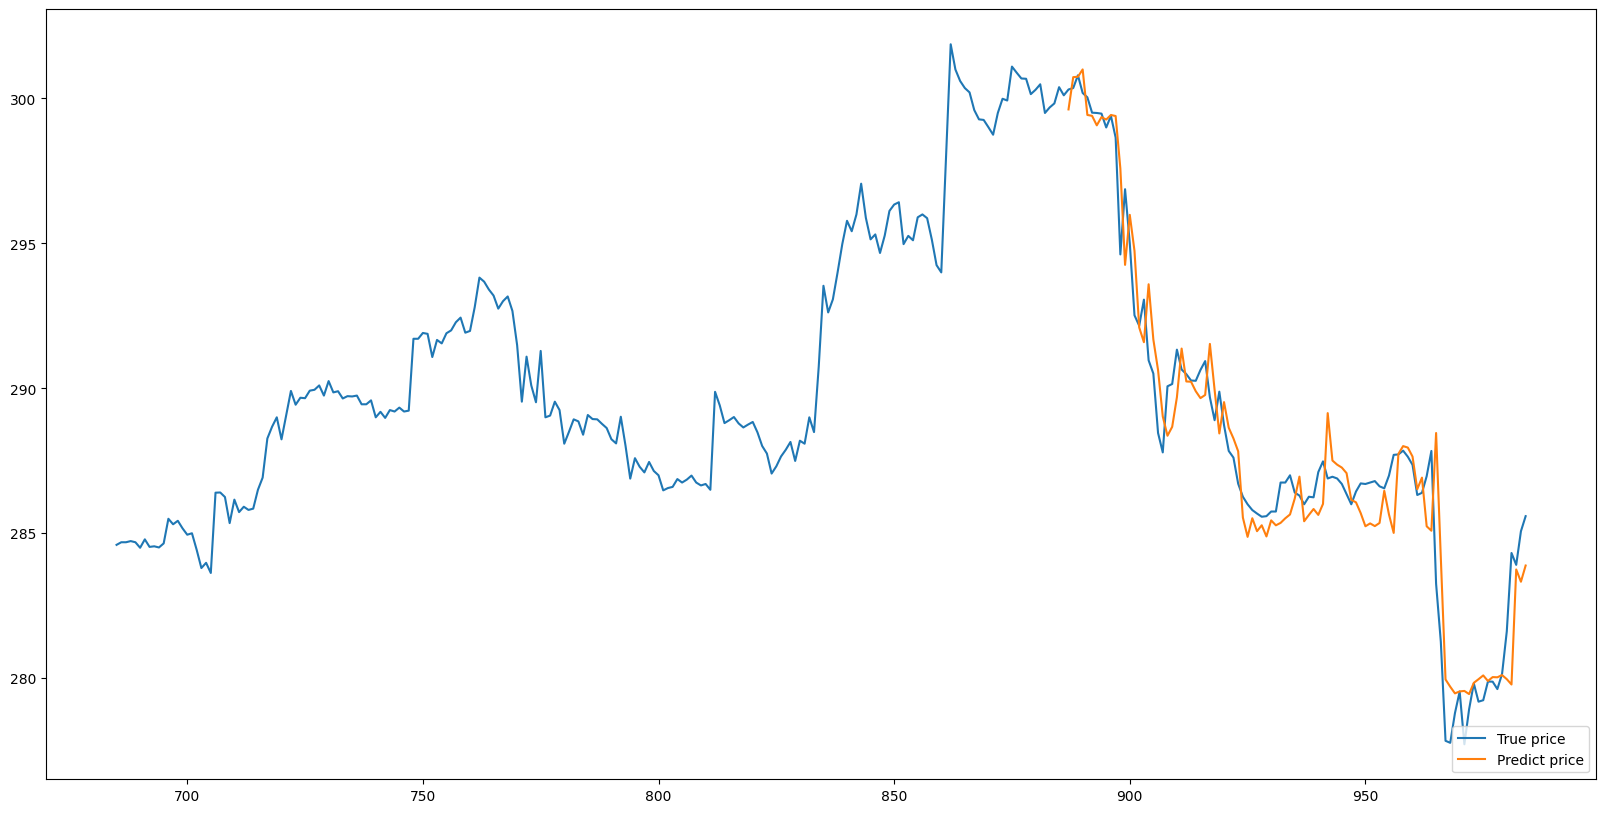

In [99]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

C:\Users\USER\AppData\Local\Temp\ipykernel_14184\2015135087.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\2015135087.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\2015135087.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

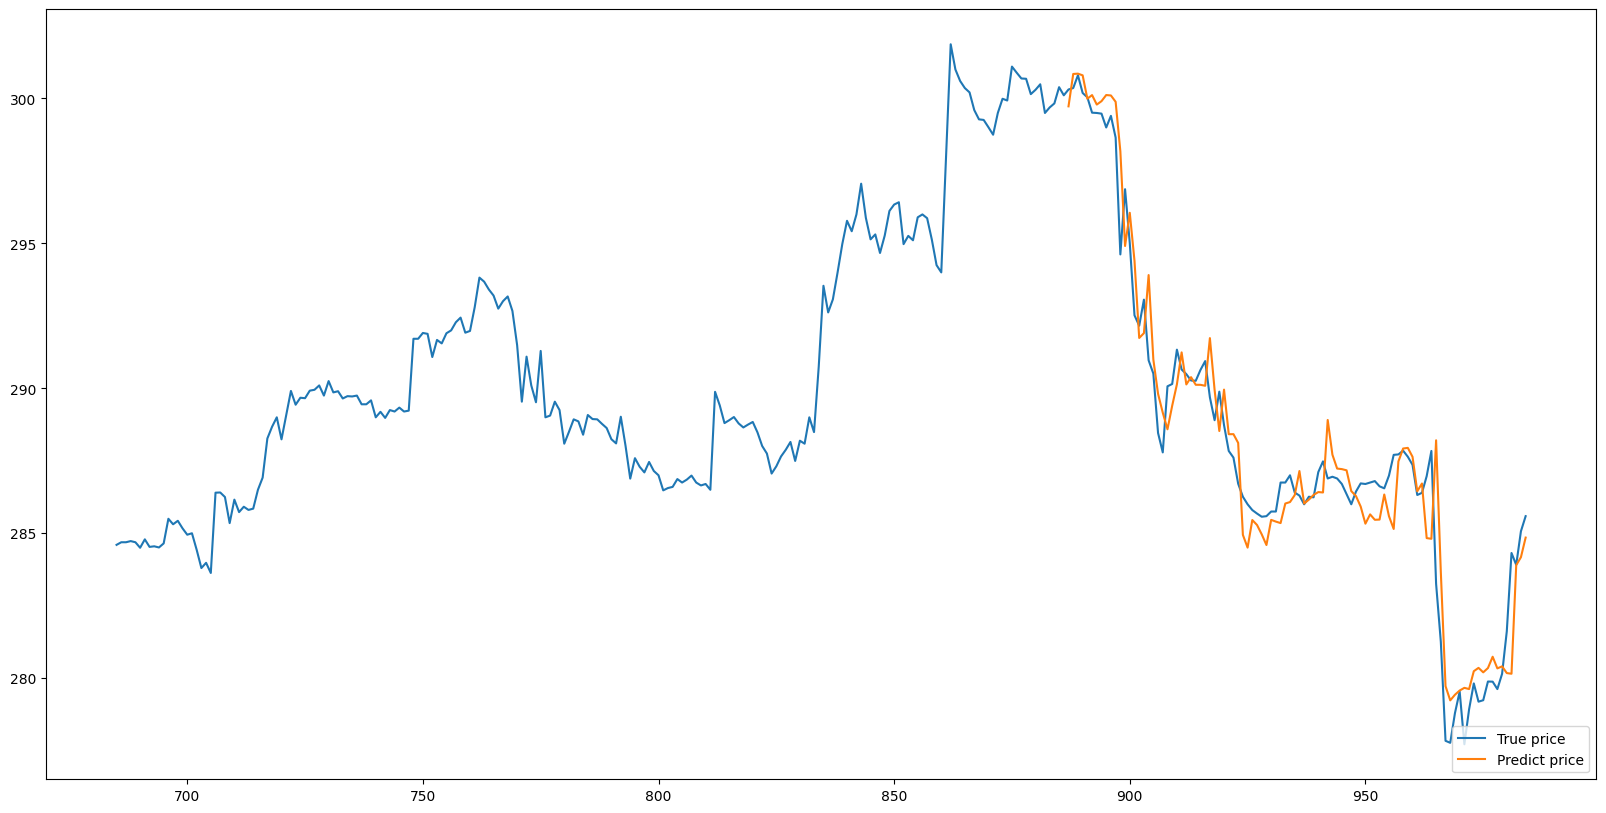

In [100]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1057497457.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1057497457.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1057497457.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

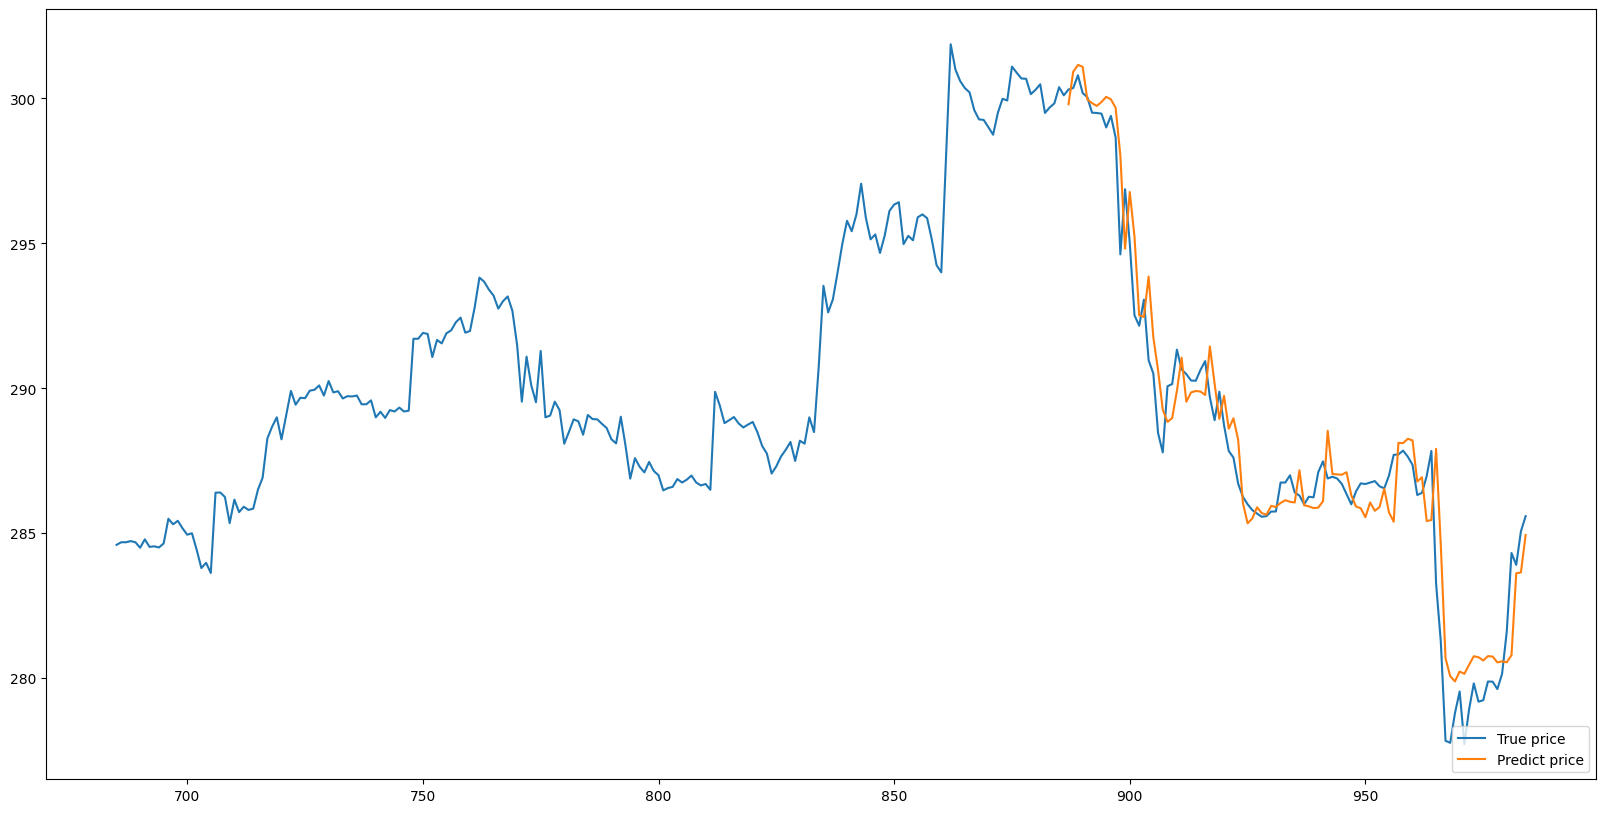

In [101]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1712437508.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1712437508.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1712437508.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

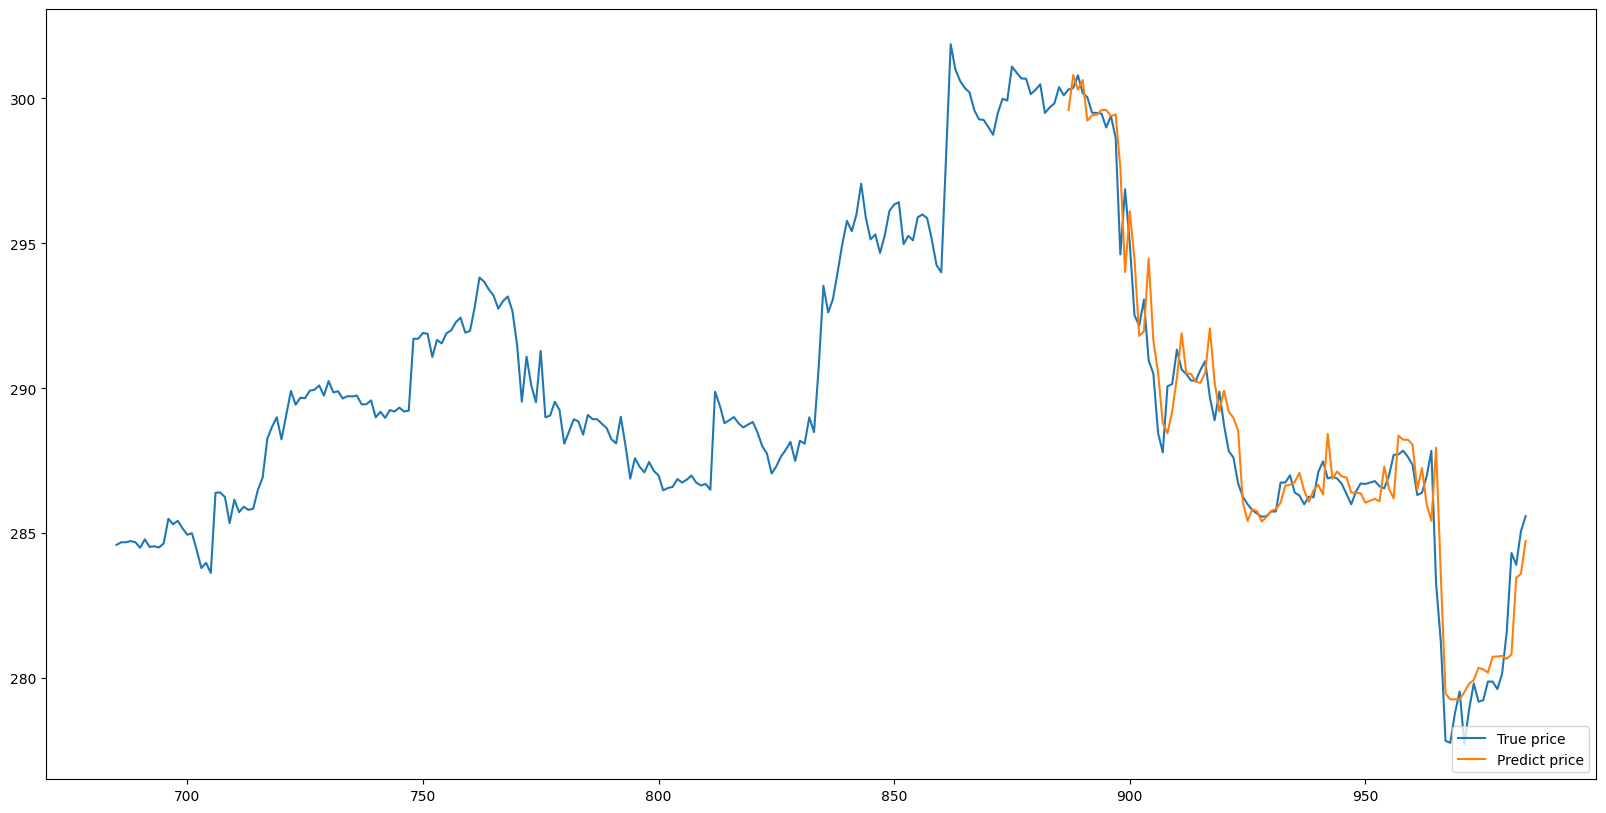

In [102]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

C:\Users\USER\AppData\Local\Temp\ipykernel_14184\4048686227.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\4048686227.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\4048686227.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

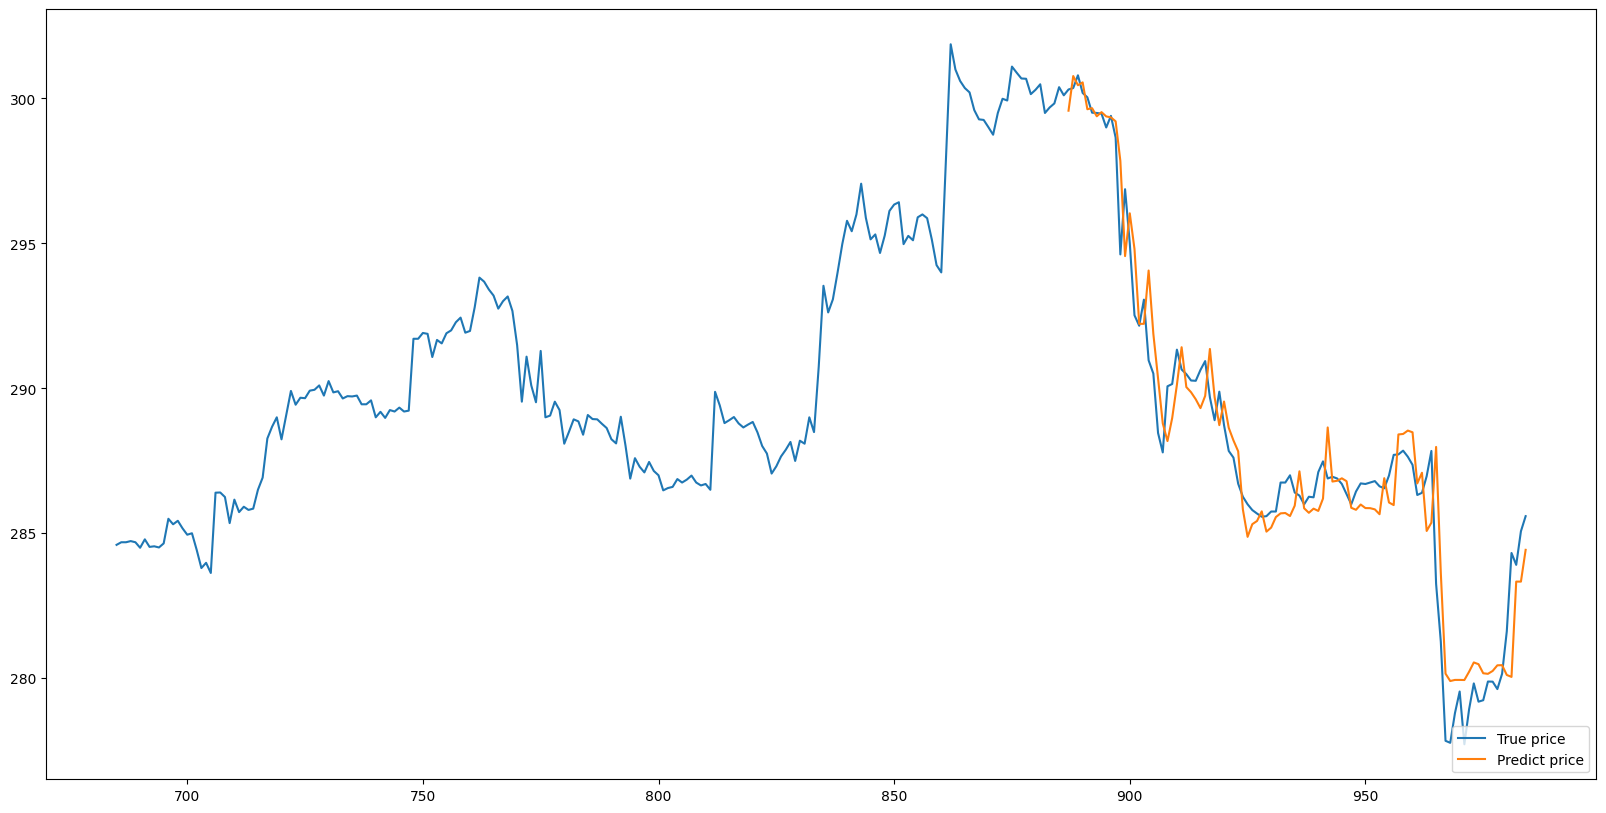

In [103]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

C:\Users\USER\AppData\Local\Temp\ipykernel_14184\3392056936.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\3392056936.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\3392056936.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

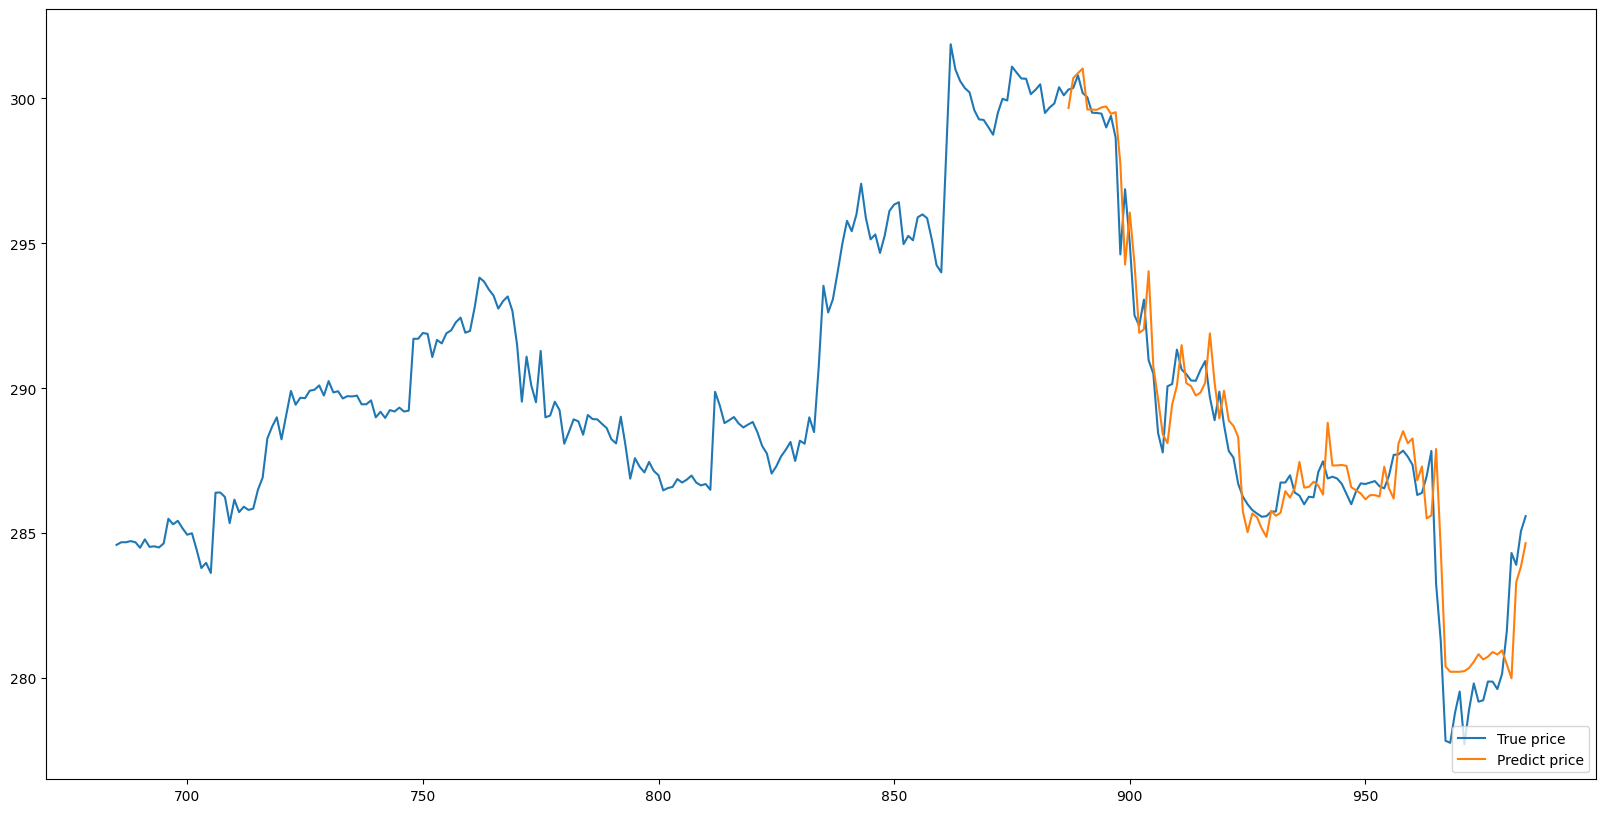

In [104]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1439481525.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1439481525.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1439481525.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

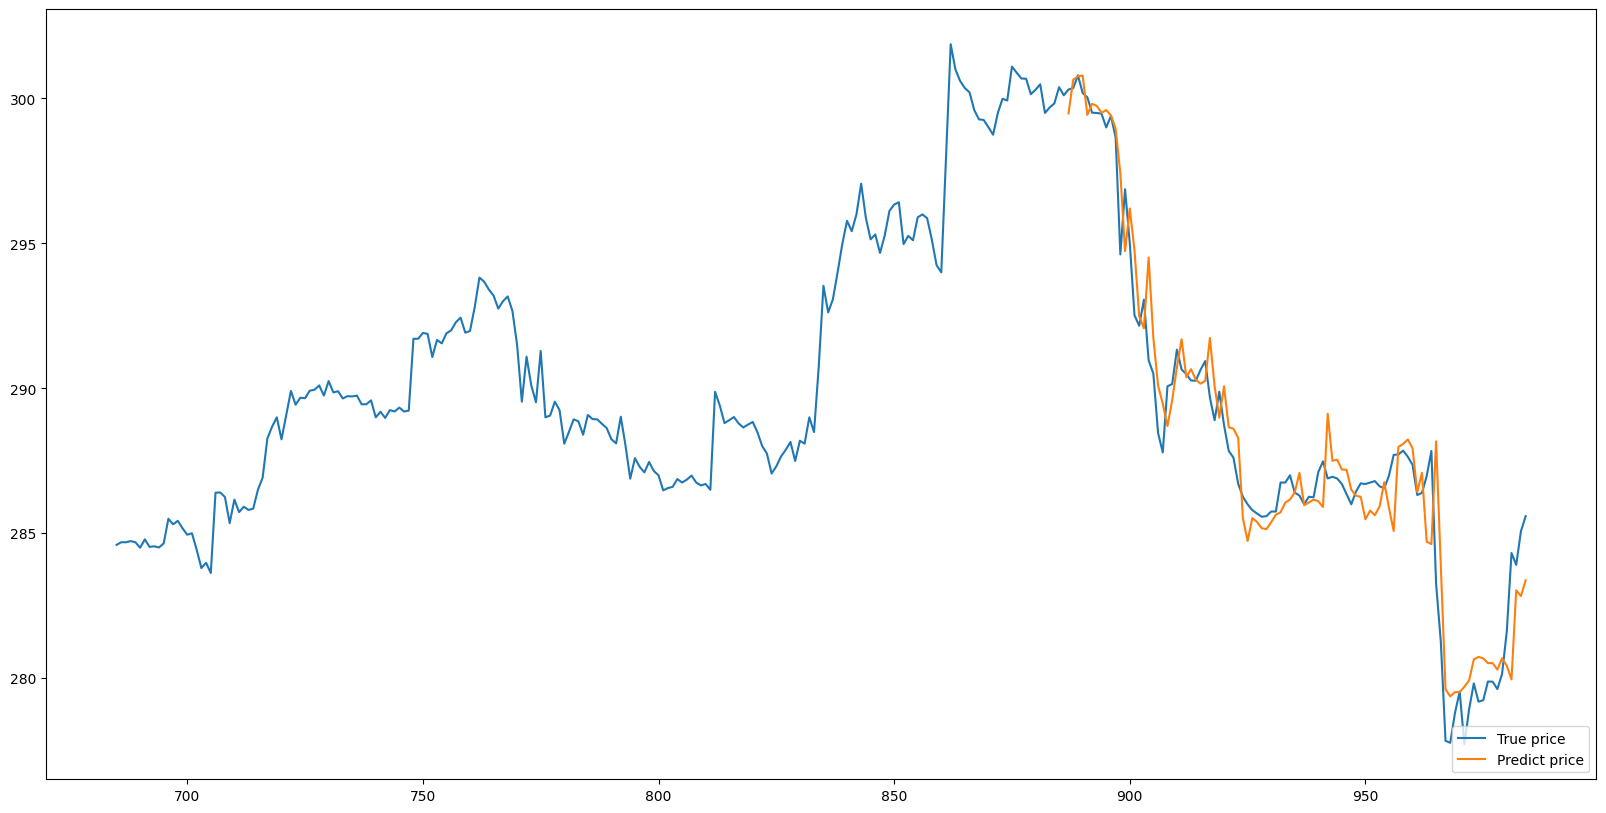

In [105]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1439481525.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1439481525.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1439481525.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

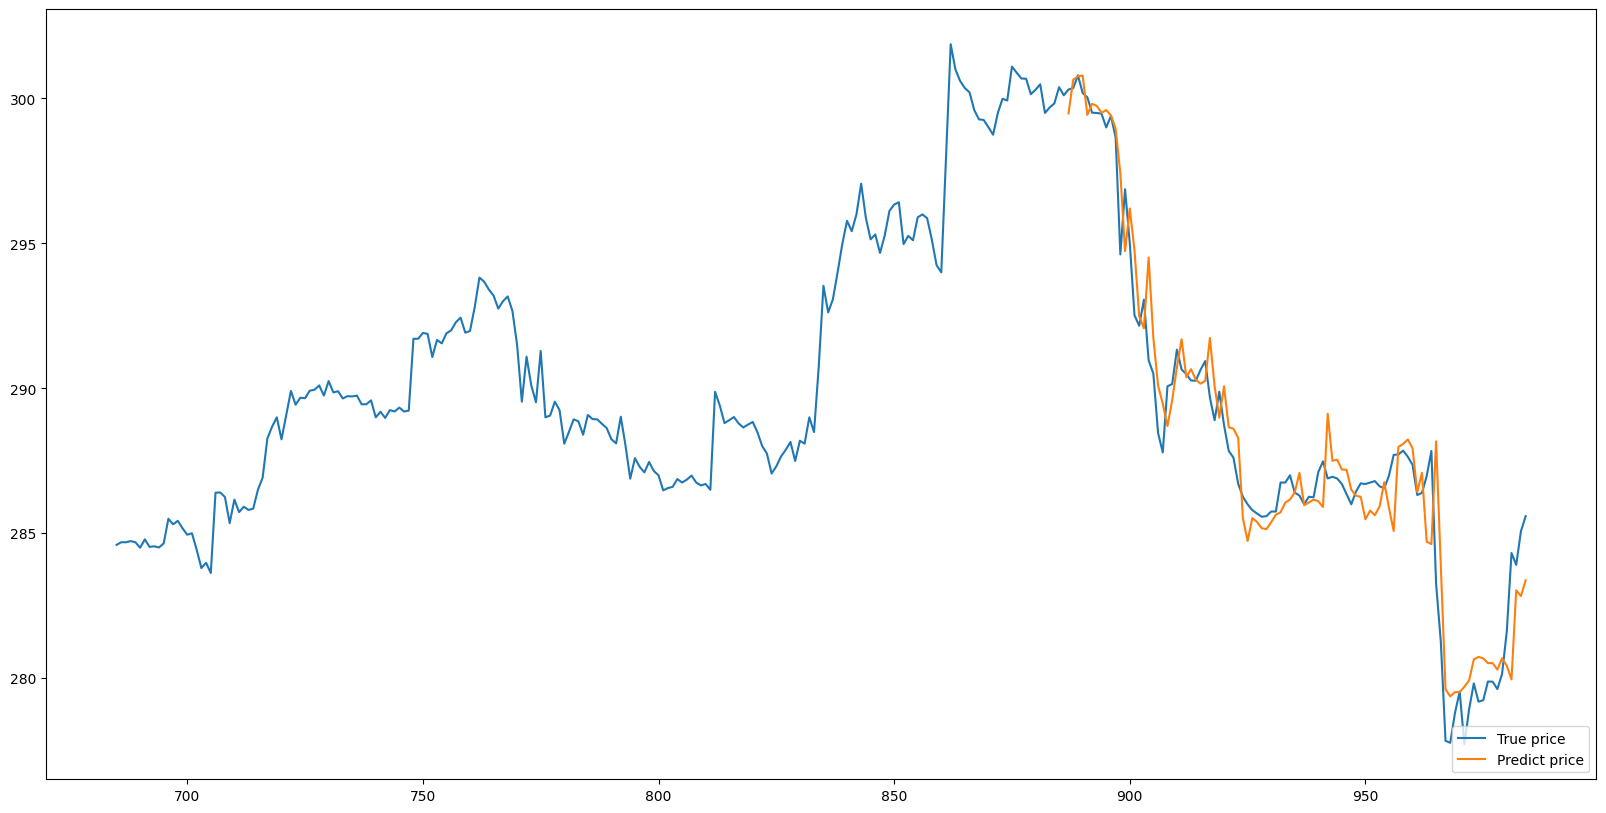

In [106]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

C:\Users\USER\AppData\Local\Temp\ipykernel_14184\3001060327.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\3001060327.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\3001060327.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

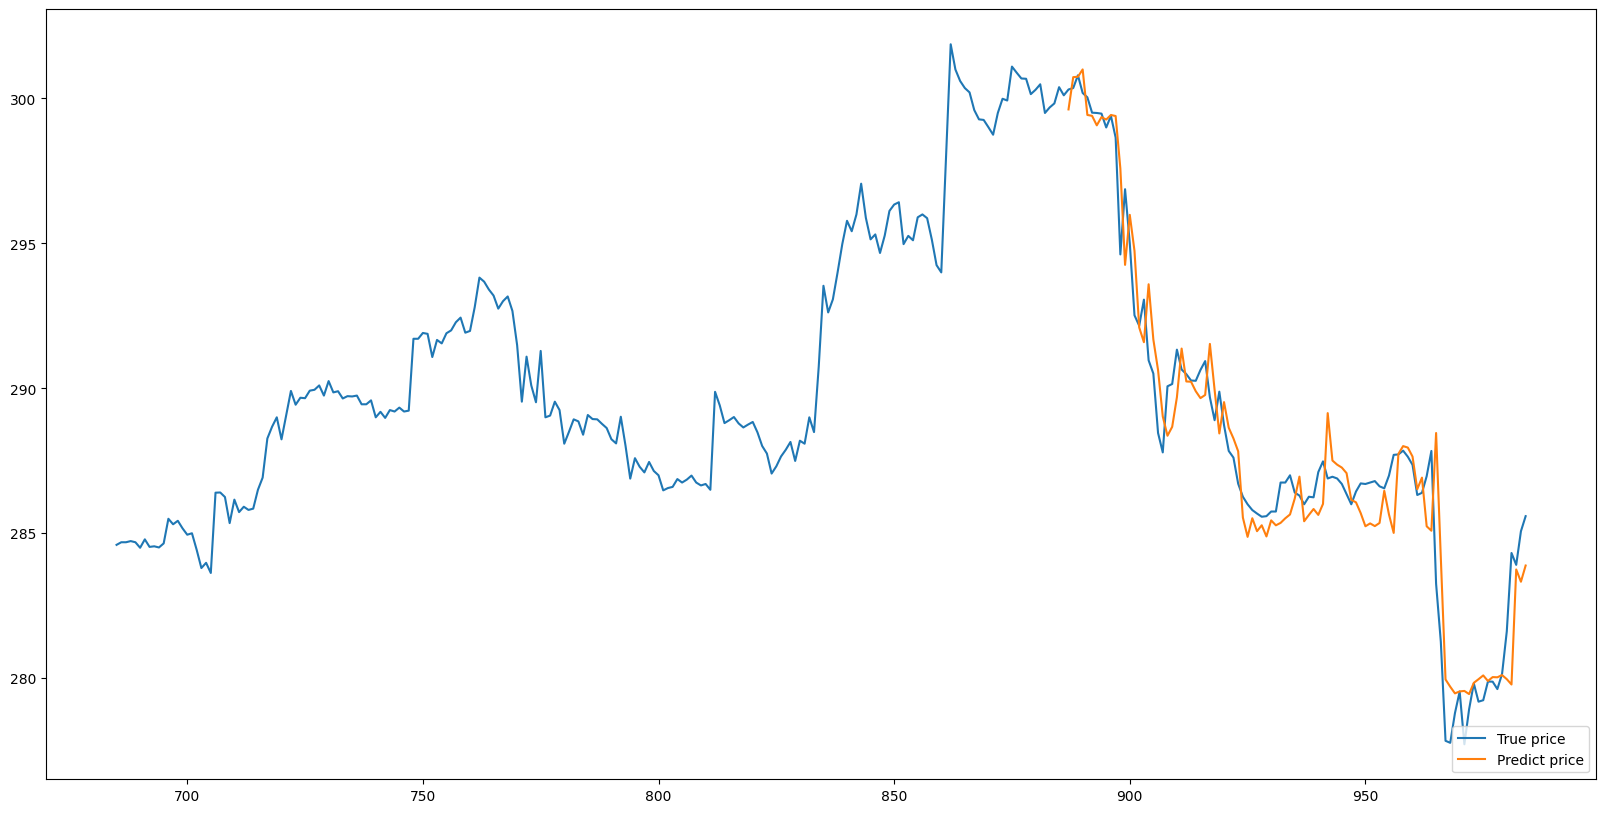

In [107]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1833709827.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1833709827.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\1833709827.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

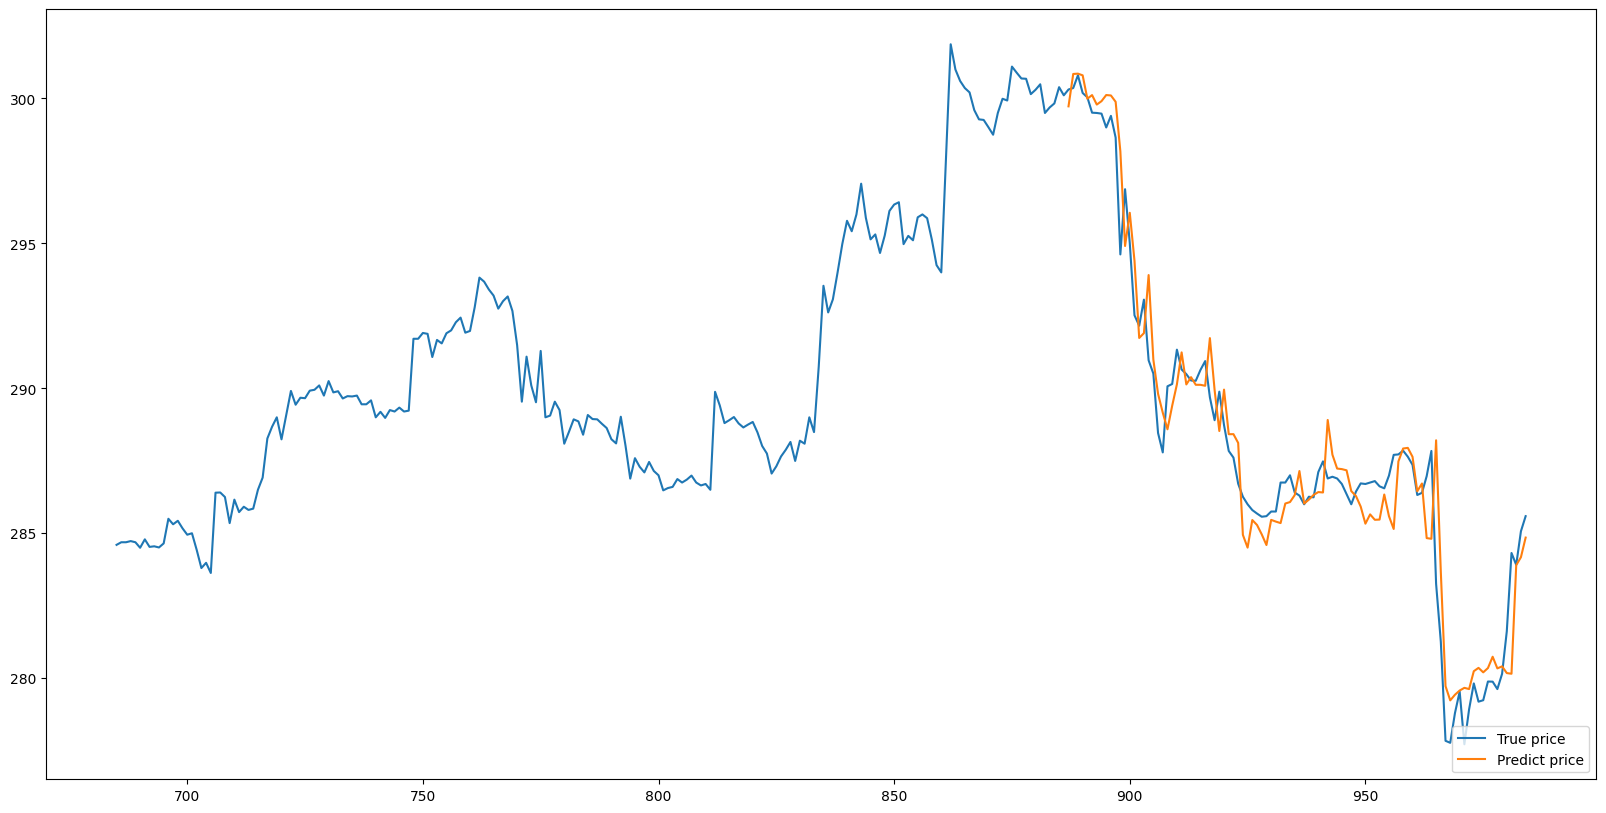

In [108]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["RMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

C:\Users\USER\AppData\Local\Temp\ipykernel_14184\2828653125.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\2828653125.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\2828653125.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

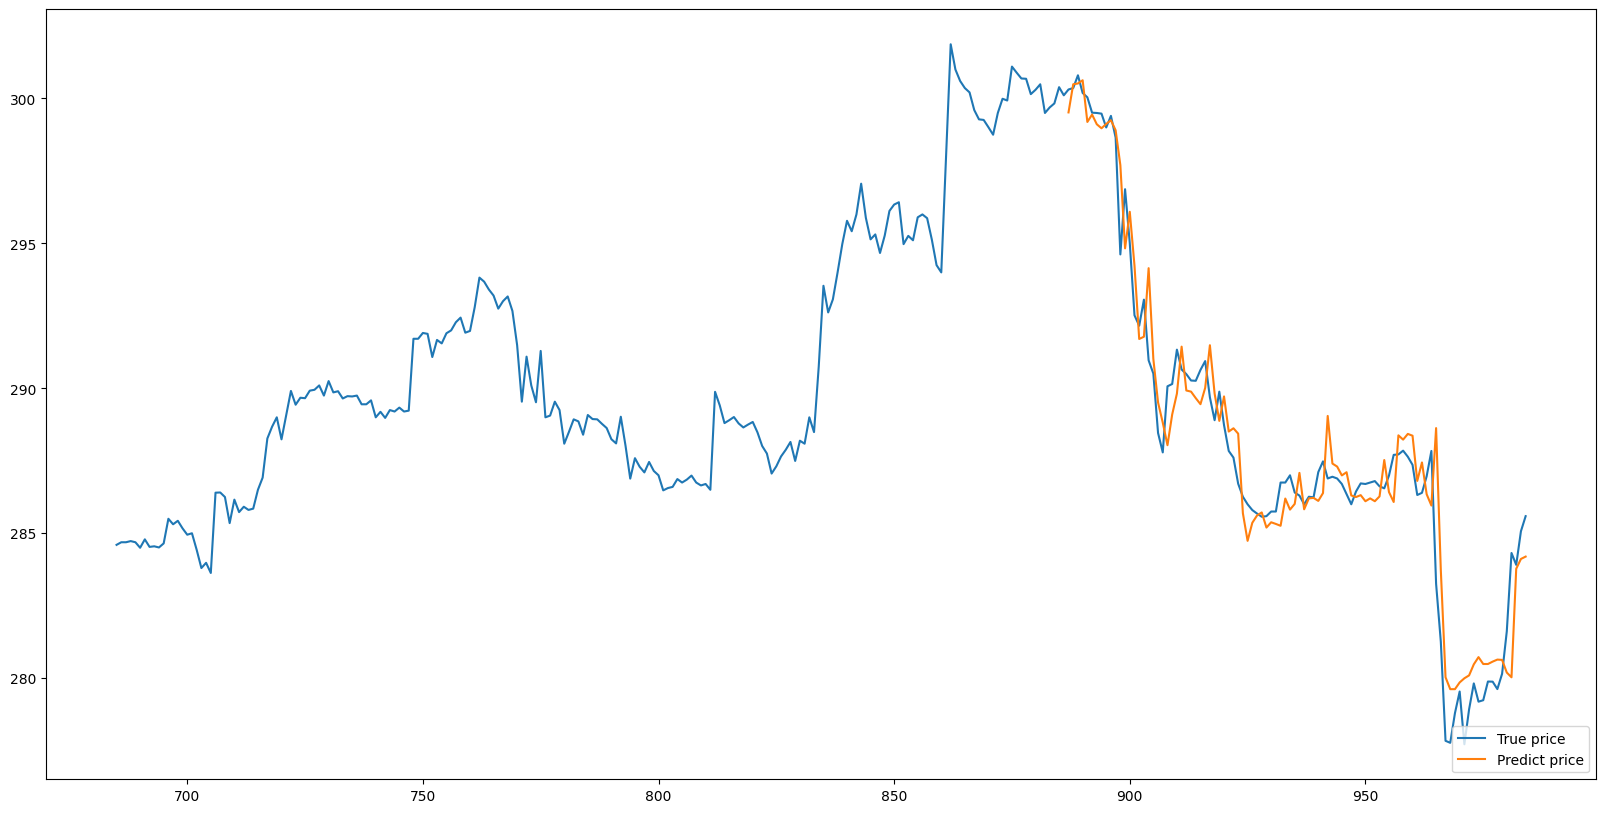

In [109]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

C:\Users\USER\AppData\Local\Temp\ipykernel_14184\4263487865.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\4263487865.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_14184\4263487865.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

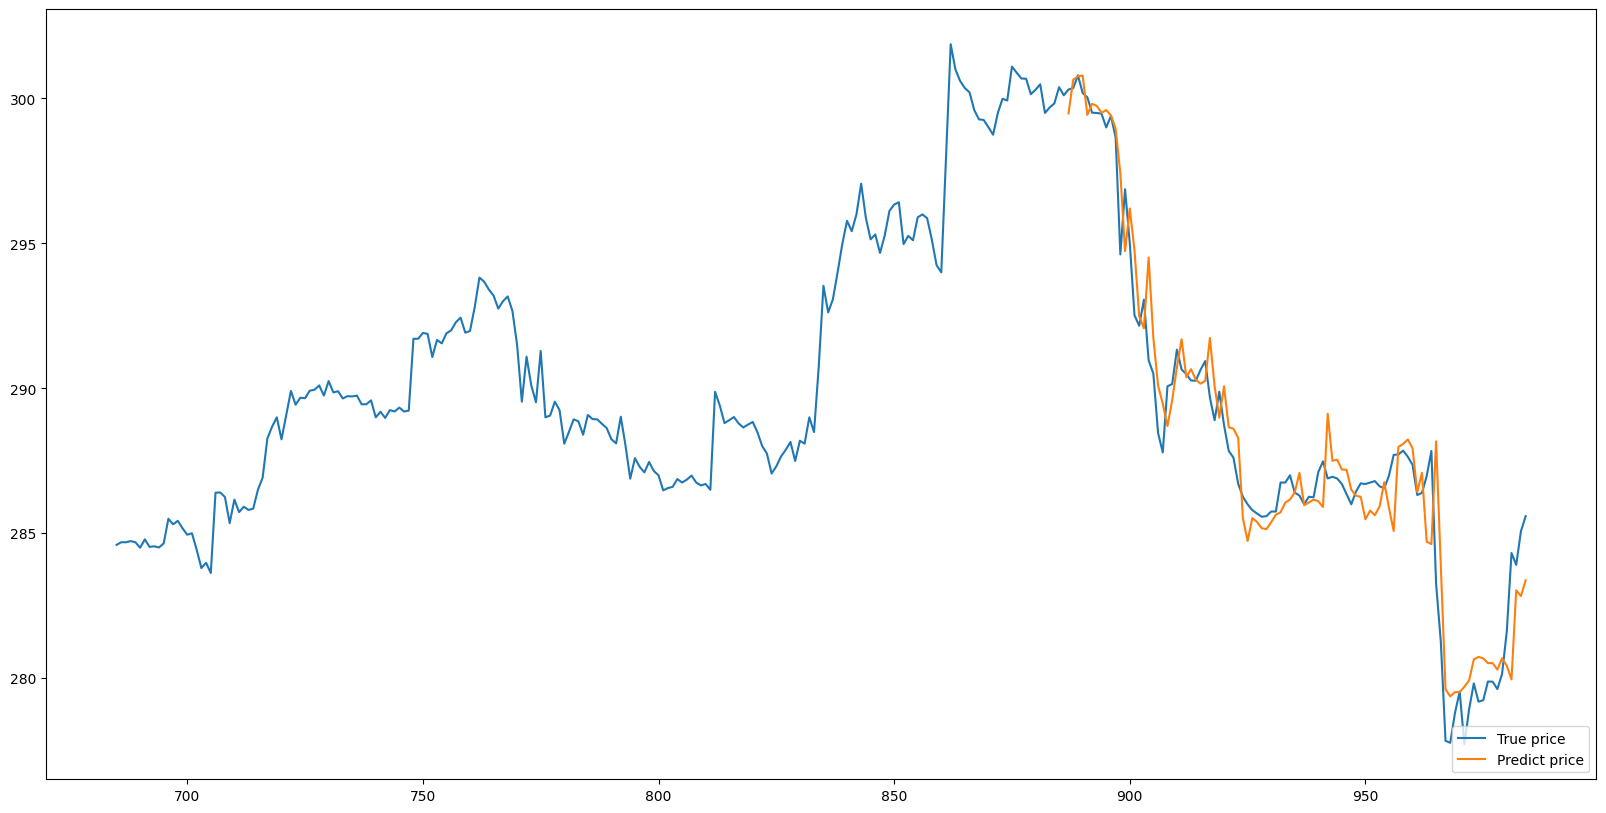

In [110]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["RMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### Predict Future

In [111]:
def xgboost_predict_future(data, modelName, indicatorArr, period):
    modelFileName = './MODEL/' + modelName
    sorted(indicatorArr)
    for indicator in indicatorArr:
        if indicator == 'close':
            continue
        modelFileName = modelFileName + '_' + indicator
    modelFileName = modelFileName + '.dat'
    model = pickle.load(open(modelFileName, "rb"))
    numDataPoint = int(period / 15)
    
    temp = indicatorArr.copy()
    temp.append('volume')
    data = data[temp]
    data = data[-5:]
    
    X = pd.DataFrame({})
    for column in data.columns:
        n = len(data)
        for i in range(1, n + 1):
            X[column + '_date_' + str(i)] = [data.iloc[n - i][column]] 
    
    predictedValue = model.predict(X)
    
    return predictedValue